### 절취선

In [1]:
# 발소리, 말소리, 가구끄는 소리 분류 AI 모델
# Google Colab 최적화 버전

# =============================================================================
# 1. 필수 라이브러리 설치 및 임포트
# =============================================================================

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import librosa
import librosa.display
import soundfile as sf
import scipy.signal
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

from google.colab import files, drive
from IPython.display import Audio, display, HTML
from tqdm.auto import tqdm
import multiprocessing as mp

print("🎵 발소리-말소리-가구끄는소리 분류 AI 모델이 준비되었습니다!")
print("=" * 70)


🎵 발소리-말소리-가구끄는소리 분류 AI 모델이 준비되었습니다!


In [20]:
# =============================================================================
# 2. Colab 환경 최적화
# =============================================================================

def setup_colab_environment():
    """Colab 환경 최적화"""
    try:
        mp.set_start_method('spawn', force=True)
    except:
        pass

    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ['OMP_NUM_THREADS'] = '1'

    # 한글 폰트 설정
    setup_korean_font()

    # Google Drive 마운트
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive 마운트 완료")
    except:
        print("⚠️ Google Drive 마운트 실패 또는 이미 마운트됨")

    print("✅ Colab 환경 최적화 완료")

def setup_korean_font():
    """한글 폰트 설정"""
    try:
        # 나눔고딕 폰트 설치
        !apt-get update -qq
        !apt-get install -qq fonts-nanum

        # matplotlib 폰트 설정
        import matplotlib.font_manager as fm
        import matplotlib.pyplot as plt

        # 폰트 캐시 삭제
        !rm -rf ~/.cache/matplotlib

        # 나눔고딕 폰트 경로
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

        if os.path.exists(font_path):
            # 폰트 등록
            fm.fontManager.addfont(font_path)

            # matplotlib 기본 폰트 설정
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

            print("✅ 한글 폰트 설정 완료")
        else:
            # 대체 방법: 구글 폰트 사용
            !wget -O NanumGothic.ttf "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

            # 폰트 등록
            fm.fontManager.addfont('./NanumGothic.ttf')
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False

            print("✅ 한글 폰트 설정 완료 (대체 폰트)")

    except Exception as e:
        print(f"⚠️ 한글 폰트 설정 실패: {e}")
        print("   영어로 표시됩니다.")

        # 영어 레이블로 대체
        plt.rcParams['font.family'] = 'DejaVu Sans'

def test_korean_font():
    """한글 폰트 테스트"""
    print("🔤 한글 폰트 테스트 중...")

    plt.figure(figsize=(10, 6))

    # 테스트 데이터
    classes = ['발소리', '말소리', '가구끄는소리']
    values = [85.2, 92.1, 78.9]
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    # 바 차트 생성
    bars = plt.bar(classes, values, color=colors, alpha=0.8)

    # 제목 및 레이블
    plt.title('한글 폰트 테스트 - 클래스별 정확도', fontsize=16, fontweight='bold')
    plt.xlabel('음성 클래스', fontsize=12)
    plt.ylabel('정확도 (%)', fontsize=12)

    # 값 표시
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.ylim(0, 100)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 폰트 상태 확인
    current_font = plt.rcParams['font.family']
    print(f"✅ 현재 폰트: {current_font}")

    if 'NanumGothic' in current_font or 'Nanum' in str(current_font):
        print("🎉 한글 폰트가 제대로 설정되었습니다!")
    else:
        print("⚠️ 한글 폰트 설정에 문제가 있을 수 있습니다.")
        print("   위 그래프에서 한글이 깨져 보인다면 런타임을 재시작해보세요.")

def memory_cleanup():
    """메모리 정리"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 메모리 정리 완료")

# =============================================================================
# 3. 3클래스 오디오 데이터셋 (발소리, 말소리, 가구끄는소리)
# =============================================================================

class ThreeClassAudioDataset(Dataset):
    def __init__(self, audio_paths, labels, target_sr=16000, max_duration=5.0, augment=False):
        """
        3클래스 오디오 분류 데이터셋

        Args:
            audio_paths: 오디오 파일 경로 리스트
            labels: 레이블 리스트 ['footstep', 'speech', 'furniture']
            target_sr: 목표 샘플링 레이트 (16kHz)
            max_duration: 최대 길이 (5초)
            augment: 데이터 증강 여부
        """
        self.audio_paths = audio_paths
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.max_length = int(target_sr * max_duration)
        self.augment = augment

        # 레이블 매핑
        self.class_names = ['footstep', 'speech', 'furniture']
        self.label_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        self.idx_to_label = {idx: name for name, idx in self.label_to_idx.items()}

        # 레이블 인코딩
        self.labels = [self.label_to_idx[label] for label in labels]

        print(f"📊 데이터셋 정보:")
        print(f"   - 총 샘플 수: {len(self.audio_paths)}")
        print(f"   - 클래스: {self.class_names}")
        for i, class_name in enumerate(self.class_names):
            count = sum(1 for label in self.labels if label == i)
            print(f"   - {class_name}: {count}개")

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        try:
            # 오디오 로드
            audio, sr = librosa.load(
                self.audio_paths[idx],
                sr=self.target_sr,
                duration=self.max_duration
            )

            # 길이 정규화
            audio = self._normalize_length(audio)

            # 데이터 증강
            if self.augment:
                audio = self._augment_audio(audio)

            # 특징 추출 (Mel-spectrogram + MFCC)
            features = self._extract_features(audio)

            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([self.labels[idx]]),
                'path': self.audio_paths[idx]
            }

        except Exception as e:
            print(f"오디오 로딩 오류 {self.audio_paths[idx]}: {e}")
            # 빈 특징 반환
            features = np.zeros((128, 157))  # 기본 특징 크기
            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([0]),
                'path': self.audio_paths[idx]
            }

    def _normalize_length(self, audio):
        """오디오 길이 정규화"""
        if len(audio) > self.max_length:
            # 랜덤 크롭
            start = np.random.randint(0, len(audio) - self.max_length + 1)
            audio = audio[start:start + self.max_length]
        elif len(audio) < self.max_length:
            # 제로 패딩
            audio = np.pad(audio, (0, self.max_length - len(audio)))
        return audio

    def _augment_audio(self, audio):
        """오디오 데이터 증강"""
        # 시간 이동
        if np.random.random() > 0.5:
            shift = np.random.randint(-len(audio)//8, len(audio)//8)
            audio = np.roll(audio, shift)

        # 볼륨 조절
        if np.random.random() > 0.5:
            volume_factor = np.random.uniform(0.7, 1.3)
            audio = audio * volume_factor

        # 가우시안 노이즈 추가
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.005, len(audio))
            audio = audio + noise

        # 피치 시프트 (가끔)
        if np.random.random() > 0.8:
            pitch_shift = np.random.randint(-2, 3)
            if pitch_shift != 0:
                audio = librosa.effects.pitch_shift(audio, sr=self.target_sr, n_steps=pitch_shift)

        return np.clip(audio, -1.0, 1.0)

    def _extract_features(self, audio):
        """특징 추출: Mel-spectrogram + MFCC"""
        # Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.target_sr,
            n_mels=64,
            fmax=8000,
            hop_length=512,
            n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # MFCC
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.target_sr,
            n_mfcc=64,
            hop_length=512,
            n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 고정 크기로 조정
        target_frames = 157  # 5초 * 16000 / 512 ≈ 157
        if features.shape[1] != target_frames:
            features = self._resize_features(features, target_frames)

        return features

    def _resize_features(self, features, target_frames):
        """특징 크기 조정"""
        from scipy.ndimage import zoom
        zoom_factor = target_frames / features.shape[1]
        return zoom(features, (1, zoom_factor))

# =============================================================================
# 4. 3클래스 분류 CNN 모델
# =============================================================================

class ThreeClassAudioCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(ThreeClassAudioCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input: (batch_size, features, time)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =============================================================================
# 5. 학습 매니저
# =============================================================================

class ThreeClassTrainer:
    def __init__(self, model, train_loader, val_loader, device='auto', lr=0.001):
        self.device = torch.device('cuda' if torch.cuda.is_available() and device=='auto' else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # 최적화 설정
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.01
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',  # 정확도 기준
            patience=5,
            factor=0.5,
            verbose=True
        )
        self.criterion = nn.CrossEntropyLoss()

        # 기록
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_acc = 0.0
        self.best_model_state = None

        print(f"🎯 학습 설정:")
        print(f"   - 장치: {self.device}")
        print(f"   - 학습률: {lr}")
        print(f"   - 클래스: 3개 (발소리, 말소리, 가구끄는소리)")

    def train_epoch(self):
        """한 에포크 학습"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="학습")
        for batch in pbar:
            inputs = batch['features'].to(self.device)
            labels = batch['label'].squeeze().to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 진행률 업데이트
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.1f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """검증"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="검증")
            for batch in pbar:
                inputs = batch['features'].to(self.device)
                labels = batch['label'].squeeze().to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 혼동행렬용 데이터 수집
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.1f}%'
                })

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, all_preds, all_labels

    def train(self, num_epochs=30, save_path='best_three_class_model.pth'):
        """전체 학습"""
        print("🚀 3클래스 분류 학습 시작!")
        print("=" * 50)

        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

            # 학습
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # 검증
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            # 스케줄러 업데이트
            self.scheduler.step(val_acc)

            print(f"   학습 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"   검증 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
            print(f"   학습률: {self.optimizer.param_groups[0]['lr']:.6f}")

            # 최고 모델 저장
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': ['footstep', 'speech', 'furniture']
                }, save_path)

                print(f"   ✅ 최고 모델 저장! (검증 정확도: {val_acc:.2f}%)")

                # 클래스별 정확도 출력
                self.print_class_accuracy(val_labels, val_preds)

            # 조기 종료
            if self.optimizer.param_groups[0]['lr'] < 1e-6:
                print("   ⏹️ 학습률이 너무 낮아 학습을 종료합니다.")
                break

            # 메모리 정리
            if epoch % 5 == 0:
                memory_cleanup()

        print(f"\n🎉 학습 완료!")
        print(f"   최고 검증 정확도: {self.best_val_acc:.2f}%")

        # 최고 모델 로드
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        return self.model

    def print_class_accuracy(self, true_labels, pred_labels):
        """클래스별 정확도 출력"""
        class_names = ['발소리', '말소리', '가구끄는소리']

        for i, class_name in enumerate(class_names):
            class_mask = np.array(true_labels) == i
            if class_mask.sum() > 0:
                class_acc = (np.array(pred_labels)[class_mask] == i).sum() / class_mask.sum()
                print(f"     - {class_name}: {class_acc*100:.1f}%")

    def plot_training_history(self):
        """학습 히스토리 시각화 - 한글 지원"""
        # 한글 폰트 설정 확인
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 손실 그래프
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='학습 손실', linewidth=2, alpha=0.8)
        ax1.plot(epochs, self.val_losses, 'r-', label='검증 손실', linewidth=2, alpha=0.8)
        ax1.set_title('학습/검증 손실', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax1.set_ylabel('손실 (Loss)', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, len(self.train_losses))

        # 정확도 그래프
        ax2.plot(epochs, self.train_accs, 'b-', label='학습 정확도', linewidth=2, alpha=0.8)
        ax2.plot(epochs, self.val_accs, 'r-', label='검증 정확도', linewidth=2, alpha=0.8)
        ax2.set_title('학습/검증 정확도', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax2.set_ylabel('정확도 (%)', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        ax2.set_xlim(1, len(self.train_accs))

        # 최고 성능 지점 표시
        best_epoch = np.argmax(self.val_accs) + 1
        best_acc = max(self.val_accs)
        ax2.plot(best_epoch, best_acc, 'ro', markersize=10, markerfacecolor='red',
                markeredgecolor='darkred', markeredgewidth=2)
        ax2.annotate(f'최고: {best_acc:.1f}%\n(에포크 {best_epoch})',
                    xy=(best_epoch, best_acc), xytext=(10, 10),
                    textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()
        plt.show()

        # 상세 결과 출력
        print("\n" + "="*60)
        print("📊 학습 완료 - 최종 결과 요약")
        print("="*60)
        print(f"🎯 최고 검증 정확도: {max(self.val_accs):.2f}% (에포크 {np.argmax(self.val_accs)+1})")
        print(f"📈 최종 학습 정확도: {self.train_accs[-1]:.2f}%")
        print(f"📉 최종 검증 손실: {self.val_losses[-1]:.4f}")
        print(f"⏱️ 총 학습 에포크: {len(self.train_accs)}개")

        # 성능 안정성 분석
        last_5_accs = self.val_accs[-5:] if len(self.val_accs) >= 5 else self.val_accs
        stability = np.std(last_5_accs)
        print(f"📊 최근 5에포크 정확도 안정성: {stability:.2f}% (낮을수록 안정)")

        if stability < 2.0:
            print("✅ 매우 안정적인 학습!")
        elif stability < 5.0:
            print("👍 안정적인 학습")
        else:
            print("⚠️ 불안정한 학습 - 더 많은 에포크나 조기종료 필요")

        print("="*60)

# =============================================================================
# 6. 데이터 처리 및 학습 실행 함수
# =============================================================================

def scan_three_class_data(base_path):
    """3클래스 데이터 스캔 - 강화버전"""
    audio_files = []
    labels = []

    # 지원되는 오디오 확장자 (더 많은 형식 추가)
    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    print(f"📂 {base_path}에서 오디오 파일 스캔 중...")
    print(f"   지원 확장자: {', '.join(extensions)}")

    # 각 클래스별 폴더에서 파일 수집 (더 많은 키워드 추가)
    class_folders = {
        'footstep': ['footstep', 'footsteps', 'foot', 'walk', 'walking', 'step',
                    '발소리', '걸음소리', '발걸음', '보행', 'steps', 'footfall'],
        'speech': ['speech', 'voice', 'talk', 'talking', 'speaking', '말소리', 'speak',
                  '음성', '대화', '목소리', 'vocal', 'utterance', 'conversation'],
        'furniture': ['furniture', 'chair', 'table', 'drag', 'move', '가구', 'scrape',
                     '끄는소리', '이동', '의자', '테이블', 'moving', 'sliding', 'dragging']
    }

    # 모든 하위 디렉토리 탐색
    total_files_found = 0
    processed_dirs = []

    for root, dirs, files in os.walk(base_path):
        folder_name = os.path.basename(root).lower()
        relative_path = os.path.relpath(root, base_path)

        # 오디오 파일이 있는지 확인
        audio_files_in_dir = [f for f in files if any(f.lower().endswith(ext) for ext in extensions)]

        if audio_files_in_dir:
            print(f"   📁 {relative_path} - {len(audio_files_in_dir)}개 오디오 파일 발견")
            total_files_found += len(audio_files_in_dir)

            # 폴더명으로 클래스 판단
            detected_class = None
            for class_name, keywords in class_folders.items():
                if any(keyword in folder_name for keyword in keywords):
                    detected_class = class_name
                    break

            # 클래스가 자동 감지되지 않으면 사용자에게 물어보기
            if detected_class is None:
                print(f"   ❓ '{folder_name}' 폴더의 클래스를 판단할 수 없습니다.")
                print(f"      다음 중 하나를 선택하세요:")
                print(f"      1: footstep (발소리)")
                print(f"      2: speech (말소리)")
                print(f"      3: furniture (가구끄는소리)")
                print(f"      0: skip (건너뛰기)")

                try:
                    choice = input(f"   선택 (1/2/3/0): ").strip()
                    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}
                    if choice in class_mapping:
                        detected_class = class_mapping[choice]
                        print(f"   ✅ '{folder_name}' -> {detected_class}")
                    else:
                        print(f"   ⏩ '{folder_name}' 폴더 건너뜀")
                        continue
                except:
                    print(f"   ⏩ 입력 오류로 '{folder_name}' 폴더 건너뜀")
                    continue
            else:
                print(f"   ✅ {relative_path} -> {detected_class}")

            # 파일 추가
            for file in audio_files_in_dir:
                file_path = os.path.join(root, file)
                audio_files.append(file_path)
                labels.append(detected_class)

            processed_dirs.append((relative_path, detected_class, len(audio_files_in_dir)))

    # 상세 결과 출력
    print(f"\n📊 데이터 스캔 완료:")
    print(f"   - 총 발견된 오디오 파일: {total_files_found}개")
    print(f"   - 실제 사용할 파일: {len(audio_files)}개")
    print(f"   - 처리된 디렉토리: {len(processed_dirs)}개")

    print(f"\n📁 처리된 디렉토리 상세:")
    for dir_path, class_name, count in processed_dirs:
        print(f"   - {dir_path}: {class_name} ({count}개)")

    print(f"\n🏷️ 클래스별 파일 수:")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    if len(audio_files) == 0:
        print("\n❌ 사용 가능한 오디오 파일이 없습니다!")
        print("   다음을 확인해주세요:")
        print("   1. 파일 확장자가 지원되는지 확인")
        print("   2. 폴더 구조가 올바른지 확인")
        print("   3. 파일이 실제로 오디오 파일인지 확인")
        return [], []

    if total_files_found > len(audio_files):
        print(f"\n⚠️ 주의: {total_files_found - len(audio_files)}개 파일이 제외되었습니다.")
        print("   폴더명이 클래스와 매치되지 않아 제외되었을 수 있습니다.")

    return audio_files, labels

def detailed_data_analysis(base_path):
    """데이터 상세 분석"""
    print("🔍 데이터 구조 상세 분석 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    total_files = 0
    total_size = 0
    dir_info = []

    for root, dirs, files in os.walk(base_path):
        audio_files = []
        dir_size = 0

        for file in files:
            file_path = os.path.join(root, file)
            if any(file.lower().endswith(ext) for ext in extensions):
                audio_files.append(file)
                try:
                    file_size = os.path.getsize(file_path)
                    dir_size += file_size
                except:
                    pass

        if audio_files:
            relative_path = os.path.relpath(root, base_path)
            dir_info.append({
                'path': relative_path,
                'files': len(audio_files),
                'size_mb': dir_size / (1024*1024),
                'sample_files': audio_files[:3]  # 처음 3개 파일명
            })

            total_files += len(audio_files)
            total_size += dir_size

    print(f"\n📊 전체 통계:")
    print(f"   - 총 오디오 파일: {total_files}개")
    print(f"   - 총 크기: {total_size/(1024*1024):.1f} MB")
    print(f"   - 오디오가 있는 폴더: {len(dir_info)}개")

    print(f"\n📁 폴더별 상세 정보:")
    for info in sorted(dir_info, key=lambda x: x['files'], reverse=True):
        print(f"   📂 {info['path']}")
        print(f"      - 파일 수: {info['files']}개")
        print(f"      - 크기: {info['size_mb']:.1f} MB")
        print(f"      - 샘플: {', '.join(info['sample_files'])}")
        print()

    return dir_info

def force_scan_all_audio_files(base_path):
    """모든 오디오 파일 강제 스캔 (클래스 구분 없이)"""
    print("🔄 모든 오디오 파일 강제 스캔 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']
    all_files = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_path)
                all_files.append({
                    'path': file_path,
                    'relative': relative_path,
                    'dir': os.path.dirname(relative_path),
                    'filename': file
                })

    print(f"📊 전체 스캔 결과: {len(all_files)}개 오디오 파일 발견")

    # 디렉토리별 그룹화
    from collections import defaultdict
    dir_groups = defaultdict(list)

    for file_info in all_files:
        dir_name = file_info['dir'] if file_info['dir'] else 'root'
        dir_groups[dir_name].append(file_info)

    print(f"\n📁 디렉토리별 파일 수:")
    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"   {dir_name}: {len(file_list)}개")
        # 처음 3개 파일명 표시
        for i, file_info in enumerate(file_list[:3]):
            print(f"      - {file_info['filename']}")
        if len(file_list) > 3:
            print(f"      ... 그 외 {len(file_list)-3}개")
        print()

    return all_files, dir_groups

def run_three_class_training(data_path, num_epochs=30, batch_size=8, test_size=0.2):
    """3클래스 분류 학습 실행"""

    print("🎯 발소리-말소리-가구끄는소리 분류 학습 시작!")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()
    memory_cleanup()

    # 1. 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        print("📁 데이터 구조를 확인해주세요:")
        print("   your_dataset/")
        print("   ├── footstep/")
        print("   ├── speech/")
        print("   └── furniture/")
        return None

    # 2. 학습/검증 분할
    train_files, val_files, train_labels, val_labels = train_test_split(
        audio_files, labels, test_size=test_size, random_state=42, stratify=labels
    )

    print(f"\n📊 데이터 분할:")
    print(f"   - 학습: {len(train_files)}개")
    print(f"   - 검증: {len(val_files)}개")

    # 3. 데이터셋 생성
    train_dataset = ThreeClassAudioDataset(
        train_files, train_labels, augment=True
    )
    val_dataset = ThreeClassAudioDataset(
        val_files, val_labels, augment=False
    )

    # 4. 데이터 로더 생성
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )

    # 5. 모델 생성
    model = ThreeClassAudioCNN(num_classes=3)
    print(f"🤖 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    # 6. 학습 실행
    trainer = ThreeClassTrainer(model, train_loader, val_loader)
    trained_model = trainer.train(num_epochs=num_epochs)

    # 7. 결과 시각화
    trainer.plot_training_history()

    # 8. 혼동행렬 생성
    plot_confusion_matrix(trained_model, val_loader)

    return trained_model, trainer

def plot_confusion_matrix(model, val_loader):
    """혼동행렬 시각화 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['발소리', '말소리', '가구끄는소리']

    # 시각화
    plt.figure(figsize=(10, 8))

    # 한글 폰트 확인 및 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        # 폰트 설정이 안된 경우 영어로 대체
        class_names = ['Footstep', 'Speech', 'Furniture']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Frequency'})
    plt.title('혼동 행렬 (Confusion Matrix)', fontsize=16, pad=20)
    plt.xlabel('예측값 (Predicted)', fontsize=12)
    plt.ylabel('실제값 (Actual)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 분류 리포트
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names, output_dict=True)

    print("\n📊 상세 분류 결과:")
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        print(f"   {class_name}:")
        print(f"     - 정밀도(Precision): {precision:.3f}")
        print(f"     - 재현율(Recall): {recall:.3f}")
        print(f"     - F1-Score: {f1:.3f}")
        print(f"     - 샘플 수: {support}")

    print(f"\n   전체 정확도: {report['accuracy']:.3f}")
    print(f"   매크로 평균 F1: {report['macro avg']['f1-score']:.3f}")

    # 클래스별 정확도 바 차트
    plt.figure(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        if cm[i].sum() > 0:
            acc = cm[i, i] / cm[i].sum()
            class_accuracies.append(acc)
        else:
            class_accuracies.append(0)

    colors = ['#ff7f7f', '#7f7fff', '#7fff7f']
    bars = plt.bar(class_names, class_accuracies, color=colors, alpha=0.8)
    plt.title('클래스별 정확도', fontsize=16, pad=20)
    plt.xlabel('클래스', fontsize=12)
    plt.ylabel('정확도', fontsize=12)
    plt.ylim(0, 1.1)

    # 각 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. 실시간 예측 함수 (완성)
# =============================================================================

def predict_audio_file(model_path, audio_file_path):
    """오디오 파일 예측 - 완성 버전"""
    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    class_names = ['발소리', '말소리', '가구끄는소리']
    class_names_eng = ['footstep', 'speech', 'furniture']

    try:
        # 오디오 로드 및 전처리
        audio, sr = librosa.load(audio_file_path, sr=16000, duration=5.0)

        # 길이 정규화
        max_length = 16000 * 5
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        else:
            audio = audio[:max_length]

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        mfcc = librosa.feature.mfcc(
            y=audio, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 크기 조정
        target_frames = 157
        if features.shape[1] != target_frames:
            from scipy.ndimage import zoom
            zoom_factor = target_frames / features.shape[1]
            features = zoom(features, (1, zoom_factor))

        # 예측
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).unsqueeze(0)  # 배치 차원 추가
            outputs = model(features_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # 결과 반환
        result = {
            'predicted_class': class_names[predicted_class],
            'predicted_class_eng': class_names_eng[predicted_class],
            'confidence': confidence,
            'probabilities': {
                class_names[i]: prob.item()
                for i, prob in enumerate(probabilities[0])
            }
        }

        # 시각화
        visualize_prediction_result(audio, sr, features, result)

        return result

    except Exception as e:
        print(f"❌ 예측 오류: {str(e)}")
        return None

def visualize_prediction_result(audio, sr, features, result):
    """예측 결과 시각화"""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('오디오 파형', '특징 맵 (Mel-spec + MFCC)', '예측 확률', '주파수 스펙트럼'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "bar"}, {"secondary_y": False}]]
    )

    # 1. 오디오 파형
    time = np.linspace(0, len(audio)/sr, len(audio))
    fig.add_trace(
        go.Scatter(x=time, y=audio, name='오디오 신호', line=dict(color='blue')),
        row=1, col=1
    )

    # 2. 특징 맵
    fig.add_trace(
        go.Heatmap(z=features, colorscale='Viridis', name='특징 맵'),
        row=1, col=2
    )

    # 3. 예측 확률
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['red' if cls == result['predicted_class'] else 'lightblue' for cls in classes]

    fig.add_trace(
        go.Bar(x=classes, y=probs, name='예측 확률',
               marker=dict(color=colors)),
        row=2, col=1
    )

    # 4. 주파수 스펙트럼
    freqs = np.fft.fftfreq(len(audio), 1/sr)[:len(audio)//2]
    fft_vals = np.abs(np.fft.fft(audio))[:len(audio)//2]

    fig.add_trace(
        go.Scatter(x=freqs, y=fft_vals, name='주파수 스펙트럼', line=dict(color='green')),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        title_text=f"예측 결과: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})"
    )
    fig.show()

    # 결과 출력
    print(f"\n🎯 예측 결과:")
    print(f"   - 예측 클래스: {result['predicted_class']}")
    print(f"   - 신뢰도: {result['confidence']:.3f}")
    print(f"\n📊 모든 클래스 확률:")
    for class_name, prob in result['probabilities'].items():
        print(f"   - {class_name}: {prob:.3f}")

# =============================================================================
# 8. 샘플 데이터 생성기
# =============================================================================

def generate_sample_audio_data(output_dir='sample_data', samples_per_class=20):
    """테스트용 샘플 오디오 데이터 생성"""
    print("🎼 샘플 오디오 데이터 생성 중...")

    os.makedirs(output_dir, exist_ok=True)

    # 각 클래스별 폴더 생성
    classes = ['footstep', 'speech', 'furniture']
    for class_name in classes:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

    sr = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sr * duration))

    for i in range(samples_per_class):
        # 발소리 시뮬레이션 (짧은 충격음들)
        footstep = np.zeros_like(t)
        for step in range(4):  # 4번의 발걸음
            start_idx = int(step * len(t) / 4) + np.random.randint(-1000, 1000)
            if 0 <= start_idx < len(t) - 1000:
                # 충격음 시뮬레이션
                impact = np.exp(-np.arange(1000) * 0.01) * np.sin(2 * np.pi * np.random.uniform(80, 200) * np.arange(1000) / sr)
                footstep[start_idx:start_idx+1000] += impact * np.random.uniform(0.3, 0.8)

        # 노이즈 추가
        footstep += np.random.normal(0, 0.02, len(footstep))
        footstep = np.clip(footstep, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'footstep', f'footstep_{i:03d}.wav'), footstep, sr)

        # 말소리 시뮬레이션 (여러 주파수 성분)
        speech = np.zeros_like(t)
        # 기본 음성 주파수들 (100-300Hz)
        for freq in [120, 180, 240, 300]:
            amplitude = np.random.uniform(0.1, 0.3)
            speech += amplitude * np.sin(2 * np.pi * freq * t)

        # 포먼트 시뮬레이션 (800-2000Hz)
        for freq in [800, 1200, 1600, 2000]:
            amplitude = np.random.uniform(0.05, 0.15)
            modulation = 1 + 0.5 * np.sin(2 * np.pi * np.random.uniform(5, 15) * t)
            speech += amplitude * np.sin(2 * np.pi * freq * t) * modulation

        # 노이즈 및 변조
        speech *= (1 + 0.3 * np.sin(2 * np.pi * np.random.uniform(1, 5) * t))
        speech += np.random.normal(0, 0.02, len(speech))
        speech = np.clip(speech, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'speech', f'speech_{i:03d}.wav'), speech, sr)

        # 가구끄는소리 시뮬레이션 (마찰음)
        furniture = np.zeros_like(t)

        # 마찰음 기본 주파수 (낮은 주파수 + 고주파 노이즈)
        base_freq = np.random.uniform(20, 80)
        furniture += 0.4 * np.sin(2 * np.pi * base_freq * t)

        # 고주파 마찰음 (1-4kHz)
        high_freq_noise = np.random.normal(0, 0.1, len(t))
        butter_b, butter_a = scipy.signal.butter(4, [1000, 4000], btype='band', fs=sr)
        high_freq_filtered = scipy.signal.filtfilt(butter_b, butter_a, high_freq_noise)
        furniture += 0.3 * high_freq_filtered

        # 불규칙한 진동 패턴
        irregular_pattern = np.random.uniform(0.5, 1.5, 100)
        furniture *= np.interp(t, np.linspace(0, duration, 100), irregular_pattern)

        furniture = np.clip(furniture, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'furniture', f'furniture_{i:03d}.wav'), furniture, sr)

    print(f"✅ 샘플 데이터 생성 완료!")
    print(f"   - 경로: {output_dir}")
    print(f"   - 클래스별 {samples_per_class}개씩 총 {samples_per_class * 3}개 파일")

    return output_dir

# =============================================================================
# 9. 실시간 녹음 및 예측
# =============================================================================

def record_and_predict(model_path, duration=5):
    """실시간 녹음 및 예측"""
    print(f"🎤 {duration}초간 녹음을 시작합니다...")
    print("   마이크에 대고 소리를 내세요!")

    try:
        # JavaScript를 사용한 녹음 (Colab 환경)
        from google.colab import output
        from base64 import b64decode

        RECORD = """
        const sleep = time => new Promise(resolve => setTimeout(resolve, time))
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader()
          reader.onloadend = e => resolve(e.srcElement.result)
          reader.readAsDataURL(blob)
        })

        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({ audio: true })
          recorder = new MediaRecorder(stream)
          chunks = []
          recorder.ondataavailable = e => chunks.push(e.data)
          recorder.onstop = async ()=>{
            blob = new Blob(chunks, { type: 'audio/wav' })
            text = await b2text(blob)
            resolve(text)
          }
          recorder.start()
          await sleep(time)
          recorder.stop()
        })
        """

        display(HTML(f'''
        <script>
        {RECORD}
        </script>
        <button onclick="record({duration * 1000}).then(audio => {{
            google.colab.kernel.invokeFunction('save_audio', [audio], {{}})
        }})">🎤 녹음 시작 ({duration}초)</button>
        '''))

        print("   위의 녹음 버튼을 클릭해주세요!")

    except Exception as e:
        print(f"❌ 녹음 기능 오류: {e}")
        print("   대신 파일 업로드를 사용해주세요.")

def save_audio(audio_data):
    """녹음된 오디오 저장 및 예측"""
    try:
        # Base64 디코딩
        audio_data = audio_data.split(',')[1]
        audio_bytes = b64decode(audio_data)

        # 파일 저장
        with open('recorded_audio.wav', 'wb') as f:
            f.write(audio_bytes)

        print("✅ 녹음 완료! 예측 중...")

        # 예측 실행 (모델이 있다면)
        if os.path.exists('best_three_class_model.pth'):
            result = predict_audio_file('best_three_class_model.pth', 'recorded_audio.wav')
            if result:
                print_prediction_result(result)
        else:
            print("⚠️ 학습된 모델이 없습니다. 먼저 학습을 실행해주세요.")

    except Exception as e:
        print(f"❌ 오디오 저장 오류: {e}")

def print_prediction_result(result):
    """예측 결과 출력"""
    print("\n" + "="*50)
    print("🎯 실시간 예측 결과")
    print("="*50)
    print(f"🔍 예측 클래스: {result['predicted_class']}")
    print(f"📊 신뢰도: {result['confidence']:.1%}")
    print("\n📈 각 클래스별 확률:")

    for class_name, prob in result['probabilities'].items():
        bar = "█" * int(prob * 20)
        print(f"   {class_name:12}: {prob:.3f} |{bar}")

# =============================================================================
# 10. 업로드 파일 분석
# =============================================================================

def analyze_uploaded_file():
    """파일 업로드 및 분석"""
    print("📁 오디오 파일을 업로드해주세요...")
    uploaded = files.upload()

    if uploaded:
        file_name = list(uploaded.keys())[0]
        print(f"✅ 파일 '{file_name}' 업로드 완료!")

        # 모델이 있는지 확인
        if os.path.exists('best_three_class_model.pth'):
            result = predict_audio_file('best_three_class_model.pth', file_name)
            if result:
                print_prediction_result(result)

                # 오디오 재생
                audio, sr = librosa.load(file_name, sr=16000)
                display(Audio(audio, rate=sr))

                return result
        else:
            print("⚠️ 학습된 모델이 없습니다.")
            print("   먼저 샘플 데이터로 학습하거나 실제 데이터로 학습해주세요.")
            return None
    else:
        print("❌ 파일이 업로드되지 않았습니다.")
        return None

# =============================================================================
# 11. 데모 및 테스트 함수들
# =============================================================================

def debug_data_loading(data_path):
    """데이터 로딩 과정 디버깅"""
    print("🐛 데이터 로딩 과정 디버깅 중...")

    # 1. 전체 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)
    print(f"1️⃣ 전체 스캔: {len(all_files)}개 파일 발견")

    # 2. 클래스 매칭 테스트
    audio_files, labels = scan_three_class_data(data_path)
    print(f"2️⃣ 클래스 매칭: {len(audio_files)}개 파일 매칭")

    # 3. 누락된 파일들 분석
    matched_paths = set(audio_files)
    all_paths = set([f['path'] for f in all_files])
    missing_files = all_paths - matched_paths

    if missing_files:
        print(f"\n❗ 누락된 파일들 ({len(missing_files)}개):")
        missing_by_dir = defaultdict(list)
        for missing_path in list(missing_files)[:20]:  # 처음 20개만 표시
            dir_name = os.path.dirname(os.path.relpath(missing_path, data_path))
            missing_by_dir[dir_name].append(os.path.basename(missing_path))

        for dir_name, files in missing_by_dir.items():
            print(f"   📁 {dir_name}: {len(files)}개")
            for file in files[:3]:
                print(f"      - {file}")
            if len(files) > 3:
                print(f"      ... 그 외 {len(files)-3}개")

    # 4. 실제 로딩 테스트
    print(f"\n🧪 실제 오디오 로딩 테스트 (처음 10개 파일)...")
    loading_errors = 0

    for i, file_path in enumerate(audio_files[:10]):
        try:
            audio, sr = librosa.load(file_path, sr=16000, duration=1.0)  # 1초만 테스트
            duration = len(audio) / sr
            print(f"   ✅ {i+1}: {os.path.basename(file_path)} ({duration:.1f}초, {sr}Hz)")
        except Exception as e:
            print(f"   ❌ {i+1}: {os.path.basename(file_path)} - {str(e)}")
            loading_errors += 1

    if loading_errors > 0:
        print(f"\n⚠️ {loading_errors}개 파일에서 로딩 오류 발생")
        print("   일부 파일이 손상되었거나 지원되지 않는 형식일 수 있습니다.")

    return {
        'total_found': len(all_files),
        'matched': len(audio_files),
        'missing': len(missing_files),
        'loading_errors': loading_errors,
        'dir_groups': dir_groups
    }

def create_manual_dataset(data_path):
    """수동으로 데이터셋 생성 (모든 파일 사용)"""
    print("🛠️ 수동 데이터셋 생성 중...")

    # 모든 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)

    audio_files = []
    labels = []

    print(f"\n각 디렉토리의 클래스를 수동으로 지정해주세요:")
    print("1: footstep (발소리)")
    print("2: speech (말소리)")
    print("3: furniture (가구끄는소리)")
    print("0: skip (제외)")

    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}

    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"\n📁 {dir_name} ({len(file_list)}개 파일)")
        print(f"   샘플 파일: {', '.join([f['filename'] for f in file_list[:3]])}")

        while True:
            try:
                choice = input(f"   클래스 선택 (1/2/3/0): ").strip()
                if choice == '0':
                    print(f"   ⏩ {dir_name} 폴더 제외")
                    break
                elif choice in class_mapping:
                    selected_class = class_mapping[choice]
                    print(f"   ✅ {dir_name} -> {selected_class}")

                    # 파일들 추가
                    for file_info in file_list:
                        audio_files.append(file_info['path'])
                        labels.append(selected_class)
                    break
                else:
                    print("   잘못된 선택입니다. 다시 입력해주세요.")
            except KeyboardInterrupt:
                print("\n   작업이 중단되었습니다.")
                return [], []

    print(f"\n📊 수동 데이터셋 생성 완료:")
    print(f"   - 총 파일 수: {len(audio_files)}개")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    return audio_files, labels
    """샘플 데이터 또는 실제 데이터로 학습 실행"""

    if data_path is None:
        print("🎼 샘플 데이터를 생성하고 학습을 시작합니다...")
        # 샘플 데이터 생성
        sample_dir = generate_sample_audio_data('sample_data', samples_per_class=30)
        data_path = sample_dir
        print("✅ 샘플 데이터 생성 완료!")
    else:
        print(f"📁 실제 데이터를 사용합니다: {data_path}")

    # 학습 실행
    print("🚀 학습을 시작합니다...")
    model, trainer = run_three_class_training(
        data_path=data_path,
        num_epochs=num_epochs,
        batch_size=batch_size,
        test_size=0.2
    )

    print("✅ 학습 완료! 이제 테스트해보세요.")
    return model, trainer

def test_model_with_samples():
    """샘플로 모델 테스트"""
    if not os.path.exists('best_three_class_model.pth'):
        print("❌ 학습된 모델이 없습니다!")
        print("   run_sample_training() 먼저 실행해주세요.")
        return

    if not os.path.exists('sample_data'):
        print("❌ 샘플 데이터가 없습니다!")
        return

    print("🧪 샘플 파일들로 모델 테스트 중...")

    # 각 클래스에서 랜덤 파일 선택
    classes = ['footstep', 'speech', 'furniture']

    for class_name in classes:
        class_dir = os.path.join('sample_data', class_name)
        if os.path.exists(class_dir):
            files_list = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
            if files_list:
                test_file = os.path.join(class_dir, random.choice(files_list))
                print(f"\n🎵 테스트 중: {class_name} 클래스")
                print(f"   파일: {test_file}")

                result = predict_audio_file('best_three_class_model.pth', test_file)
                if result:
                    correct = "✅" if result['predicted_class_eng'] == class_name else "❌"
                    print(f"   {correct} 예측: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})")

                    # 오디오 재생
                    audio, sr = librosa.load(test_file, sr=16000)
                    display(Audio(audio, rate=sr))

def demo_realtime_features():
    """실시간 특징 추출 데모"""
    print("🔄 실시간 특징 추출 데모")

    # 짧은 테스트 신호 생성
    sr = 16000
    duration = 2.0
    t = np.linspace(0, duration, int(sr * duration))

    # 다양한 신호 생성
    signals = {
        '발소리 시뮬레이션': create_footstep_signal(t, sr),
        '말소리 시뮬레이션': create_speech_signal(t, sr),
        '가구 시뮬레이션': create_furniture_signal(t, sr)
    }

    for name, signal in signals.items():
        print(f"\n🎵 {name} 특징 추출 중...")

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=64)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # 원본 신호
        axes[0].plot(t, signal)
        axes[0].set_title(f'{name} - 시간 도메인')
        axes[0].set_xlabel('시간 (초)')
        axes[0].set_ylabel('진폭')

        # Mel-spectrogram
        librosa.display.specshow(librosa.power_to_db(mel_spec), sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
        axes[1].set_title('Mel-spectrogram')

        # MFCC
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[2])
        axes[2].set_title('MFCC')

        plt.tight_layout()
        plt.show()

        # 오디오 재생
        display(Audio(signal, rate=sr))

def create_footstep_signal(t, sr):
    """발소리 신호 생성"""
    signal = np.zeros_like(t)
    step_times = [0.3, 0.9, 1.5]  # 발걸음 시간

    for step_time in step_times:
        start_idx = int(step_time * sr)
        if start_idx < len(signal) - 2000:
            # 충격음 (감쇠하는 저주파)
            impact_t = np.arange(2000) / sr
            impact = np.exp(-impact_t * 5) * np.sin(2 * np.pi * 80 * impact_t)
            signal[start_idx:start_idx+2000] += impact * 0.8

    return signal

def create_speech_signal(t, sr):
    """말소리 신호 생성"""
    # 기본 주파수 (피치)
    f0 = 150  # Hz
    speech = 0.3 * np.sin(2 * np.pi * f0 * t)

    # 포먼트 추가
    formants = [800, 1200, 2400]
    for formant in formants:
        speech += 0.1 * np.sin(2 * np.pi * formant * t)

    # 진폭 변조 (말하는 리듬)
    modulation = 1 + 0.5 * np.sin(2 * np.pi * 3 * t)
    speech *= modulation

    return speech

def create_furniture_signal(t, sr):
    """가구끄는소리 신호 생성"""
    # 마찰음 (광대역 노이즈를 필터링)
    noise = np.random.normal(0, 1, len(t))

    # 로우패스 필터 (마찰음 특성)
    butter_b, butter_a = scipy.signal.butter(4, 500, fs=sr)
    filtered = scipy.signal.filtfilt(butter_b, butter_a, noise)

    # 불규칙한 진폭
    amplitude_env = np.random.uniform(0.2, 0.8, 50)
    amplitude = np.interp(t, np.linspace(0, t[-1], 50), amplitude_env)

    return filtered * amplitude * 0.5

# =============================================================================
# 12. 사용 가이드 및 실행 함수
# =============================================================================

def show_complete_usage_guide():
    """완전한 사용 가이드"""
    print("""
    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    ================================================================

    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원

    🚀 빠른 시작:

    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인

    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트

    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)

        model, trainer = run_sample_training('/path/to/your_data')

    3️⃣ 파일 업로드하여 예측:
        analyze_uploaded_file()

    4️⃣ 실시간 녹음 예측:
        record_and_predict('best_three_class_model.pth')

    5️⃣ 특징 추출 데모:
        demo_realtime_features()

    6️⃣ 모델 성능 상세 분석:
        analyze_model_performance(model, val_loader)

    📊 모델 성능:
    - 입력: 5초 오디오 (16kHz)
    - 특징: Mel-spectrogram (64) + MFCC (64) = 128차원
    - 구조: CNN (4블록) + Global Average Pooling
    - 출력: 3클래스 확률 분포

    🔤 한글 폰트 문제 해결:
    - 그래프에서 한글이 깨진다면: test_korean_font() 실행
    - 여전히 문제가 있다면: 런타임 재시작 후 다시 실행

    💡 팁:
    - GPU 사용 시 batch_size를 16으로 증가 가능
    - 데이터가 부족하면 augmentation 강화
    - 과적합 시 dropout_rate 증가

    ⚡ 지금 시작하기:
        test_korean_font()     # 한글 폰트 확인
        run_sample_training()  # 샘플 학습
    """)

# 컴포넌트별 등록 (Colab 전용)
try:
    from google.colab import output
    output.register_callback('save_audio', save_audio)
except:
    pass

# =============================================================================
# 13. 고급 분석 도구
# =============================================================================

def analyze_model_performance(model, val_loader):
    """모델 성능 상세 분석 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []
    all_confidences = []

    print("🔍 모델 성능 상세 분석 중...")

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="분석"):
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())

    # 성능 메트릭 계산
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # 신뢰도 분석
    correct_mask = np.array(all_preds) == np.array(all_labels)
    correct_confidences = np.array(all_confidences)[correct_mask]
    incorrect_confidences = np.array(all_confidences)[~correct_mask]

    # 결과 출력
    print(f"\n📊 전체 성능 메트릭:")
    print(f"   - 정확도: {accuracy:.3f}")
    print(f"   - 정밀도: {precision:.3f}")
    print(f"   - 재현율: {recall:.3f}")
    print(f"   - F1 점수: {f1:.3f}")
    print(f"\n🎯 신뢰도 분석:")
    print(f"   - 올바른 예측 평균 신뢰도: {correct_confidences.mean():.3f}")
    print(f"   - 잘못된 예측 평균 신뢰도: {incorrect_confidences.mean():.3f}")

    # 한글 폰트 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
    except:
        pass

    # 신뢰도 분포 시각화
    plt.figure(figsize=(12, 8))

    # 서브플롯 1: 신뢰도 히스토그램
    plt.subplot(2, 2, 1)
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='올바른 예측', color='green', density=True)
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='잘못된 예측', color='red', density=True)
    plt.xlabel('신뢰도')
    plt.ylabel('밀도')
    plt.title('예측 신뢰도 분포')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 박스플롯
    plt.subplot(2, 2, 2)
    data_to_plot = [correct_confidences, incorrect_confidences]
    box = plt.boxplot(data_to_plot, labels=['올바른 예측', '잘못된 예측'], patch_artist=True)
    box['boxes'][0].set_facecolor('lightgreen')
    box['boxes'][1].set_facecolor('lightcoral')
    plt.ylabel('신뢰도')
    plt.title('신뢰도 박스플롯')
    plt.grid(True, alpha=0.3)

    # 서브플롯 3: 클래스별 성능
    plt.subplot(2, 2, 3)
    class_names = ['발소리', '말소리', '가구끄는소리']
    class_f1_scores = []

    for i in range(3):
        class_mask = np.array(all_labels) == i
        if class_mask.sum() > 0:
            class_preds = np.array(all_preds)[class_mask]
            class_labels = np.array(all_labels)[class_mask]
            class_f1 = f1_score(class_labels, class_preds, average='binary', pos_label=i, zero_division=0)
            class_f1_scores.append(class_f1)
        else:
            class_f1_scores.append(0)

    colors = ['#ff9999', '#66b3ff', '#99ff99']
    bars = plt.bar(class_names, class_f1_scores, color=colors, alpha=0.8)
    plt.ylabel('F1 점수')
    plt.title('클래스별 F1 점수')
    plt.ylim(0, 1.1)

    # 각 막대 위에 값 표시
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom')

    # 서브플롯 4: 신뢰도 vs 정확도
    plt.subplot(2, 2, 4)
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins) - 1):
        bin_mask = ((np.array(all_confidences) >= confidence_bins[i]) &
                   (np.array(all_confidences) < confidence_bins[i+1]))

        if bin_mask.sum() > 0:
            bin_accuracy = (np.array(all_preds)[bin_mask] == np.array(all_labels)[bin_mask]).mean()
            bin_accuracies.append(bin_accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

    if bin_centers:
        plt.plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=6)
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='완벽한 보정')
        plt.xlabel('신뢰도')
        plt.ylabel('정확도')
        plt.title('신뢰도 보정 곡선')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 상세 통계
    print(f"\n📈 상세 통계:")
    print(f"   - 총 예측 샘플: {len(all_labels)}개")
    print(f"   - 올바른 예측: {correct_mask.sum()}개 ({correct_mask.mean()*100:.1f}%)")
    print(f"   - 잘못된 예측: {(~correct_mask).sum()}개 ({(~correct_mask).mean()*100:.1f}%)")
    print(f"   - 평균 신뢰도: {np.mean(all_confidences):.3f}")
    print(f"   - 신뢰도 표준편차: {np.std(all_confidences):.3f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct_confidences': correct_confidences,
        'incorrect_confidences': incorrect_confidences,
        'class_f1_scores': class_f1_scores
    }

def batch_predict_directory(model_path, test_dir):
    """디렉토리 내 모든 파일 일괄 예측"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print(f"📁 {test_dir} 내 모든 오디오 파일 예측 중...")

    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []

    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    if not audio_files:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        return

    results = []

    for audio_file in tqdm(audio_files, desc="예측"):
        result = predict_audio_file(model_path, audio_file)
        if result:
            results.append({
                'file': os.path.basename(audio_file),
                'predicted_class': result['predicted_class'],
                'confidence': result['confidence'],
                'path': audio_file
            })

    # 결과를 DataFrame으로 정리
    df = pd.DataFrame(results)

    print(f"\n📊 일괄 예측 결과:")
    print(df.groupby('predicted_class').agg({
        'confidence': ['count', 'mean', 'min', 'max'],
        'file': 'count'
    }).round(3))

    return df

# =============================================================================
# 14. 메인 실행 부분
# =============================================================================

def main():
    """메인 실행 함수"""
    print("🎵 발소리-말소리-가구끄는소리 분류 AI 모델")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()

    # 사용 가이드 출력
    show_complete_usage_guide()

    print("\n🎯 다음 중 하나를 선택하세요:")
    print("1. test_korean_font()        # 한글 폰트 테스트")
    print("2. run_sample_training()     # 샘플 데이터로 학습")
    print("3. analyze_uploaded_file()   # 파일 업로드 분석")
    print("4. demo_realtime_features()  # 특징 추출 데모")
    print("5. test_model_with_samples() # 샘플로 테스트")

# 자동 실행
if __name__ == "__main__":
    main()

# =============================================================================
# 15. 추가 유틸리티 함수들
# =============================================================================

def save_model_info(model_path):
    """모델 정보 저장"""
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location='cpu')

        info = {
            'model_type': '3클래스 오디오 분류 CNN',
            'classes': ['발소리', '말소리', '가구끄는소리'],
            'epoch': checkpoint.get('epoch', 'Unknown'),
            'val_accuracy': checkpoint.get('val_acc', 'Unknown'),
            'val_loss': checkpoint.get('val_loss', 'Unknown'),
            'input_shape': '(128, 157)',
            'sample_rate': '16kHz',
            'max_duration': '5초'
        }

        print("📋 모델 정보:")
        for key, value in info.items():
            print(f"   - {key}: {value}")

        return info
    else:
        print("❌ 모델 파일을 찾을 수 없습니다.")
        return None

def export_model_for_production(model_path, output_path='model_production.pth'):
    """프로덕션용 모델 내보내기"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print("📦 프로덕션용 모델 준비 중...")

    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # TorchScript로 변환
    dummy_input = torch.randn(1, 1, 128, 157)
    traced_model = torch.jit.trace(model, dummy_input)

    # 저장
    torch.jit.save(traced_model, output_path)

    print(f"✅ 프로덕션용 모델 저장 완료: {output_path}")
    print("   이 모델은 별도 라이브러리 없이 PyTorch에서 바로 로드 가능합니다.")

    # 사용법 출력
    print("\n💡 프로덕션 환경에서 사용법:")
    print(f"   model = torch.jit.load('{output_path}')")
    print("   output = model(input_tensor)")

def quick_audio_preview(audio_path):
    """오디오 파일 빠른 미리보기"""
    try:
        audio, sr = librosa.load(audio_path, sr=16000, duration=10)

        print(f"🎵 파일: {os.path.basename(audio_path)}")
        print(f"   - 길이: {len(audio)/sr:.2f}초")
        print(f"   - 샘플링 레이트: {sr}Hz")
        print(f"   - 최대 진폭: {np.max(np.abs(audio)):.3f}")
        print(f"   - RMS: {np.sqrt(np.mean(audio**2)):.3f}")

        # 간단한 시각화
        plt.figure(figsize=(12, 4))
        time = np.linspace(0, len(audio)/sr, len(audio))
        plt.plot(time, audio)
        plt.title(f'오디오 파형: {os.path.basename(audio_path)}')
        plt.xlabel('시간 (초)')
        plt.ylabel('진폭')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 오디오 재생
        display(Audio(audio, rate=sr))

    except Exception as e:
        print(f"❌ 오디오 로딩 오류: {e}")

# 최종 메시지
print("\n🎉 모든 기능이 준비되었습니다!")
print("   한글 그래프 지원이 추가되었습니다! 🇰🇷")
print("   🆕 강력한 데이터 디버깅 기능이 추가되었습니다! 🐛")
print("\n🔍 500개 파일 중 150개만 학습되는 문제 해결:")
print("   detailed_data_analysis('/your/data/path')")
print("   run_sample_training('/your/data/path')  # 디버깅 모드 자동 실행")
print("\n🔤 먼저 한글 폰트를 테스트해보세요:")
print("   test_korean_font()")
print("\n💡 이제 모든 오디오 파일을 놓치지 않고 학습할 수 있습니다!")

🎵 발소리-말소리-가구끄는소리 분류 AI 모델
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료
✅ Colab 환경 최적화 완료

    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    
    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원
    
    🚀 빠른 시작:
    
    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인
    
    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트
    
    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)
        
        model, trainer = run_sample_tr

📁 실제 데이터를 사용합니다: /content/drive/MyDrive/Colab Notebooks/finaldata
🚀 학습을 시작합니다...
🎯 발소리-말소리-가구끄는소리 분류 학습 시작!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료
✅ Colab 환경 최적화 완료
🧹 메모리 정리 완료
📂 /content/drive/MyDrive/Colab Notebooks/finaldata에서 오디오 파일 스캔 중...
   지원 확장자: .wav, .mp3, .flac, .m4a, .ogg, .aac, .wma, .aiff, .au
   📁 a - 189개 오디오 파일 발견
   ❓ 'a' 폴더의 클래스를 판단할 수 없습니다.
      다음 중 하나를 선택하세요:
      1: footstep (발소리)
      2: speech (말소리)
      3: furniture (가구끄는소리)
      0: skip (건너뛰기)
   선택 (1/2/3/0): 1
   ✅ 'a' -> footstep
   📁 b - 140개 오디오 파일 발견
   ❓ 'b' 폴더의 클래스를 판단할 수 없습니다.
      다음 중 하나를 선택하세요:
      1: footstep (발소리)
      2: speech (말소리)
      3: furniture (가구끄는소리)
      0: skip 

학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.5761, Acc: 71.02%
   검증 - Loss: 0.3468, Acc: 94.79%
   학습률: 0.001000
   ✅ 최고 모델 저장! (검증 정확도: 94.79%)
     - 발소리: 97.1%
     - 말소리: 89.3%
🧹 메모리 정리 완료

📊 Epoch 2/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.4471, Acc: 78.33%
   검증 - Loss: 0.4256, Acc: 71.88%
   학습률: 0.001000

📊 Epoch 3/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.3596, Acc: 84.33%
   검증 - Loss: 0.1055, Acc: 98.96%
   학습률: 0.001000
   ✅ 최고 모델 저장! (검증 정확도: 98.96%)
     - 발소리: 98.5%
     - 말소리: 100.0%

📊 Epoch 4/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.2743, Acc: 87.21%
   검증 - Loss: 0.0505, Acc: 100.00%
   학습률: 0.001000
   ✅ 최고 모델 저장! (검증 정확도: 100.00%)
     - 발소리: 100.0%
     - 말소리: 100.0%

📊 Epoch 5/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1766, Acc: 94.26%
   검증 - Loss: 0.0166, Acc: 100.00%
   학습률: 0.001000

📊 Epoch 6/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.2039, Acc: 92.95%
   검증 - Loss: 0.0122, Acc: 100.00%
   학습률: 0.001000
🧹 메모리 정리 완료

📊 Epoch 7/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1490, Acc: 95.30%
   검증 - Loss: 0.0354, Acc: 98.96%
   학습률: 0.001000

📊 Epoch 8/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1606, Acc: 93.47%
   검증 - Loss: 0.0071, Acc: 100.00%
   학습률: 0.001000

📊 Epoch 9/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1309, Acc: 94.52%
   검증 - Loss: 0.0055, Acc: 100.00%
   학습률: 0.001000

📊 Epoch 10/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1696, Acc: 93.47%
   검증 - Loss: 0.0092, Acc: 100.00%
   학습률: 0.000500

📊 Epoch 11/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.1174, Acc: 95.56%
   검증 - Loss: 0.0040, Acc: 100.00%
   학습률: 0.000500
🧹 메모리 정리 완료

📊 Epoch 12/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.0531, Acc: 98.17%
   검증 - Loss: 0.0018, Acc: 100.00%
   학습률: 0.000500

📊 Epoch 13/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.0846, Acc: 96.87%
   검증 - Loss: 0.0023, Acc: 100.00%
   학습률: 0.000500

📊 Epoch 14/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.0516, Acc: 97.65%
   검증 - Loss: 0.0029, Acc: 100.00%
   학습률: 0.000500

📊 Epoch 15/15


학습:   0%|          | 0/96 [00:00<?, ?it/s]

검증:   0%|          | 0/24 [00:00<?, ?it/s]

   학습 - Loss: 0.0462, Acc: 98.43%
   검증 - Loss: 0.0005, Acc: 100.00%
   학습률: 0.000500

🎉 학습 완료!
   최고 검증 정확도: 100.00%


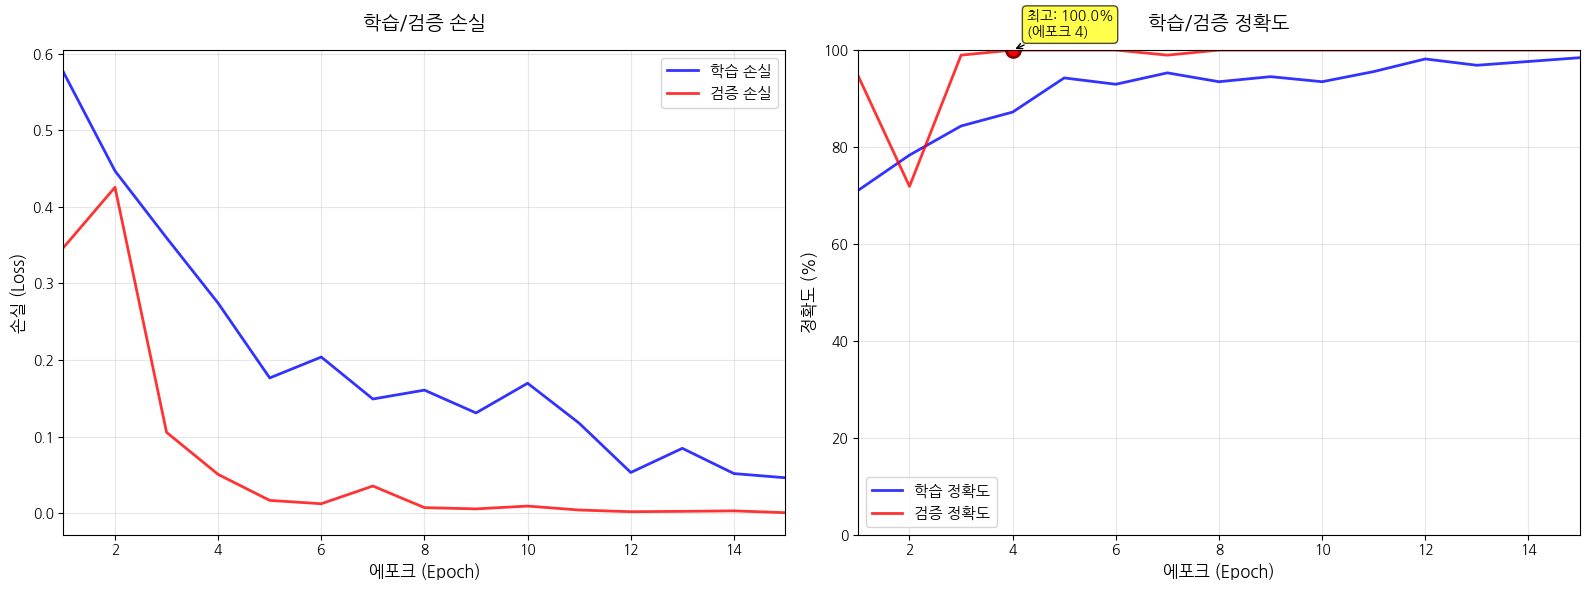


📊 학습 완료 - 최종 결과 요약
🎯 최고 검증 정확도: 100.00% (에포크 4)
📈 최종 학습 정확도: 98.43%
📉 최종 검증 손실: 0.0005
⏱️ 총 학습 에포크: 15개
📊 최근 5에포크 정확도 안정성: 0.00% (낮을수록 안정)
✅ 매우 안정적인 학습!


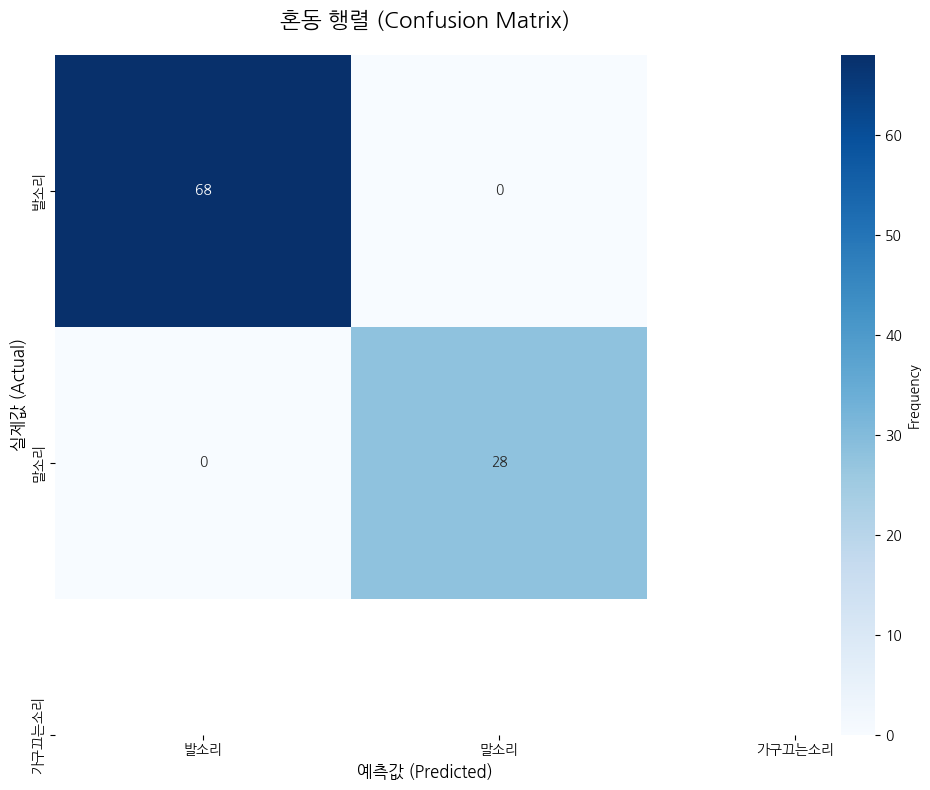

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [21]:
run_sample_training(r"/content/drive/MyDrive/Colab Notebooks/finaldata")

### 절취선

In [33]:


# =============================================================================
# 2. Colab 환경 최적화
# =============================================================================

def setup_colab_environment():
    """Colab 환경 최적화"""
    try:
        mp.set_start_method('spawn', force=True)
    except:
        pass

    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ['OMP_NUM_THREADS'] = '1'

    # 한글 폰트 설정
    setup_korean_font()

    # Google Drive 마운트
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive 마운트 완료")
    except:
        print("⚠️ Google Drive 마운트 실패 또는 이미 마운트됨")

    print("✅ Colab 환경 최적화 완료")

def setup_korean_font():
    """한글 폰트 설정"""
    try:
        # 나눔고딕 폰트 설치
        !apt-get update -qq
        !apt-get install -qq fonts-nanum

        # matplotlib 폰트 설정
        import matplotlib.font_manager as fm
        import matplotlib.pyplot as plt

        # 폰트 캐시 삭제
        !rm -rf ~/.cache/matplotlib

        # 나눔고딕 폰트 경로
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

        if os.path.exists(font_path):
            # 폰트 등록
            fm.fontManager.addfont(font_path)

            # matplotlib 기본 폰트 설정
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

            print("✅ 한글 폰트 설정 완료")
        else:
            # 대체 방법: 구글 폰트 사용
            !wget -O NanumGothic.ttf "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

            # 폰트 등록
            fm.fontManager.addfont('./NanumGothic.ttf')
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False

            print("✅ 한글 폰트 설정 완료 (대체 폰트)")

    except Exception as e:
        print(f"⚠️ 한글 폰트 설정 실패: {e}")
        print("   영어로 표시됩니다.")

        # 영어 레이블로 대체
        plt.rcParams['font.family'] = 'DejaVu Sans'

def test_korean_font():
    """한글 폰트 테스트"""
    print("🔤 한글 폰트 테스트 중...")

    plt.figure(figsize=(10, 6))

    # 테스트 데이터
    classes = ['발소리', '말소리', '가구끄는소리']
    values = [85.2, 92.1, 78.9]
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    # 바 차트 생성
    bars = plt.bar(classes, values, color=colors, alpha=0.8)

    # 제목 및 레이블
    plt.title('한글 폰트 테스트 - 클래스별 정확도', fontsize=16, fontweight='bold')
    plt.xlabel('음성 클래스', fontsize=12)
    plt.ylabel('정확도 (%)', fontsize=12)

    # 값 표시
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.ylim(0, 100)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 폰트 상태 확인
    current_font = plt.rcParams['font.family']
    print(f"✅ 현재 폰트: {current_font}")

    if 'NanumGothic' in current_font or 'Nanum' in str(current_font):
        print("🎉 한글 폰트가 제대로 설정되었습니다!")
    else:
        print("⚠️ 한글 폰트 설정에 문제가 있을 수 있습니다.")
        print("   위 그래프에서 한글이 깨져 보인다면 런타임을 재시작해보세요.")

def memory_cleanup():
    """메모리 정리"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 메모리 정리 완료")

# =============================================================================
# 3. 3클래스 오디오 데이터셋 (발소리, 말소리, 가구끄는소리)
# =============================================================================

class ThreeClassAudioDataset(Dataset):
    def __init__(self, audio_paths, labels, target_sr=16000, max_duration=5.0, augment=False):
        """
        3클래스 오디오 분류 데이터셋

        Args:
            audio_paths: 오디오 파일 경로 리스트
            labels: 레이블 리스트 ['footstep', 'speech', 'furniture']
            target_sr: 목표 샘플링 레이트 (16kHz)
            max_duration: 최대 길이 (5초)
            augment: 데이터 증강 여부
        """
        self.audio_paths = audio_paths
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.max_length = int(target_sr * max_duration)
        self.augment = augment

        # 레이블 매핑
        self.class_names = ['footstep', 'speech', 'furniture']
        self.label_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        self.idx_to_label = {idx: name for name, idx in self.label_to_idx.items()}

        # 레이블 인코딩
        self.labels = [self.label_to_idx[label] for label in labels]

        print(f"📊 데이터셋 정보:")
        print(f"   - 총 샘플 수: {len(self.audio_paths)}")
        print(f"   - 클래스: {self.class_names}")
        for i, class_name in enumerate(self.class_names):
            count = sum(1 for label in self.labels if label == i)
            print(f"   - {class_name}: {count}개")

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        try:
            # 오디오 로드
            audio, sr = librosa.load(
                self.audio_paths[idx],
                sr=self.target_sr,
                duration=self.max_duration
            )

            # 길이 정규화
            audio = self._normalize_length(audio)

            # 데이터 증강
            if self.augment:
                audio = self._augment_audio(audio)

            # 특징 추출 (Mel-spectrogram + MFCC)
            features = self._extract_features(audio)

            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([self.labels[idx]]),
                'path': self.audio_paths[idx]
            }

        except Exception as e:
            print(f"오디오 로딩 오류 {self.audio_paths[idx]}: {e}")
            # 빈 특징 반환
            features = np.zeros((128, 157))  # 기본 특징 크기
            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([0]),
                'path': self.audio_paths[idx]
            }

    def _normalize_length(self, audio):
        """오디오 길이 정규화"""
        if len(audio) > self.max_length:
            # 랜덤 크롭
            start = np.random.randint(0, len(audio) - self.max_length + 1)
            audio = audio[start:start + self.max_length]
        elif len(audio) < self.max_length:
            # 제로 패딩
            audio = np.pad(audio, (0, self.max_length - len(audio)))
        return audio

    def _augment_audio(self, audio):
        """오디오 데이터 증강"""
        # 시간 이동
        if np.random.random() > 0.5:
            shift = np.random.randint(-len(audio)//8, len(audio)//8)
            audio = np.roll(audio, shift)

        # 볼륨 조절
        if np.random.random() > 0.5:
            volume_factor = np.random.uniform(0.7, 1.3)
            audio = audio * volume_factor

        # 가우시안 노이즈 추가
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.005, len(audio))
            audio = audio + noise

        # 피치 시프트 (가끔)
        if np.random.random() > 0.8:
            pitch_shift = np.random.randint(-2, 3)
            if pitch_shift != 0:
                audio = librosa.effects.pitch_shift(audio, sr=self.target_sr, n_steps=pitch_shift)

        return np.clip(audio, -1.0, 1.0)

    def _extract_features(self, audio):
        """특징 추출: Mel-spectrogram + MFCC"""
        # Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.target_sr,
            n_mels=64,
            fmax=8000,
            hop_length=512,
            n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # MFCC
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.target_sr,
            n_mfcc=64,
            hop_length=512,
            n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 고정 크기로 조정
        target_frames = 157  # 5초 * 16000 / 512 ≈ 157
        if features.shape[1] != target_frames:
            features = self._resize_features(features, target_frames)

        return features

    def _resize_features(self, features, target_frames):
        """특징 크기 조정"""
        from scipy.ndimage import zoom
        zoom_factor = target_frames / features.shape[1]
        return zoom(features, (1, zoom_factor))

# =============================================================================
# 4. 3클래스 분류 CNN 모델
# =============================================================================

class ThreeClassAudioCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(ThreeClassAudioCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input: (batch_size, features, time)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =============================================================================
# 5. 학습 매니저
# =============================================================================

class ThreeClassTrainer:
    def __init__(self, model, train_loader, val_loader, device='auto', lr=0.001):
        self.device = torch.device('cuda' if torch.cuda.is_available() and device=='auto' else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # 최적화 설정
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.01
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',  # 정확도 기준
            patience=5,
            factor=0.5,
            verbose=True
        )
        self.criterion = nn.CrossEntropyLoss()

        # 기록
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_acc = 0.0
        self.best_model_state = None

        print(f"🎯 학습 설정:")
        print(f"   - 장치: {self.device}")
        print(f"   - 학습률: {lr}")
        print(f"   - 클래스: 3개 (발소리, 말소리, 가구끄는소리)")

    def train_epoch(self):
        """한 에포크 학습"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="학습")
        for batch in pbar:
            inputs = batch['features'].to(self.device)
            labels = batch['label'].squeeze().to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 진행률 업데이트
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.1f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """검증"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="검증")
            for batch in pbar:
                inputs = batch['features'].to(self.device)
                labels = batch['label'].squeeze().to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 혼동행렬용 데이터 수집
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.1f}%'
                })

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, all_preds, all_labels

    def train(self, num_epochs=30, save_path='best_three_class_model.pth'):
        """전체 학습"""
        print("🚀 3클래스 분류 학습 시작!")
        print("=" * 50)

        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

            # 학습
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # 검증
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            # 스케줄러 업데이트
            self.scheduler.step(val_acc)

            print(f"   학습 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"   검증 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
            print(f"   학습률: {self.optimizer.param_groups[0]['lr']:.6f}")

            # 최고 모델 저장
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': ['footstep', 'speech', 'furniture']
                }, save_path)

                print(f"   ✅ 최고 모델 저장! (검증 정확도: {val_acc:.2f}%)")

                # 클래스별 정확도 출력
                self.print_class_accuracy(val_labels, val_preds)

            # 조기 종료
            if self.optimizer.param_groups[0]['lr'] < 1e-6:
                print("   ⏹️ 학습률이 너무 낮아 학습을 종료합니다.")
                break

            # 메모리 정리
            if epoch % 5 == 0:
                memory_cleanup()

        print(f"\n🎉 학습 완료!")
        print(f"   최고 검증 정확도: {self.best_val_acc:.2f}%")

        # 최고 모델 로드
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        return self.model

    def print_class_accuracy(self, true_labels, pred_labels):
        """클래스별 정확도 출력"""
        class_names = ['발소리', '말소리', '가구끄는소리']

        for i, class_name in enumerate(class_names):
            class_mask = np.array(true_labels) == i
            if class_mask.sum() > 0:
                class_acc = (np.array(pred_labels)[class_mask] == i).sum() / class_mask.sum()
                print(f"     - {class_name}: {class_acc*100:.1f}%")

    def plot_training_history(self):
        """학습 히스토리 시각화 - 한글 지원"""
        # 한글 폰트 설정 확인
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 손실 그래프
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='학습 손실', linewidth=2, alpha=0.8)
        ax1.plot(epochs, self.val_losses, 'r-', label='검증 손실', linewidth=2, alpha=0.8)
        ax1.set_title('학습/검증 손실', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax1.set_ylabel('손실 (Loss)', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, len(self.train_losses))

        # 정확도 그래프
        ax2.plot(epochs, self.train_accs, 'b-', label='학습 정확도', linewidth=2, alpha=0.8)
        ax2.plot(epochs, self.val_accs, 'r-', label='검증 정확도', linewidth=2, alpha=0.8)
        ax2.set_title('학습/검증 정확도', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax2.set_ylabel('정확도 (%)', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        ax2.set_xlim(1, len(self.train_accs))

        # 최고 성능 지점 표시
        best_epoch = np.argmax(self.val_accs) + 1
        best_acc = max(self.val_accs)
        ax2.plot(best_epoch, best_acc, 'ro', markersize=10, markerfacecolor='red',
                markeredgecolor='darkred', markeredgewidth=2)
        ax2.annotate(f'최고: {best_acc:.1f}%\n(에포크 {best_epoch})',
                    xy=(best_epoch, best_acc), xytext=(10, 10),
                    textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()
        plt.show()

        # 상세 결과 출력
        print("\n" + "="*60)
        print("📊 학습 완료 - 최종 결과 요약")
        print("="*60)
        print(f"🎯 최고 검증 정확도: {max(self.val_accs):.2f}% (에포크 {np.argmax(self.val_accs)+1})")
        print(f"📈 최종 학습 정확도: {self.train_accs[-1]:.2f}%")
        print(f"📉 최종 검증 손실: {self.val_losses[-1]:.4f}")
        print(f"⏱️ 총 학습 에포크: {len(self.train_accs)}개")

        # 성능 안정성 분석
        last_5_accs = self.val_accs[-5:] if len(self.val_accs) >= 5 else self.val_accs
        stability = np.std(last_5_accs)
        print(f"📊 최근 5에포크 정확도 안정성: {stability:.2f}% (낮을수록 안정)")

        if stability < 2.0:
            print("✅ 매우 안정적인 학습!")
        elif stability < 5.0:
            print("👍 안정적인 학습")
        else:
            print("⚠️ 불안정한 학습 - 더 많은 에포크나 조기종료 필요")

        print("="*60)

# =============================================================================
# 6. 데이터 처리 및 학습 실행 함수
# =============================================================================

def scan_three_class_data(base_path):
    """3클래스 데이터 스캔 - 강화버전"""
    audio_files = []
    labels = []

    # 지원되는 오디오 확장자 (더 많은 형식 추가)
    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    print(f"📂 {base_path}에서 오디오 파일 스캔 중...")
    print(f"   지원 확장자: {', '.join(extensions)}")

    # 각 클래스별 폴더에서 파일 수집 (더 많은 키워드 추가)
    class_folders = {
        'footstep': ['footstep', 'footsteps', 'foot', 'walk', 'walking', 'step',
                    '발소리', '걸음소리', '발걸음', '보행', 'steps', 'footfall'],
        'speech': ['speech', 'voice', 'talk', 'talking', 'speaking', '말소리', 'speak',
                  '음성', '대화', '목소리', 'vocal', 'utterance', 'conversation'],
        'furniture': ['furniture', 'chair', 'table', 'drag', 'move', '가구', 'scrape',
                     '끄는소리', '이동', '의자', '테이블', 'moving', 'sliding', 'dragging']
    }

    # 모든 하위 디렉토리 탐색
    total_files_found = 0
    processed_dirs = []

    for root, dirs, files in os.walk(base_path):
        folder_name = os.path.basename(root).lower()
        relative_path = os.path.relpath(root, base_path)

        # 오디오 파일이 있는지 확인
        audio_files_in_dir = [f for f in files if any(f.lower().endswith(ext) for ext in extensions)]

        if audio_files_in_dir:
            print(f"   📁 {relative_path} - {len(audio_files_in_dir)}개 오디오 파일 발견")
            total_files_found += len(audio_files_in_dir)

            # 폴더명으로 클래스 판단
            detected_class = None
            for class_name, keywords in class_folders.items():
                if any(keyword in folder_name for keyword in keywords):
                    detected_class = class_name
                    break

            # 클래스가 자동 감지되지 않으면 사용자에게 물어보기
            if detected_class is None:
                print(f"   ❓ '{folder_name}' 폴더의 클래스를 판단할 수 없습니다.")
                print(f"      다음 중 하나를 선택하세요:")
                print(f"      1: footstep (발소리)")
                print(f"      2: speech (말소리)")
                print(f"      3: furniture (가구끄는소리)")
                print(f"      0: skip (건너뛰기)")

                try:
                    choice = input(f"   선택 (1/2/3/0): ").strip()
                    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}
                    if choice in class_mapping:
                        detected_class = class_mapping[choice]
                        print(f"   ✅ '{folder_name}' -> {detected_class}")
                    else:
                        print(f"   ⏩ '{folder_name}' 폴더 건너뜀")
                        continue
                except:
                    print(f"   ⏩ 입력 오류로 '{folder_name}' 폴더 건너뜀")
                    continue
            else:
                print(f"   ✅ {relative_path} -> {detected_class}")

            # 파일 추가
            for file in audio_files_in_dir:
                file_path = os.path.join(root, file)
                audio_files.append(file_path)
                labels.append(detected_class)

            processed_dirs.append((relative_path, detected_class, len(audio_files_in_dir)))

    # 상세 결과 출력
    print(f"\n📊 데이터 스캔 완료:")
    print(f"   - 총 발견된 오디오 파일: {total_files_found}개")
    print(f"   - 실제 사용할 파일: {len(audio_files)}개")
    print(f"   - 처리된 디렉토리: {len(processed_dirs)}개")

    print(f"\n📁 처리된 디렉토리 상세:")
    for dir_path, class_name, count in processed_dirs:
        print(f"   - {dir_path}: {class_name} ({count}개)")

    print(f"\n🏷️ 클래스별 파일 수:")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    if len(audio_files) == 0:
        print("\n❌ 사용 가능한 오디오 파일이 없습니다!")
        print("   다음을 확인해주세요:")
        print("   1. 파일 확장자가 지원되는지 확인")
        print("   2. 폴더 구조가 올바른지 확인")
        print("   3. 파일이 실제로 오디오 파일인지 확인")
        return [], []

    if total_files_found > len(audio_files):
        print(f"\n⚠️ 주의: {total_files_found - len(audio_files)}개 파일이 제외되었습니다.")
        print("   폴더명이 클래스와 매치되지 않아 제외되었을 수 있습니다.")

    return audio_files, labels

def detailed_data_analysis(base_path):
    """데이터 상세 분석"""
    print("🔍 데이터 구조 상세 분석 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    total_files = 0
    total_size = 0
    dir_info = []

    for root, dirs, files in os.walk(base_path):
        audio_files = []
        dir_size = 0

        for file in files:
            file_path = os.path.join(root, file)
            if any(file.lower().endswith(ext) for ext in extensions):
                audio_files.append(file)
                try:
                    file_size = os.path.getsize(file_path)
                    dir_size += file_size
                except:
                    pass

        if audio_files:
            relative_path = os.path.relpath(root, base_path)
            dir_info.append({
                'path': relative_path,
                'files': len(audio_files),
                'size_mb': dir_size / (1024*1024),
                'sample_files': audio_files[:3]  # 처음 3개 파일명
            })

            total_files += len(audio_files)
            total_size += dir_size

    print(f"\n📊 전체 통계:")
    print(f"   - 총 오디오 파일: {total_files}개")
    print(f"   - 총 크기: {total_size/(1024*1024):.1f} MB")
    print(f"   - 오디오가 있는 폴더: {len(dir_info)}개")

    print(f"\n📁 폴더별 상세 정보:")
    for info in sorted(dir_info, key=lambda x: x['files'], reverse=True):
        print(f"   📂 {info['path']}")
        print(f"      - 파일 수: {info['files']}개")
        print(f"      - 크기: {info['size_mb']:.1f} MB")
        print(f"      - 샘플: {', '.join(info['sample_files'])}")
        print()

    return dir_info

def force_scan_all_audio_files(base_path):
    """모든 오디오 파일 강제 스캔 (클래스 구분 없이)"""
    print("🔄 모든 오디오 파일 강제 스캔 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']
    all_files = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_path)
                all_files.append({
                    'path': file_path,
                    'relative': relative_path,
                    'dir': os.path.dirname(relative_path),
                    'filename': file
                })

    print(f"📊 전체 스캔 결과: {len(all_files)}개 오디오 파일 발견")

    # 디렉토리별 그룹화
    from collections import defaultdict
    dir_groups = defaultdict(list)

    for file_info in all_files:
        dir_name = file_info['dir'] if file_info['dir'] else 'root'
        dir_groups[dir_name].append(file_info)

    print(f"\n📁 디렉토리별 파일 수:")
    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"   {dir_name}: {len(file_list)}개")
        # 처음 3개 파일명 표시
        for i, file_info in enumerate(file_list[:3]):
            print(f"      - {file_info['filename']}")
        if len(file_list) > 3:
            print(f"      ... 그 외 {len(file_list)-3}개")
        print()

    return all_files, dir_groups

def run_three_class_training(data_path, num_epochs=30, batch_size=8, test_size=0.2):
    """3클래스 분류 학습 실행"""

    print("🎯 발소리-말소리-가구끄는소리 분류 학습 시작!")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()
    memory_cleanup()

    # 1. 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        print("📁 데이터 구조를 확인해주세요:")
        print("   your_dataset/")
        print("   ├── footstep/")
        print("   ├── speech/")
        print("   └── furniture/")
        return None

    # 2. 학습/검증 분할
    train_files, val_files, train_labels, val_labels = train_test_split(
        audio_files, labels, test_size=test_size, random_state=42, stratify=labels
    )

    print(f"\n📊 데이터 분할:")
    print(f"   - 학습: {len(train_files)}개")
    print(f"   - 검증: {len(val_files)}개")

    # 3. 데이터셋 생성
    train_dataset = ThreeClassAudioDataset(
        train_files, train_labels, augment=True
    )
    val_dataset = ThreeClassAudioDataset(
        val_files, val_labels, augment=False
    )

    # 4. 데이터 로더 생성
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )

    # 5. 모델 생성
    model = ThreeClassAudioCNN(num_classes=3)
    print(f"🤖 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    # 6. 학습 실행
    trainer = ThreeClassTrainer(model, train_loader, val_loader)
    trained_model = trainer.train(num_epochs=num_epochs)

    # 7. 결과 시각화
    trainer.plot_training_history()

    # 8. 혼동행렬 생성
    plot_confusion_matrix(trained_model, val_loader)

    return trained_model, trainer

def plot_confusion_matrix(model, val_loader):
    """혼동행렬 시각화 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['발소리', '말소리', '가구끄는소리']

    # 시각화
    plt.figure(figsize=(10, 8))

    # 한글 폰트 확인 및 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        # 폰트 설정이 안된 경우 영어로 대체
        class_names = ['Footstep', 'Speech', 'Furniture']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Frequency'})
    plt.title('혼동 행렬 (Confusion Matrix)', fontsize=16, pad=20)
    plt.xlabel('예측값 (Predicted)', fontsize=12)
    plt.ylabel('실제값 (Actual)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 분류 리포트
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names, output_dict=True)

    print("\n📊 상세 분류 결과:")
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        print(f"   {class_name}:")
        print(f"     - 정밀도(Precision): {precision:.3f}")
        print(f"     - 재현율(Recall): {recall:.3f}")
        print(f"     - F1-Score: {f1:.3f}")
        print(f"     - 샘플 수: {support}")

    print(f"\n   전체 정확도: {report['accuracy']:.3f}")
    print(f"   매크로 평균 F1: {report['macro avg']['f1-score']:.3f}")

    # 클래스별 정확도 바 차트
    plt.figure(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        if cm[i].sum() > 0:
            acc = cm[i, i] / cm[i].sum()
            class_accuracies.append(acc)
        else:
            class_accuracies.append(0)

    colors = ['#ff7f7f', '#7f7fff', '#7fff7f']
    bars = plt.bar(class_names, class_accuracies, color=colors, alpha=0.8)
    plt.title('클래스별 정확도', fontsize=16, pad=20)
    plt.xlabel('클래스', fontsize=12)
    plt.ylabel('정확도', fontsize=12)
    plt.ylim(0, 1.1)

    # 각 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. 실시간 예측 함수 (완성)
# =============================================================================

def predict_audio_file(model_path, audio_file_path):
    """오디오 파일 예측 - 완성 버전"""
    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    class_names = ['발소리', '말소리', '가구끄는소리']
    class_names_eng = ['footstep', 'speech', 'furniture']

    try:
        # 오디오 로드 및 전처리
        audio, sr = librosa.load(audio_file_path, sr=16000, duration=5.0)

        # 길이 정규화
        max_length = 16000 * 5
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        else:
            audio = audio[:max_length]

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        mfcc = librosa.feature.mfcc(
            y=audio, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 크기 조정
        target_frames = 157
        if features.shape[1] != target_frames:
            from scipy.ndimage import zoom
            zoom_factor = target_frames / features.shape[1]
            features = zoom(features, (1, zoom_factor))

        # 예측
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).unsqueeze(0)  # 배치 차원 추가
            outputs = model(features_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # 결과 반환
        result = {
            'predicted_class': class_names[predicted_class],
            'predicted_class_eng': class_names_eng[predicted_class],
            'confidence': confidence,
            'probabilities': {
                class_names[i]: prob.item()
                for i, prob in enumerate(probabilities[0])
            }
        }

        # 시각화
        visualize_prediction_result(audio, sr, features, result)

        return result

    except Exception as e:
        print(f"❌ 예측 오류: {str(e)}")
        return None

def visualize_prediction_result(audio, sr, features, result):
    """예측 결과 시각화"""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('오디오 파형', '특징 맵 (Mel-spec + MFCC)', '예측 확률', '주파수 스펙트럼'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "bar"}, {"secondary_y": False}]]
    )

    # 1. 오디오 파형
    time = np.linspace(0, len(audio)/sr, len(audio))
    fig.add_trace(
        go.Scatter(x=time, y=audio, name='오디오 신호', line=dict(color='blue')),
        row=1, col=1
    )

    # 2. 특징 맵
    fig.add_trace(
        go.Heatmap(z=features, colorscale='Viridis', name='특징 맵'),
        row=1, col=2
    )

    # 3. 예측 확률
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['red' if cls == result['predicted_class'] else 'lightblue' for cls in classes]

    fig.add_trace(
        go.Bar(x=classes, y=probs, name='예측 확률',
               marker=dict(color=colors)),
        row=2, col=1
    )

    # 4. 주파수 스펙트럼
    freqs = np.fft.fftfreq(len(audio), 1/sr)[:len(audio)//2]
    fft_vals = np.abs(np.fft.fft(audio))[:len(audio)//2]

    fig.add_trace(
        go.Scatter(x=freqs, y=fft_vals, name='주파수 스펙트럼', line=dict(color='green')),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        title_text=f"예측 결과: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})"
    )
    fig.show()

    # 결과 출력
    print(f"\n🎯 예측 결과:")
    print(f"   - 예측 클래스: {result['predicted_class']}")
    print(f"   - 신뢰도: {result['confidence']:.3f}")
    print(f"\n📊 모든 클래스 확률:")
    for class_name, prob in result['probabilities'].items():
        print(f"   - {class_name}: {prob:.3f}")

# =============================================================================
# 8. 샘플 데이터 생성기
# =============================================================================

def generate_sample_audio_data(output_dir='sample_data', samples_per_class=20):
    """테스트용 샘플 오디오 데이터 생성"""
    print("🎼 샘플 오디오 데이터 생성 중...")

    os.makedirs(output_dir, exist_ok=True)

    # 각 클래스별 폴더 생성
    classes = ['footstep', 'speech', 'furniture']
    for class_name in classes:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

    sr = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sr * duration))

    for i in range(samples_per_class):
        # 발소리 시뮬레이션 (짧은 충격음들)
        footstep = np.zeros_like(t)
        for step in range(4):  # 4번의 발걸음
            start_idx = int(step * len(t) / 4) + np.random.randint(-1000, 1000)
            if 0 <= start_idx < len(t) - 1000:
                # 충격음 시뮬레이션
                impact = np.exp(-np.arange(1000) * 0.01) * np.sin(2 * np.pi * np.random.uniform(80, 200) * np.arange(1000) / sr)
                footstep[start_idx:start_idx+1000] += impact * np.random.uniform(0.3, 0.8)

        # 노이즈 추가
        footstep += np.random.normal(0, 0.02, len(footstep))
        footstep = np.clip(footstep, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'footstep', f'footstep_{i:03d}.wav'), footstep, sr)

        # 말소리 시뮬레이션 (여러 주파수 성분)
        speech = np.zeros_like(t)
        # 기본 음성 주파수들 (100-300Hz)
        for freq in [120, 180, 240, 300]:
            amplitude = np.random.uniform(0.1, 0.3)
            speech += amplitude * np.sin(2 * np.pi * freq * t)

        # 포먼트 시뮬레이션 (800-2000Hz)
        for freq in [800, 1200, 1600, 2000]:
            amplitude = np.random.uniform(0.05, 0.15)
            modulation = 1 + 0.5 * np.sin(2 * np.pi * np.random.uniform(5, 15) * t)
            speech += amplitude * np.sin(2 * np.pi * freq * t) * modulation

        # 노이즈 및 변조
        speech *= (1 + 0.3 * np.sin(2 * np.pi * np.random.uniform(1, 5) * t))
        speech += np.random.normal(0, 0.02, len(speech))
        speech = np.clip(speech, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'speech', f'speech_{i:03d}.wav'), speech, sr)

        # 가구끄는소리 시뮬레이션 (마찰음)
        furniture = np.zeros_like(t)

        # 마찰음 기본 주파수 (낮은 주파수 + 고주파 노이즈)
        base_freq = np.random.uniform(20, 80)
        furniture += 0.4 * np.sin(2 * np.pi * base_freq * t)

        # 고주파 마찰음 (1-4kHz)
        high_freq_noise = np.random.normal(0, 0.1, len(t))
        butter_b, butter_a = scipy.signal.butter(4, [1000, 4000], btype='band', fs=sr)
        high_freq_filtered = scipy.signal.filtfilt(butter_b, butter_a, high_freq_noise)
        furniture += 0.3 * high_freq_filtered

        # 불규칙한 진동 패턴
        irregular_pattern = np.random.uniform(0.5, 1.5, 100)
        furniture *= np.interp(t, np.linspace(0, duration, 100), irregular_pattern)

        furniture = np.clip(furniture, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'furniture', f'furniture_{i:03d}.wav'), furniture, sr)

    print(f"✅ 샘플 데이터 생성 완료!")
    print(f"   - 경로: {output_dir}")
    print(f"   - 클래스별 {samples_per_class}개씩 총 {samples_per_class * 3}개 파일")

    return output_dir

# =============================================================================
# 9. 실시간 녹음 및 예측
# =============================================================================

def record_and_predict(model_path, duration=5):
    """실시간 녹음 및 예측"""
    print(f"🎤 {duration}초간 녹음을 시작합니다...")
    print("   마이크에 대고 소리를 내세요!")

    try:
        # JavaScript를 사용한 녹음 (Colab 환경)
        from google.colab import output
        from base64 import b64decode

        RECORD = """
        const sleep = time => new Promise(resolve => setTimeout(resolve, time))
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader()
          reader.onloadend = e => resolve(e.srcElement.result)
          reader.readAsDataURL(blob)
        })

        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({ audio: true })
          recorder = new MediaRecorder(stream)
          chunks = []
          recorder.ondataavailable = e => chunks.push(e.data)
          recorder.onstop = async ()=>{
            blob = new Blob(chunks, { type: 'audio/wav' })
            text = await b2text(blob)
            resolve(text)
          }
          recorder.start()
          await sleep(time)
          recorder.stop()
        })
        """

        display(HTML(f'''
        <script>
        {RECORD}
        </script>
        <button onclick="record({duration * 1000}).then(audio => {{
            google.colab.kernel.invokeFunction('save_audio', [audio], {{}})
        }})">🎤 녹음 시작 ({duration}초)</button>
        '''))

        print("   위의 녹음 버튼을 클릭해주세요!")

    except Exception as e:
        print(f"❌ 녹음 기능 오류: {e}")
        print("   대신 파일 업로드를 사용해주세요.")

def save_audio(audio_data):
    """녹음된 오디오 저장 및 예측"""
    try:
        # Base64 디코딩
        audio_data = audio_data.split(',')[1]
        audio_bytes = b64decode(audio_data)

        # 파일 저장
        with open('recorded_audio.wav', 'wb') as f:
            f.write(audio_bytes)

        print("✅ 녹음 완료! 예측 중...")

        # 예측 실행 (모델이 있다면)
        if os.path.exists('best_three_class_model.pth'):
            result = predict_audio_file('best_three_class_model.pth', 'recorded_audio.wav')
            if result:
                print_prediction_result(result)
        else:
            print("⚠️ 학습된 모델이 없습니다. 먼저 학습을 실행해주세요.")

    except Exception as e:
        print(f"❌ 오디오 저장 오류: {e}")

def print_prediction_result(result):
    """예측 결과 출력"""
    print("\n" + "="*50)
    print("🎯 실시간 예측 결과")
    print("="*50)
    print(f"🔍 예측 클래스: {result['predicted_class']}")
    print(f"📊 신뢰도: {result['confidence']:.1%}")
    print("\n📈 각 클래스별 확률:")

    for class_name, prob in result['probabilities'].items():
        bar = "█" * int(prob * 20)
        print(f"   {class_name:12}: {prob:.3f} |{bar}")

# =============================================================================
# 10. 업로드 파일 분석
# =============================================================================

def analyze_uploaded_file():
    """파일 업로드 및 분석"""
    print("📁 오디오 파일을 업로드해주세요...")
    uploaded = files.upload()

    if uploaded:
        file_name = list(uploaded.keys())[0]
        print(f"✅ 파일 '{file_name}' 업로드 완료!")

        # 모델이 있는지 확인
        if os.path.exists('best_three_class_model.pth'):
            result = predict_audio_file('best_three_class_model.pth', file_name)
            if result:
                print_prediction_result(result)

                # 오디오 재생
                audio, sr = librosa.load(file_name, sr=16000)
                display(Audio(audio, rate=sr))

                return result
        else:
            print("⚠️ 학습된 모델이 없습니다.")
            print("   먼저 샘플 데이터로 학습하거나 실제 데이터로 학습해주세요.")
            return None
    else:
        print("❌ 파일이 업로드되지 않았습니다.")
        return None

# =============================================================================
# 11. 데모 및 테스트 함수들
# =============================================================================

def debug_data_loading(data_path):
    """데이터 로딩 과정 디버깅"""
    print("🐛 데이터 로딩 과정 디버깅 중...")

    # 1. 전체 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)
    print(f"1️⃣ 전체 스캔: {len(all_files)}개 파일 발견")

    # 2. 클래스 매칭 테스트
    audio_files, labels = scan_three_class_data(data_path)
    print(f"2️⃣ 클래스 매칭: {len(audio_files)}개 파일 매칭")

    # 3. 누락된 파일들 분석
    matched_paths = set(audio_files)
    all_paths = set([f['path'] for f in all_files])
    missing_files = all_paths - matched_paths

    if missing_files:
        print(f"\n❗ 누락된 파일들 ({len(missing_files)}개):")
        missing_by_dir = defaultdict(list)
        for missing_path in list(missing_files)[:20]:  # 처음 20개만 표시
            dir_name = os.path.dirname(os.path.relpath(missing_path, data_path))
            missing_by_dir[dir_name].append(os.path.basename(missing_path))

        for dir_name, files in missing_by_dir.items():
            print(f"   📁 {dir_name}: {len(files)}개")
            for file in files[:3]:
                print(f"      - {file}")
            if len(files) > 3:
                print(f"      ... 그 외 {len(files)-3}개")

    # 4. 실제 로딩 테스트
    print(f"\n🧪 실제 오디오 로딩 테스트 (처음 10개 파일)...")
    loading_errors = 0

    for i, file_path in enumerate(audio_files[:10]):
        try:
            audio, sr = librosa.load(file_path, sr=16000, duration=1.0)  # 1초만 테스트
            duration = len(audio) / sr
            print(f"   ✅ {i+1}: {os.path.basename(file_path)} ({duration:.1f}초, {sr}Hz)")
        except Exception as e:
            print(f"   ❌ {i+1}: {os.path.basename(file_path)} - {str(e)}")
            loading_errors += 1

    if loading_errors > 0:
        print(f"\n⚠️ {loading_errors}개 파일에서 로딩 오류 발생")
        print("   일부 파일이 손상되었거나 지원되지 않는 형식일 수 있습니다.")

    return {
        'total_found': len(all_files),
        'matched': len(audio_files),
        'missing': len(missing_files),
        'loading_errors': loading_errors,
        'dir_groups': dir_groups
    }

def create_manual_dataset(data_path):
    """수동으로 데이터셋 생성 (모든 파일 사용)"""
    print("🛠️ 수동 데이터셋 생성 중...")

    # 모든 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)

    audio_files = []
    labels = []

    print(f"\n각 디렉토리의 클래스를 수동으로 지정해주세요:")
    print("1: footstep (발소리)")
    print("2: speech (말소리)")
    print("3: furniture (가구끄는소리)")
    print("0: skip (제외)")

    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}

    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"\n📁 {dir_name} ({len(file_list)}개 파일)")
        print(f"   샘플 파일: {', '.join([f['filename'] for f in file_list[:3]])}")

        while True:
            try:
                choice = input(f"   클래스 선택 (1/2/3/0): ").strip()
                if choice == '0':
                    print(f"   ⏩ {dir_name} 폴더 제외")
                    break
                elif choice in class_mapping:
                    selected_class = class_mapping[choice]
                    print(f"   ✅ {dir_name} -> {selected_class}")

                    # 파일들 추가
                    for file_info in file_list:
                        audio_files.append(file_info['path'])
                        labels.append(selected_class)
                    break
                else:
                    print("   잘못된 선택입니다. 다시 입력해주세요.")
            except KeyboardInterrupt:
                print("\n   작업이 중단되었습니다.")
                return [], []

    print(f"\n📊 수동 데이터셋 생성 완료:")
    print(f"   - 총 파일 수: {len(audio_files)}개")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    return audio_files, labels
    """샘플 데이터 또는 실제 데이터로 학습 실행"""

    if data_path is None:
        print("🎼 샘플 데이터를 생성하고 학습을 시작합니다...")
        # 샘플 데이터 생성
        sample_dir = generate_sample_audio_data('sample_data', samples_per_class=30)
        data_path = sample_dir
        print("✅ 샘플 데이터 생성 완료!")
    else:
        print(f"📁 실제 데이터를 사용합니다: {data_path}")

    # 학습 실행
    print("🚀 학습을 시작합니다...")
    model, trainer = run_three_class_training(
        data_path=data_path,
        num_epochs=num_epochs,
        batch_size=batch_size,
        test_size=0.2
    )

    print("✅ 학습 완료! 이제 테스트해보세요.")
    return model, trainer

def test_model_with_samples():
    """샘플로 모델 테스트"""
    if not os.path.exists('best_three_class_model.pth'):
        print("❌ 학습된 모델이 없습니다!")
        print("   run_sample_training() 먼저 실행해주세요.")
        return

    if not os.path.exists('sample_data'):
        print("❌ 샘플 데이터가 없습니다!")
        return

    print("🧪 샘플 파일들로 모델 테스트 중...")

    # 각 클래스에서 랜덤 파일 선택
    classes = ['footstep', 'speech', 'furniture']

    for class_name in classes:
        class_dir = os.path.join('sample_data', class_name)
        if os.path.exists(class_dir):
            files_list = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
            if files_list:
                test_file = os.path.join(class_dir, random.choice(files_list))
                print(f"\n🎵 테스트 중: {class_name} 클래스")
                print(f"   파일: {test_file}")

                result = predict_audio_file('best_three_class_model.pth', test_file)
                if result:
                    correct = "✅" if result['predicted_class_eng'] == class_name else "❌"
                    print(f"   {correct} 예측: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})")

                    # 오디오 재생
                    audio, sr = librosa.load(test_file, sr=16000)
                    display(Audio(audio, rate=sr))

def demo_realtime_features():
    """실시간 특징 추출 데모"""
    print("🔄 실시간 특징 추출 데모")

    # 짧은 테스트 신호 생성
    sr = 16000
    duration = 2.0
    t = np.linspace(0, duration, int(sr * duration))

    # 다양한 신호 생성
    signals = {
        '발소리 시뮬레이션': create_footstep_signal(t, sr),
        '말소리 시뮬레이션': create_speech_signal(t, sr),
        '가구 시뮬레이션': create_furniture_signal(t, sr)
    }

    for name, signal in signals.items():
        print(f"\n🎵 {name} 특징 추출 중...")

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=64)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # 원본 신호
        axes[0].plot(t, signal)
        axes[0].set_title(f'{name} - 시간 도메인')
        axes[0].set_xlabel('시간 (초)')
        axes[0].set_ylabel('진폭')

        # Mel-spectrogram
        librosa.display.specshow(librosa.power_to_db(mel_spec), sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
        axes[1].set_title('Mel-spectrogram')

        # MFCC
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[2])
        axes[2].set_title('MFCC')

        plt.tight_layout()
        plt.show()

        # 오디오 재생
        display(Audio(signal, rate=sr))

def create_footstep_signal(t, sr):
    """발소리 신호 생성"""
    signal = np.zeros_like(t)
    step_times = [0.3, 0.9, 1.5]  # 발걸음 시간

    for step_time in step_times:
        start_idx = int(step_time * sr)
        if start_idx < len(signal) - 2000:
            # 충격음 (감쇠하는 저주파)
            impact_t = np.arange(2000) / sr
            impact = np.exp(-impact_t * 5) * np.sin(2 * np.pi * 80 * impact_t)
            signal[start_idx:start_idx+2000] += impact * 0.8

    return signal

def create_speech_signal(t, sr):
    """말소리 신호 생성"""
    # 기본 주파수 (피치)
    f0 = 150  # Hz
    speech = 0.3 * np.sin(2 * np.pi * f0 * t)

    # 포먼트 추가
    formants = [800, 1200, 2400]
    for formant in formants:
        speech += 0.1 * np.sin(2 * np.pi * formant * t)

    # 진폭 변조 (말하는 리듬)
    modulation = 1 + 0.5 * np.sin(2 * np.pi * 3 * t)
    speech *= modulation

    return speech

def create_furniture_signal(t, sr):
    """가구끄는소리 신호 생성"""
    # 마찰음 (광대역 노이즈를 필터링)
    noise = np.random.normal(0, 1, len(t))

    # 로우패스 필터 (마찰음 특성)
    butter_b, butter_a = scipy.signal.butter(4, 500, fs=sr)
    filtered = scipy.signal.filtfilt(butter_b, butter_a, noise)

    # 불규칙한 진폭
    amplitude_env = np.random.uniform(0.2, 0.8, 50)
    amplitude = np.interp(t, np.linspace(0, t[-1], 50), amplitude_env)

    return filtered * amplitude * 0.5

# =============================================================================
# 12. 사용 가이드 및 실행 함수
# =============================================================================

def show_complete_usage_guide():
    """완전한 사용 가이드"""
    print("""
    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    ================================================================

    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원

    🚀 빠른 시작:

    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인

    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트

    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)

        model, trainer = run_sample_training('/path/to/your_data')

    3️⃣ 파일 업로드하여 예측:
        analyze_uploaded_file()

    4️⃣ 실시간 녹음 예측:
        record_and_predict('best_three_class_model.pth')

    5️⃣ 특징 추출 데모:
        demo_realtime_features()

    6️⃣ 모델 성능 상세 분석:
        analyze_model_performance(model, val_loader)

    📊 모델 성능:
    - 입력: 5초 오디오 (16kHz)
    - 특징: Mel-spectrogram (64) + MFCC (64) = 128차원
    - 구조: CNN (4블록) + Global Average Pooling
    - 출력: 3클래스 확률 분포

    🔤 한글 폰트 문제 해결:
    - 그래프에서 한글이 깨진다면: test_korean_font() 실행
    - 여전히 문제가 있다면: 런타임 재시작 후 다시 실행

    💡 팁:
    - GPU 사용 시 batch_size를 16으로 증가 가능
    - 데이터가 부족하면 augmentation 강화
    - 과적합 시 dropout_rate 증가

    ⚡ 지금 시작하기:
        test_korean_font()     # 한글 폰트 확인
        run_sample_training()  # 샘플 학습
    """)

# 컴포넌트별 등록 (Colab 전용)
try:
    from google.colab import output
    output.register_callback('save_audio', save_audio)
except:
    pass

# =============================================================================
# 13. 고급 분석 도구
# =============================================================================

def analyze_model_performance(model, val_loader):
    """모델 성능 상세 분석 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []
    all_confidences = []

    print("🔍 모델 성능 상세 분석 중...")

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="분석"):
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())

    # 성능 메트릭 계산
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # 신뢰도 분석
    correct_mask = np.array(all_preds) == np.array(all_labels)
    correct_confidences = np.array(all_confidences)[correct_mask]
    incorrect_confidences = np.array(all_confidences)[~correct_mask]

    # 결과 출력
    print(f"\n📊 전체 성능 메트릭:")
    print(f"   - 정확도: {accuracy:.3f}")
    print(f"   - 정밀도: {precision:.3f}")
    print(f"   - 재현율: {recall:.3f}")
    print(f"   - F1 점수: {f1:.3f}")
    print(f"\n🎯 신뢰도 분석:")
    print(f"   - 올바른 예측 평균 신뢰도: {correct_confidences.mean():.3f}")
    print(f"   - 잘못된 예측 평균 신뢰도: {incorrect_confidences.mean():.3f}")

    # 한글 폰트 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
    except:
        pass

    # 신뢰도 분포 시각화
    plt.figure(figsize=(12, 8))

    # 서브플롯 1: 신뢰도 히스토그램
    plt.subplot(2, 2, 1)
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='올바른 예측', color='green', density=True)
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='잘못된 예측', color='red', density=True)
    plt.xlabel('신뢰도')
    plt.ylabel('밀도')
    plt.title('예측 신뢰도 분포')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 박스플롯
    plt.subplot(2, 2, 2)
    data_to_plot = [correct_confidences, incorrect_confidences]
    box = plt.boxplot(data_to_plot, labels=['올바른 예측', '잘못된 예측'], patch_artist=True)
    box['boxes'][0].set_facecolor('lightgreen')
    box['boxes'][1].set_facecolor('lightcoral')
    plt.ylabel('신뢰도')
    plt.title('신뢰도 박스플롯')
    plt.grid(True, alpha=0.3)

    # 서브플롯 3: 클래스별 성능
    plt.subplot(2, 2, 3)
    class_names = ['발소리', '말소리', '가구끄는소리']
    class_f1_scores = []

    for i in range(3):
        class_mask = np.array(all_labels) == i
        if class_mask.sum() > 0:
            class_preds = np.array(all_preds)[class_mask]
            class_labels = np.array(all_labels)[class_mask]
            class_f1 = f1_score(class_labels, class_preds, average='binary', pos_label=i, zero_division=0)
            class_f1_scores.append(class_f1)
        else:
            class_f1_scores.append(0)

    colors = ['#ff9999', '#66b3ff', '#99ff99']
    bars = plt.bar(class_names, class_f1_scores, color=colors, alpha=0.8)
    plt.ylabel('F1 점수')
    plt.title('클래스별 F1 점수')
    plt.ylim(0, 1.1)

    # 각 막대 위에 값 표시
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom')

    # 서브플롯 4: 신뢰도 vs 정확도
    plt.subplot(2, 2, 4)
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins) - 1):
        bin_mask = ((np.array(all_confidences) >= confidence_bins[i]) &
                   (np.array(all_confidences) < confidence_bins[i+1]))

        if bin_mask.sum() > 0:
            bin_accuracy = (np.array(all_preds)[bin_mask] == np.array(all_labels)[bin_mask]).mean()
            bin_accuracies.append(bin_accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

    if bin_centers:
        plt.plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=6)
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='완벽한 보정')
        plt.xlabel('신뢰도')
        plt.ylabel('정확도')
        plt.title('신뢰도 보정 곡선')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 상세 통계
    print(f"\n📈 상세 통계:")
    print(f"   - 총 예측 샘플: {len(all_labels)}개")
    print(f"   - 올바른 예측: {correct_mask.sum()}개 ({correct_mask.mean()*100:.1f}%)")
    print(f"   - 잘못된 예측: {(~correct_mask).sum()}개 ({(~correct_mask).mean()*100:.1f}%)")
    print(f"   - 평균 신뢰도: {np.mean(all_confidences):.3f}")
    print(f"   - 신뢰도 표준편차: {np.std(all_confidences):.3f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct_confidences': correct_confidences,
        'incorrect_confidences': incorrect_confidences,
        'class_f1_scores': class_f1_scores
    }

def batch_predict_directory(model_path, test_dir):
    """디렉토리 내 모든 파일 일괄 예측"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print(f"📁 {test_dir} 내 모든 오디오 파일 예측 중...")

    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []

    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    if not audio_files:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        return

    results = []

    for audio_file in tqdm(audio_files, desc="예측"):
        result = predict_audio_file(model_path, audio_file)
        if result:
            results.append({
                'file': os.path.basename(audio_file),
                'predicted_class': result['predicted_class'],
                'confidence': result['confidence'],
                'path': audio_file
            })

    # 결과를 DataFrame으로 정리
    df = pd.DataFrame(results)

    print(f"\n📊 일괄 예측 결과:")
    print(df.groupby('predicted_class').agg({
        'confidence': ['count', 'mean', 'min', 'max'],
        'file': 'count'
    }).round(3))

    return df

# =============================================================================
# 14. 메인 실행 부분
# =============================================================================

def main():
    """메인 실행 함수"""
    print("🎵 발소리-말소리-가구끄는소리 분류 AI 모델")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()

    # 사용 가이드 출력
    show_complete_usage_guide()

    print("\n🎯 다음 중 하나를 선택하세요:")
    print("1. test_korean_font()        # 한글 폰트 테스트")
    print("2. run_sample_training()     # 샘플 데이터로 학습")
    print("3. analyze_uploaded_file()   # 파일 업로드 분석")
    print("4. demo_realtime_features()  # 특징 추출 데모")
    print("5. test_model_with_samples() # 샘플로 테스트")

# 자동 실행
if __name__ == "__main__":
    main()

# =============================================================================
# 16. 오디오 데이터 시각화 및 분석 도구
# =============================================================================

def visualize_audio_prediction(model_path, audio_file_path, save_image=False, show_features=True):
    """개별 오디오 파일의 예측 과정을 상세히 시각화"""

    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return None

    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    class_names_kr = ['발소리', '말소리', '가구끄는소리']
    class_names_en = ['footstep', 'speech', 'furniture']
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    try:
        # 오디오 로드
        audio, sr = librosa.load(audio_file_path, sr=16000, duration=5.0)
        filename = os.path.basename(audio_file_path)

        # 길이 정규화
        max_length = 16000 * 5
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        else:
            audio = audio[:max_length]

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        mfcc = librosa.feature.mfcc(
            y=audio, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])

        # 크기 조정
        target_frames = 157
        if features.shape[1] != target_frames:
            from scipy.ndimage import zoom
            zoom_factor = target_frames / features.shape[1]
            features = zoom(features, (1, zoom_factor))

        # 예측
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).unsqueeze(0)
            outputs = model(features_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # 시각화 생성
        if show_features:
            fig = plt.figure(figsize=(20, 16))
            gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        else:
            fig = plt.figure(figsize=(16, 12))
            gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # 한글 폰트 설정
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        # 1. 오디오 파형
        ax1 = fig.add_subplot(gs[0, :])
        time = np.linspace(0, len(audio)/sr, len(audio))
        ax1.plot(time, audio, color='blue', alpha=0.8, linewidth=0.5)
        ax1.set_title(f'🎵 원본 오디오 파형: {filename}', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('시간 (초)')
        ax1.set_ylabel('진폭')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 5)

        # RMS와 피크값 표시
        rms = np.sqrt(np.mean(audio**2))
        peak = np.max(np.abs(audio))
        ax1.text(0.02, 0.95, f'RMS: {rms:.4f}\nPeak: {peak:.4f}',
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. 스펙트로그램 (Mel-spectrogram)
        ax2 = fig.add_subplot(gs[1, 0])
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel',
                                ax=ax2, cmap='viridis')
        ax2.set_title('🎼 Mel-Spectrogram', fontsize=12, fontweight='bold')
        ax2.set_xlabel('시간 (초)')
        ax2.set_ylabel('Mel 주파수')

        # 3. MFCC
        ax3 = fig.add_subplot(gs[1, 1])
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax3, cmap='coolwarm')
        ax3.set_title('🔢 MFCC 계수', fontsize=12, fontweight='bold')
        ax3.set_xlabel('시간 (초)')
        ax3.set_ylabel('MFCC 계수')

        # 4. 결합된 특징 맵
        ax4 = fig.add_subplot(gs[1, 2])
        im = ax4.imshow(features, aspect='auto', cmap='plasma', origin='lower')
        ax4.set_title('🧠 CNN 입력 특징\n(Mel-spec + MFCC)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('시간 프레임')
        ax4.set_ylabel('특징 차원')
        plt.colorbar(im, ax=ax4, shrink=0.8)

        # 5. 예측 확률
        ax5 = fig.add_subplot(gs[2, 0])
        probs = [prob.item() for prob in probabilities[0]]
        bars = ax5.bar(class_names_kr, probs, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax5.set_title('🎯 클래스별 예측 확률', fontsize=12, fontweight='bold')
        ax5.set_ylabel('확률')
        ax5.set_ylim(0, 1.1)

        # 최고 확률 막대 강조
        max_idx = np.argmax(probs)
        bars[max_idx].set_color('red')
        bars[max_idx].set_alpha(1.0)

        # 확률 값 표시
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{prob:.1%}', ha='center', va='bottom',
                    fontweight='bold' if i == max_idx else 'normal')

        # 6. 주파수 스펙트럼
        ax6 = fig.add_subplot(gs[2, 1])
        fft = np.fft.fft(audio)
        freqs = np.fft.fftfreq(len(audio), 1/sr)
        magnitude = np.abs(fft)

        # 양의 주파수만 표시
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]

        ax6.plot(positive_freqs, positive_magnitude, color='green', alpha=0.7)
        ax6.set_title('🌊 주파수 스펙트럼', fontsize=12, fontweight='bold')
        ax6.set_xlabel('주파수 (Hz)')
        ax6.set_ylabel('크기')
        ax6.set_xlim(0, 4000)  # 4kHz까지만 표시
        ax6.grid(True, alpha=0.3)

        # 주요 주파수 성분 찾기
        dominant_freq_idx = np.argmax(positive_magnitude[1:]) + 1  # DC 제외
        dominant_freq = positive_freqs[dominant_freq_idx]
        ax6.axvline(dominant_freq, color='red', linestyle='--', alpha=0.8)
        ax6.text(dominant_freq, max(positive_magnitude)*0.8,
                f'주요 주파수\n{dominant_freq:.0f} Hz',
                ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

        # 7. 결과 요약
        ax7 = fig.add_subplot(gs[2, 2])
        ax7.axis('off')

        result_text = f"""
🎯 예측 결과

📁 파일: {filename}
🏷️ 예측 클래스: {class_names_kr[predicted_class]}
📊 신뢰도: {confidence:.1%}

📈 상세 확률:
• 발소리: {probs[0]:.1%}
• 말소리: {probs[1]:.1%}
• 가구끄는소리: {probs[2]:.1%}

🔊 오디오 특성:
• 길이: {len(audio)/sr:.1f}초
• 샘플링 레이트: {sr:,} Hz
• RMS 값: {rms:.4f}
• 피크 값: {peak:.4f}
• 주요 주파수: {dominant_freq:.0f} Hz
        """

        ax7.text(0.05, 0.95, result_text, transform=ax7.transAxes,
                verticalalignment='top', fontsize=11,
                bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))

        # 추가 특징 분석 (선택적)
        if show_features:
            # 8. 시간별 에너지 변화
            ax8 = fig.add_subplot(gs[3, 0])
            hop_length = 512
            frame_length = 2048
            energy = librosa.feature.rms(y=audio, hop_length=hop_length, frame_length=frame_length)[0]
            frames = range(len(energy))
            times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

            ax8.plot(times, energy, color='purple', linewidth=2)
            ax8.set_title('⚡ 시간별 에너지 변화', fontsize=12, fontweight='bold')
            ax8.set_xlabel('시간 (초)')
            ax8.set_ylabel('RMS 에너지')
            ax8.grid(True, alpha=0.3)

            # 9. 영교차율 (Zero Crossing Rate)
            ax9 = fig.add_subplot(gs[3, 1])
            zcr = librosa.feature.zero_crossing_rate(audio, hop_length=hop_length)[0]
            ax9.plot(times, zcr, color='orange', linewidth=2)
            ax9.set_title('🔄 영교차율 (ZCR)', fontsize=12, fontweight='bold')
            ax9.set_xlabel('시간 (초)')
            ax9.set_ylabel('ZCR')
            ax9.grid(True, alpha=0.3)

            # 10. 스펙트럼 중심 (Spectral Centroid)
            ax10 = fig.add_subplot(gs[3, 2])
            spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=hop_length)[0]
            ax10.plot(times, spectral_centroids, color='brown', linewidth=2)
            ax10.set_title('🎼 스펙트럼 중심', fontsize=12, fontweight='bold')
            ax10.set_xlabel('시간 (초)')
            ax10.set_ylabel('주파수 (Hz)')
            ax10.grid(True, alpha=0.3)

        # 전체 제목
        fig.suptitle(f'🎵 오디오 분석 리포트: {class_names_kr[predicted_class]} (신뢰도: {confidence:.1%})',
                    fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout()

        # 이미지 저장
        if save_image:
            safe_filename = filename.replace('.', '_').replace(' ', '_')
            image_path = f"audio_analysis_{safe_filename}_{class_names_en[predicted_class]}.png"
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            print(f"💾 이미지 저장: {image_path}")

        plt.show()

        # 오디오 재생
        display(Audio(audio, rate=sr))

        return {
            'filename': filename,
            'predicted_class': class_names_kr[predicted_class],
            'predicted_class_en': class_names_en[predicted_class],
            'confidence': confidence,
            'probabilities': dict(zip(class_names_kr, probs)),
            'audio_features': {
                'rms': float(rms),
                'peak': float(peak),
                'dominant_frequency': float(dominant_freq),
                'duration': len(audio)/sr
            }
        }

    except Exception as e:
        print(f"❌ 분석 오류: {str(e)}")
        return None

def batch_visualize_predictions(model_path, audio_files_list, max_files=10, save_images=False):
    """여러 오디오 파일을 일괄 시각화"""
    print(f"📊 {min(len(audio_files_list), max_files)}개 파일 일괄 분석 중...")

    results = []

    for i, audio_file in enumerate(audio_files_list[:max_files]):
        print(f"\n🎵 {i+1}/{min(len(audio_files_list), max_files)} - {os.path.basename(audio_file)}")

        result = visualize_audio_prediction(
            model_path, audio_file,
            save_image=save_images,
            show_features=False  # 빠른 분석을 위해 기본 특징만
        )

        if result:
            results.append(result)

    # 요약 통계
    if results:
        print(f"\n📈 일괄 분석 요약:")

        # 클래스별 분포
        class_counts = {}
        confidence_by_class = {}

        for result in results:
            pred_class = result['predicted_class']
            confidence = result['confidence']

            if pred_class not in class_counts:
                class_counts[pred_class] = 0
                confidence_by_class[pred_class] = []

            class_counts[pred_class] += 1
            confidence_by_class[pred_class].append(confidence)

        print(f"   - 분석된 파일: {len(results)}개")
        for class_name, count in class_counts.items():
            avg_confidence = np.mean(confidence_by_class[class_name])
            print(f"   - {class_name}: {count}개 (평균 신뢰도: {avg_confidence:.1%})")

        # 신뢰도 분포 시각화
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        confidences = [r['confidence'] for r in results]
        plt.hist(confidences, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('신뢰도 분포')
        plt.xlabel('신뢰도')
        plt.ylabel('빈도')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        colors = ['#ff9999', '#66b3ff', '#99ff99'][:len(classes)]
        plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('예측 클래스 분포')

        plt.subplot(2, 2, 3)
        for class_name in classes:
            if class_name in confidence_by_class:
                plt.hist(confidence_by_class[class_name], alpha=0.6,
                        label=class_name, bins=5)
        plt.title('클래스별 신뢰도 분포')
        plt.xlabel('신뢰도')
        plt.ylabel('빈도')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        filenames = [r['filename'][:15] + '...' if len(r['filename']) > 15 else r['filename']
                    for r in results]
        confidences = [r['confidence'] for r in results]
        colors_list = []

        for result in results:
            if result['predicted_class'] == '발소리':
                colors_list.append('#ff9999')
            elif result['predicted_class'] == '말소리':
                colors_list.append('#66b3ff')
            else:
                colors_list.append('#99ff99')

        plt.barh(range(len(filenames)), confidences, color=colors_list, alpha=0.8)
        plt.yticks(range(len(filenames)), filenames, fontsize=8)
        plt.xlabel('신뢰도')
        plt.title('파일별 예측 신뢰도')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return results

def analyze_misclassified_samples(model, val_loader, max_samples=5):
    """잘못 분류된 샘플들을 찾아서 분석"""
    print("🔍 잘못 분류된 샘플 분석 중...")

    model.eval()
    device = next(model.parameters()).device

    misclassified = []
    correct_classified = []

    class_names = ['발소리', '말소리', '가구끄는소리']

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)
            paths = batch['path']

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                confidence = probabilities[i, predicted[i]].item()

                sample_info = {
                    'path': paths[i],
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item(),
                    'confidence': confidence,
                    'true_class': class_names[labels[i].item()],
                    'predicted_class': class_names[predicted[i].item()],
                    'probabilities': probabilities[i].cpu().numpy()
                }

                if labels[i] != predicted[i]:
                    misclassified.append(sample_info)
                else:
                    correct_classified.append(sample_info)

    print(f"📊 분석 결과:")
    print(f"   - 전체 샘플: {len(misclassified) + len(correct_classified)}개")
    print(f"   - 올바른 분류: {len(correct_classified)}개 ({len(correct_classified)/(len(misclassified) + len(correct_classified))*100:.1f}%)")
    print(f"   - 잘못된 분류: {len(misclassified)}개 ({len(misclassified)/(len(misclassified) + len(correct_classified))*100:.1f}%)")

    if misclassified:
        print(f"\n❌ 잘못 분류된 샘플 상위 {min(max_samples, len(misclassified))}개:")

        # 신뢰도 높은 순으로 정렬 (확신있게 틀린 것들)
        misclassified_sorted = sorted(misclassified, key=lambda x: x['confidence'], reverse=True)

        for i, sample in enumerate(misclassified_sorted[:max_samples]):
            print(f"\n{i+1}. {os.path.basename(sample['path'])}")
            print(f"   실제: {sample['true_class']} → 예측: {sample['predicted_class']}")
            print(f"   신뢰도: {sample['confidence']:.2%}")
            print(f"   확률 분포: {dict(zip(class_names, [f'{p:.2%}' for p in sample['probabilities']]))}")

            # 해당 파일 상세 분석
            if os.path.exists(sample['path']):
                print(f"   📊 상세 분석:")
                try:
                    audio, sr = librosa.load(sample['path'], sr=16000, duration=5.0)
                    rms = np.sqrt(np.mean(audio**2))
                    peak = np.max(np.abs(audio))

                    # 간단한 특징 분석
                    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
                    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))

                    print(f"      - RMS: {rms:.4f}, Peak: {peak:.4f}")
                    print(f"      - 스펙트럼 중심: {spectral_centroid:.0f} Hz")
                    print(f"      - 영교차율: {zcr:.4f}")

                except Exception as e:
                    print(f"      - 분석 오류: {e}")

    return misclassified, correct_classified

def create_data_inspection_report(data_path, model_path, output_file='data_inspection_report.html'):
    """전체 데이터에 대한 종합 검사 리포트 생성"""
    print("📋 데이터 검사 리포트 생성 중...")

    # 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 분석할 데이터가 없습니다!")
        return

    # 샘플링 (너무 많으면 일부만)
    max_samples = 50
    if len(audio_files) > max_samples:
        indices = np.random.choice(len(audio_files), max_samples, replace=False)
        sampled_files = [audio_files[i] for i in indices]
        sampled_labels = [labels[i] for i in indices]
    else:
        sampled_files = audio_files
        sampled_labels = labels

    print(f"📊 {len(sampled_files)}개 파일 분석 중...")

    # 각 파일 분석
    analysis_results = []

    for i, (file_path, true_label) in enumerate(zip(sampled_files, sampled_labels)):
        print(f"   진행률: {i+1}/{len(sampled_files)} ({(i+1)/len(sampled_files)*100:.1f}%)", end='\r')

        try:
            # 오디오 로드
            audio, sr = librosa.load(file_path, sr=16000, duration=5.0)

            # 기본 특징 추출
            rms = np.sqrt(np.mean(audio**2))
            peak = np.max(np.abs(audio))
            duration = len(audio) / sr

            # 고급 특징
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
            zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
            tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

            # 모델 예측 (모델이 있는 경우)
            predicted_class = None
            confidence = None

            if os.path.exists(model_path):
                checkpoint = torch.load(model_path, map_location='cpu')
                model = ThreeClassAudioCNN(num_classes=3)
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()

                # 특징 추출 및 예측
                max_length = 16000 * 5
                if len(audio) < max_length:
                    audio_padded = np.pad(audio, (0, max_length - len(audio)))
                else:
                    audio_padded = audio[:max_length]

                mel_spec = librosa.feature.melspectrogram(
                    y=audio_padded, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
                )
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                mfcc = librosa.feature.mfcc(
                    y=audio_padded, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
                )

                features = np.vstack([mel_spec_db, mfcc])

                if features.shape[1] != 157:
                    from scipy.ndimage import zoom
                    zoom_factor = 157 / features.shape[1]
                    features = zoom(features, (1, zoom_factor))

                with torch.no_grad():
                    features_tensor = torch.FloatTensor(features).unsqueeze(0)
                    outputs = model(features_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    predicted_class = torch.argmax(outputs, dim=1).item()
                    confidence = probabilities[0, predicted_class].item()

            result = {
                'filename': os.path.basename(file_path),
                'filepath': file_path,
                'true_label': true_label,
                'predicted_label': predicted_class,
                'confidence': confidence,
                'duration': duration,
                'rms': rms,
                'peak': peak,
                'spectral_centroid': spectral_centroid,
                'zcr': zcr,
                'tempo': tempo,
                'file_size': os.path.getsize(file_path) / 1024  # KB
            }

            analysis_results.append(result)

        except Exception as e:
            print(f"\n⚠️ {file_path} 분석 실패: {e}")

    print(f"\n✅ 분석 완료! {len(analysis_results)}개 파일 처리됨")

    # 결과 요약
    df = pd.DataFrame(analysis_results)

    print(f"\n📊 데이터 요약:")
    print(f"   - 평균 RMS: {df['rms'].mean():.4f}")
    print(f"   - 평균 피크: {df['peak'].mean():.4f}")
    print(f"   - 평균 길이: {df['duration'].mean():.1f}초")
    print(f"   - 평균 파일 크기: {df['file_size'].mean():.1f} KB")

    if 'confidence' in df.columns and df['confidence'].notna().any():
        print(f"   - 평균 예측 신뢰도: {df['confidence'].mean():.2%}")

        # 정확도 계산
        class_mapping = {'footstep': 0, 'speech': 1, 'furniture': 2}
        df['true_label_idx'] = df['true_label'].map(class_mapping)
        correct_predictions = df['true_label_idx'] == df['predicted_label']
        accuracy = correct_predictions.mean()
        print(f"   - 예측 정확도: {accuracy:.2%}")

    # HTML 리포트 생성
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>오디오 데이터 검사 리포트</title>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .header {{ background-color: #f0f0f0; padding: 20px; border-radius: 5px; }}
            .section {{ margin: 20px 0; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
            .correct {{ background-color: #d4edda; }}
            .incorrect {{ background-color: #f8d7da; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>🎵 오디오 데이터 검사 리포트</h1>
            <p>생성 시간: {time.strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p>분석된 파일 수: {len(analysis_results)}개</p>
        </div>

        <div class="section">
            <h2>📊 전체 통계</h2>
            <table>
                <tr><th>항목</th><th>값</th></tr>
                <tr><td>평균 RMS</td><td>{df['rms'].mean():.4f}</td></tr>
                <tr><td>평균 피크</td><td>{df['peak'].mean():.4f}</td></tr>
                <tr><td>평균 길이</td><td>{df['duration'].mean():.1f}초</td></tr>
                <tr><td>평균 파일 크기</td><td>{df['file_size'].mean():.1f} KB</td></tr>
    """

    if 'confidence' in df.columns and df['confidence'].notna().any():
        html_content += f"""
                <tr><td>평균 예측 신뢰도</td><td>{df['confidence'].mean():.2%}</td></tr>
                <tr><td>예측 정확도</td><td>{accuracy:.2%}</td></tr>
        """

    html_content += """
            </table>
        </div>

        <div class="section">
            <h2>📋 파일별 상세 정보</h2>
            <table>
                <tr>
                    <th>파일명</th>
                    <th>실제 클래스</th>
    """

    if 'confidence' in df.columns and df['confidence'].notna().any():
        html_content += """
                    <th>예측 클래스</th>
                    <th>신뢰도</th>
        """

    html_content += """
                    <th>길이(초)</th>
                    <th>RMS</th>
                    <th>피크</th>
                    <th>크기(KB)</th>
                </tr>
    """

    class_names = ['footstep', 'speech', 'furniture']

    for _, row in df.iterrows():
        css_class = ""
        if pd.notna(row.get('predicted_label')):
            if row['true_label_idx'] == row['predicted_label']:
                css_class = "correct"
            else:
                css_class = "incorrect"

        html_content += f"""
                <tr class="{css_class}">
                    <td>{row['filename']}</td>
                    <td>{row['true_label']}</td>
        """

        if 'confidence' in df.columns and pd.notna(row.get('confidence')):
            predicted_class_name = class_names[int(row['predicted_label'])] if pd.notna(row['predicted_label']) else 'N/A'
            html_content += f"""
                    <td>{predicted_class_name}</td>
                    <td>{row['confidence']:.2%}</td>
            """

        html_content += f"""
                    <td>{row['duration']:.1f}</td>
                    <td>{row['rms']:.4f}</td>
                    <td>{row['peak']:.4f}</td>
                    <td>{row['file_size']:.1f}</td>
                </tr>
        """

    html_content += """
            </table>
        </div>
    </body>
    </html>
    """

    # HTML 파일 저장
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"📄 리포트 저장: {output_file}")

    return analysis_results, df

def export_visualization_images(model_path, data_path, output_dir='visualization_export', max_files=20):
    """데이터셋의 시각화 이미지들을 폴더로 내보내기"""

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 클래스별 서브폴더 생성
    class_dirs = {}
    for class_name in ['footstep', 'speech', 'furniture']:
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        class_dirs[class_name] = class_dir

    print(f"🖼️ 시각화 이미지 내보내기 시작...")
    print(f"   출력 폴더: {output_dir}")

    # 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 내보낼 데이터가 없습니다!")
        return

    # 클래스별로 균등하게 샘플링
    class_files = {'footstep': [], 'speech': [], 'furniture': []}

    for file_path, label in zip(audio_files, labels):
        class_files[label].append(file_path)

    # 각 클래스에서 최대 max_files//3 개씩 선택
    files_per_class = max_files // 3
    selected_files = []

    for class_name, files_list in class_files.items():
        if files_list:
            sample_size = min(files_per_class, len(files_list))
            sampled = np.random.choice(files_list, sample_size, replace=False)
            selected_files.extend([(f, class_name) for f in sampled])

    print(f"📊 {len(selected_files)}개 파일 처리 예정")

    # 각 파일 처리
    export_summary = []

    for i, (file_path, true_class) in enumerate(selected_files):
        filename = os.path.basename(file_path)
        print(f"   처리 중: {i+1}/{len(selected_files)} - {filename}")

        try:
            # 시각화 생성 (이미지 저장 모드)
            result = visualize_audio_prediction(
                model_path, file_path,
                save_image=False,  # 수동으로 저장할 것
                show_features=True
            )

            if result:
                # 이미지 저장 경로 결정
                safe_filename = filename.replace('.', '_').replace(' ', '_')
                predicted_class = result['predicted_class_en']
                confidence = result['confidence']

                # 올바른 예측인지 확인
                correct = "✓" if predicted_class == true_class else "✗"

                image_filename = f"{safe_filename}_{predicted_class}_conf{confidence:.0%}_{correct}.png"
                image_path = os.path.join(class_dirs[true_class], image_filename)

                # 현재 figure 저장
                plt.savefig(image_path, dpi=200, bbox_inches='tight')
                plt.close()  # 메모리 절약

                export_summary.append({
                    'original_file': filename,
                    'true_class': true_class,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'correct': predicted_class == true_class,
                    'image_path': image_path
                })

        except Exception as e:
            print(f"      ❌ 오류: {e}")

    # 요약 리포트 생성
    summary_file = os.path.join(output_dir, 'export_summary.txt')

    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("🖼️ 시각화 이미지 내보내기 요약\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"총 처리된 파일: {len(export_summary)}개\n")

        # 정확도 통계
        correct_count = sum(1 for item in export_summary if item['correct'])
        accuracy = correct_count / len(export_summary) if export_summary else 0
        f.write(f"정확한 예측: {correct_count}개 ({accuracy:.1%})\n")
        f.write(f"잘못된 예측: {len(export_summary) - correct_count}개\n\n")

        # 클래스별 통계
        f.write("클래스별 통계:\n")
        for class_name in ['footstep', 'speech', 'furniture']:
            class_items = [item for item in export_summary if item['true_class'] == class_name]
            class_correct = sum(1 for item in class_items if item['correct'])
            class_accuracy = class_correct / len(class_items) if class_items else 0
            f.write(f"  {class_name}: {len(class_items)}개 (정확도: {class_accuracy:.1%})\n")

        f.write("\n파일별 상세 정보:\n")
        f.write("-" * 50 + "\n")

        for item in export_summary:
            status = "✓" if item['correct'] else "✗"
            f.write(f"{status} {item['original_file']}\n")
            f.write(f"    실제: {item['true_class']} → 예측: {item['predicted_class']} (신뢰도: {item['confidence']:.1%})\n")
            f.write(f"    이미지: {os.path.basename(item['image_path'])}\n\n")

    print(f"\n✅ 내보내기 완료!")
    print(f"   - 처리된 파일: {len(export_summary)}개")
    print(f"   - 정확도: {accuracy:.1%}")
    print(f"   - 이미지 폴더: {output_dir}")
    print(f"   - 요약 파일: {summary_file}")

    return export_summary

def save_model_info(model_path):
    """모델 정보 저장"""
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location='cpu')

        info = {
            'model_type': '3클래스 오디오 분류 CNN',
            'classes': ['발소리', '말소리', '가구끄는소리'],
            'epoch': checkpoint.get('epoch', 'Unknown'),
            'val_accuracy': checkpoint.get('val_acc', 'Unknown'),
            'val_loss': checkpoint.get('val_loss', 'Unknown'),
            'input_shape': '(128, 157)',
            'sample_rate': '16kHz',
            'max_duration': '5초'
        }

        print("📋 모델 정보:")
        for key, value in info.items():
            print(f"   - {key}: {value}")

        return info
    else:
        print("❌ 모델 파일을 찾을 수 없습니다.")
        return None

def export_model_for_production(model_path, output_path='model_production.pth'):
    """프로덕션용 모델 내보내기"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print("📦 프로덕션용 모델 준비 중...")

    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # TorchScript로 변환
    dummy_input = torch.randn(1, 1, 128, 157)
    traced_model = torch.jit.trace(model, dummy_input)

    # 저장
    torch.jit.save(traced_model, output_path)

    print(f"✅ 프로덕션용 모델 저장 완료: {output_path}")
    print("   이 모델은 별도 라이브러리 없이 PyTorch에서 바로 로드 가능합니다.")

    # 사용법 출력
    print("\n💡 프로덕션 환경에서 사용법:")
    print(f"   model = torch.jit.load('{output_path}')")
    print("   output = model(input_tensor)")

def quick_audio_preview(audio_path):
    """오디오 파일 빠른 미리보기"""
    try:
        audio, sr = librosa.load(audio_path, sr=16000, duration=10)

        print(f"🎵 파일: {os.path.basename(audio_path)}")
        print(f"   - 길이: {len(audio)/sr:.2f}초")
        print(f"   - 샘플링 레이트: {sr}Hz")
        print(f"   - 최대 진폭: {np.max(np.abs(audio)):.3f}")
        print(f"   - RMS: {np.sqrt(np.mean(audio**2)):.3f}")

        # 간단한 시각화
        plt.figure(figsize=(12, 4))
        time = np.linspace(0, len(audio)/sr, len(audio))
        plt.plot(time, audio)
        plt.title(f'오디오 파형: {os.path.basename(audio_path)}')
        plt.xlabel('시간 (초)')
        plt.ylabel('진폭')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 오디오 재생
        display(Audio(audio, rate=sr))

    except Exception as e:
        print(f"❌ 오디오 로딩 오류: {e}")

# 최종 메시지
print("\n🎉 모든 기능이 준비되었습니다!")
print("   한글 그래프 지원이 추가되었습니다! 🇰🇷")
print("   🆕 강력한 데이터 디버깅 기능이 추가되었습니다! 🐛")
print("   🖼️ NEW! 오디오 데이터 시각화 분석 도구가 추가되었습니다! 📊")
print("\n🔍 500개 파일 중 150개만 학습되는 문제 해결:")
print("   detailed_data_analysis('/your/data/path')")
print("   run_sample_training('/your/data/path')  # 디버깅 모드 자동 실행")
print("\n🖼️ 학습 결과를 이미지로 확인:")
print("   test_visualization_features()  # 모든 시각화 기능 테스트")
print("   visualize_audio_prediction('model.pth', 'audio.wav', save_image=True)")
print("   quick_audio_analysis('audio.wav')  # 모델 없이도 분석 가능")
print("   export_visualization_images('model.pth', '/data/path', 'output_folder')")
print("\n🔤 먼저 한글 폰트를 테스트해보세요:")
print("   test_korean_font()")
print("\n💡 이제 모든 오디오 파일을 놓치지 않고 학습하고 완벽하게 시각적으로 분석할 수 있습니다!")

🎵 발소리-말소리-가구끄는소리 분류 AI 모델
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료
✅ Colab 환경 최적화 완료

    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    
    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원
    
    🚀 빠른 시작:
    
    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인
    
    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트
    
    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)
        
        model, trainer = run_sample_tr

In [39]:
 analyze_uploaded_file(r"/content/drive/MyDrive/Colab Notebooks/finaldata")

TypeError: analyze_uploaded_file() takes 0 positional arguments but 1 was given

🔤 한글 폰트 테스트 중...


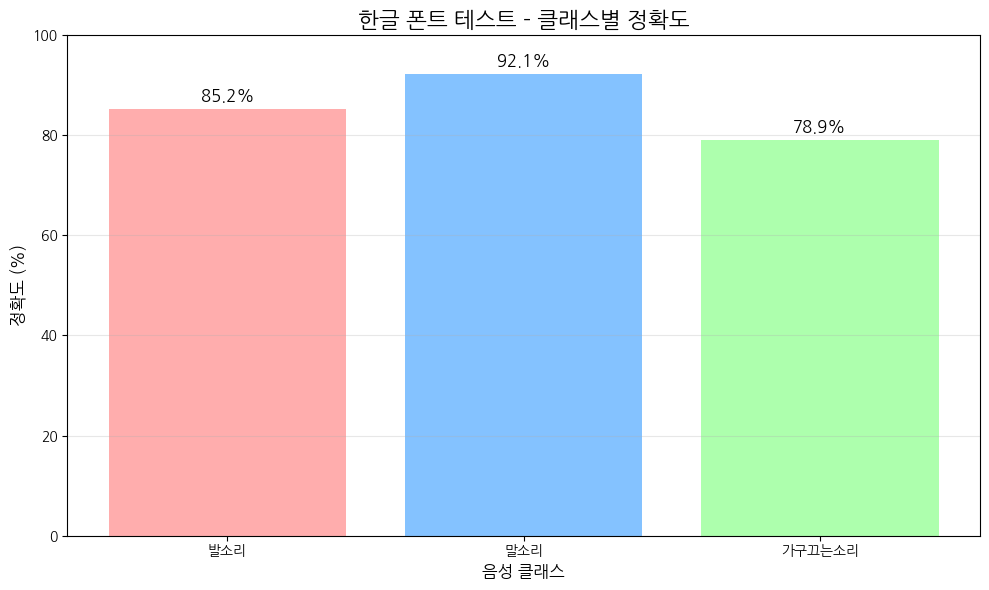

✅ 현재 폰트: ['NanumGothic']
🎉 한글 폰트가 제대로 설정되었습니다!


In [32]:
 test_korean_font()

🔄 실시간 특징 추출 데모

🎵 발소리 시뮬레이션 특징 추출 중...


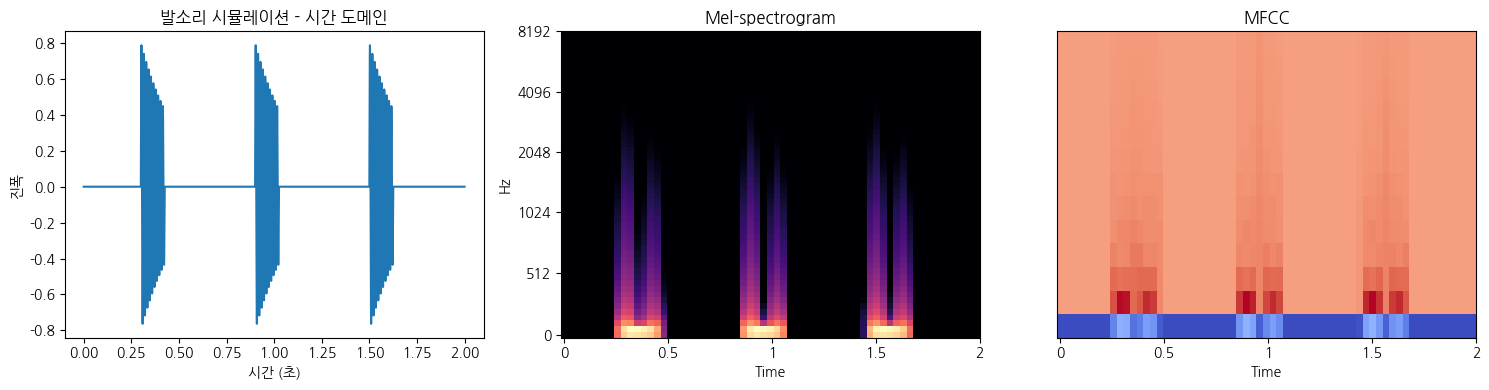


🎵 말소리 시뮬레이션 특징 추출 중...


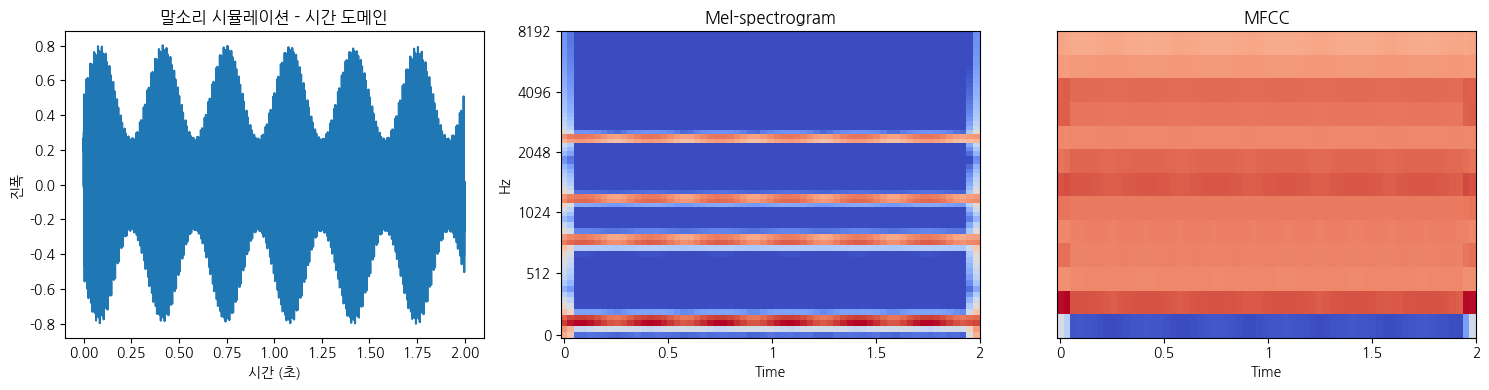


🎵 가구 시뮬레이션 특징 추출 중...


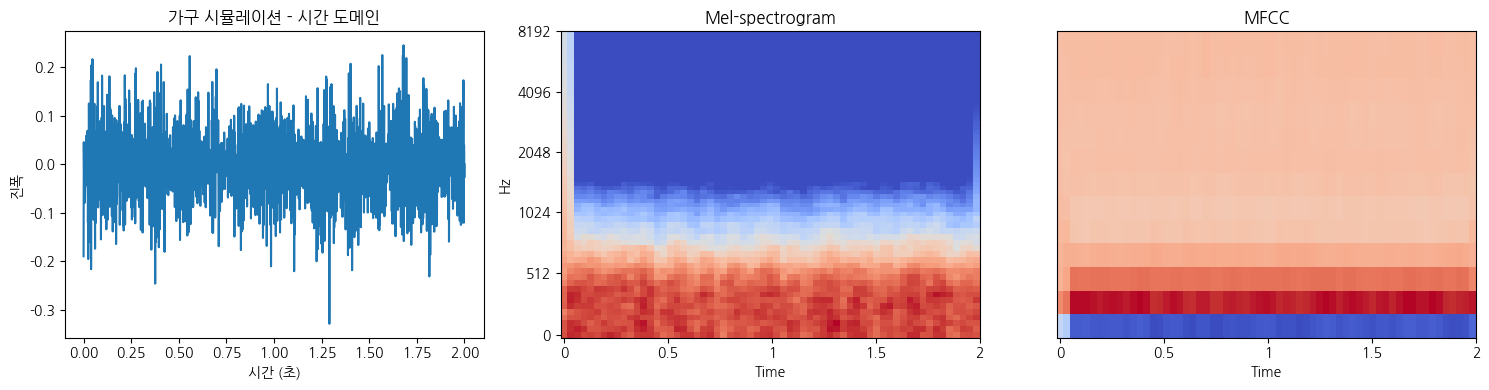

In [34]:
demo_realtime_features()

### wjfcnltjadasdadasdasddddddddd

In [54]:
# =============================================================================
# 2. Colab 환경 최적화
# =============================================================================

def setup_colab_environment():
    """Colab 환경 최적화"""
    try:
        mp.set_start_method('spawn', force=True)
    except:
        pass

    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ['OMP_NUM_THREADS'] = '1'

    # 한글 폰트 설정
    setup_korean_font()

    # Google Drive 마운트
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive 마운트 완료")
    except:
        print("⚠️ Google Drive 마운트 실패 또는 이미 마운트됨")

    print("✅ Colab 환경 최적화 완료")

def setup_korean_font():
    """한글 폰트 설정"""
    try:
        # 나눔고딕 폰트 설치
        !apt-get update -qq
        !apt-get install -qq fonts-nanum

        # matplotlib 폰트 설정
        import matplotlib.font_manager as fm
        import matplotlib.pyplot as plt

        # 폰트 캐시 삭제
        !rm -rf ~/.cache/matplotlib

        # 나눔고딕 폰트 경로
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

        if os.path.exists(font_path):
            # 폰트 등록
            fm.fontManager.addfont(font_path)

            # matplotlib 기본 폰트 설정
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

            print("✅ 한글 폰트 설정 완료")
        else:
            # 대체 방법: 구글 폰트 사용
            !wget -O NanumGothic.ttf "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf"

            # 폰트 등록
            fm.fontManager.addfont('./NanumGothic.ttf')
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False

            print("✅ 한글 폰트 설정 완료 (대체 폰트)")

    except Exception as e:
        print(f"⚠️ 한글 폰트 설정 실패: {e}")
        print("   영어로 표시됩니다.")

        # 영어 레이블로 대체
        plt.rcParams['font.family'] = 'DejaVu Sans'

def test_korean_font():
    """한글 폰트 테스트"""
    print("🔤 한글 폰트 테스트 중...")

    plt.figure(figsize=(10, 6))

    # 테스트 데이터
    classes = ['발소리', '말소리', '가구끄는소리']
    values = [85.2, 92.1, 78.9]
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    # 바 차트 생성
    bars = plt.bar(classes, values, color=colors, alpha=0.8)

    # 제목 및 레이블
    plt.title('한글 폰트 테스트 - 클래스별 정확도', fontsize=16, fontweight='bold')
    plt.xlabel('음성 클래스', fontsize=12)
    plt.ylabel('정확도 (%)', fontsize=12)

    # 값 표시
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.ylim(0, 100)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 폰트 상태 확인
    current_font = plt.rcParams['font.family']
    print(f"✅ 현재 폰트: {current_font}")

    if 'NanumGothic' in current_font or 'Nanum' in str(current_font):
        print("🎉 한글 폰트가 제대로 설정되었습니다!")
    else:
        print("⚠️ 한글 폰트 설정에 문제가 있을 수 있습니다.")
        print("   위 그래프에서 한글이 깨져 보인다면 런타임을 재시작해보세요.")

def memory_cleanup():
    """메모리 정리"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 메모리 정리 완료")

# =============================================================================
# 3. 3클래스 오디오 데이터셋 (발소리, 말소리, 가구끄는소리)
# =============================================================================

class ThreeClassAudioDataset(Dataset):
    def __init__(self, audio_paths, labels, target_sr=16000, max_duration=5.0, augment=False):
        """
        3클래스 오디오 분류 데이터셋

        Args:
            audio_paths: 오디오 파일 경로 리스트
            labels: 레이블 리스트 ['footstep', 'speech', 'furniture']
            target_sr: 목표 샘플링 레이트 (16kHz)
            max_duration: 최대 길이 (5초)
            augment: 데이터 증강 여부
        """
        self.audio_paths = audio_paths
        self.target_sr = target_sr
        self.max_duration = max_duration
        self.max_length = int(target_sr * max_duration)
        self.augment = augment

        # 레이블 매핑
        self.class_names = ['footstep', 'speech', 'furniture']
        self.label_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        self.idx_to_label = {idx: name for name, idx in self.label_to_idx.items()}

        # 레이블 인코딩
        self.labels = [self.label_to_idx[label] for label in labels]

        print(f"📊 데이터셋 정보:")
        print(f"   - 총 샘플 수: {len(self.audio_paths)}")
        print(f"   - 클래스: {self.class_names}")
        for i, class_name in enumerate(self.class_names):
            count = sum(1 for label in self.labels if label == i)
            print(f"   - {class_name}: {count}개")

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        try:
            # 오디오 로드
            audio, sr = librosa.load(
                self.audio_paths[idx],
                sr=self.target_sr,
                duration=self.max_duration
            )

            # 길이 정규화
            audio = self._normalize_length(audio)

            # 데이터 증강
            if self.augment:
                audio = self._augment_audio(audio)

            # 특징 추출 (Mel-spectrogram + MFCC)
            features = self._extract_features(audio)

            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([self.labels[idx]]),
                'path': self.audio_paths[idx]
            }

        except Exception as e:
            print(f"오디오 로딩 오류 {self.audio_paths[idx]}: {e}")
            # 빈 특징 반환
            features = np.zeros((128, 157))  # 기본 특징 크기
            return {
                'features': torch.FloatTensor(features),
                'label': torch.LongTensor([0]),
                'path': self.audio_paths[idx]
            }

    def _normalize_length(self, audio):
        """오디오 길이 정규화"""
        if len(audio) > self.max_length:
            # 랜덤 크롭
            start = np.random.randint(0, len(audio) - self.max_length + 1)
            audio = audio[start:start + self.max_length]
        elif len(audio) < self.max_length:
            # 제로 패딩
            audio = np.pad(audio, (0, self.max_length - len(audio)))
        return audio

    def _augment_audio(self, audio):
        """오디오 데이터 증강"""
        # 시간 이동
        if np.random.random() > 0.5:
            shift = np.random.randint(-len(audio)//8, len(audio)//8)
            audio = np.roll(audio, shift)

        # 볼륨 조절
        if np.random.random() > 0.5:
            volume_factor = np.random.uniform(0.7, 1.3)
            audio = audio * volume_factor

        # 가우시안 노이즈 추가
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.005, len(audio))
            audio = audio + noise

        # 피치 시프트 (가끔)
        if np.random.random() > 0.8:
            pitch_shift = np.random.randint(-2, 3)
            if pitch_shift != 0:
                audio = librosa.effects.pitch_shift(audio, sr=self.target_sr, n_steps=pitch_shift)

        return np.clip(audio, -1.0, 1.0)

    def _extract_features(self, audio):
        """특징 추출: Mel-spectrogram + MFCC"""
        # Mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.target_sr,
            n_mels=64,
            fmax=8000,
            hop_length=512,
            n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # MFCC
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=self.target_sr,
            n_mfcc=64,
            hop_length=512,
            n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 고정 크기로 조정
        target_frames = 157  # 5초 * 16000 / 512 ≈ 157
        if features.shape[1] != target_frames:
            features = self._resize_features(features, target_frames)

        return features

    def _resize_features(self, features, target_frames):
        """특징 크기 조정"""
        from scipy.ndimage import zoom
        zoom_factor = target_frames / features.shape[1]
        return zoom(features, (1, zoom_factor))

# =============================================================================
# 4. 3클래스 분류 CNN 모델
# =============================================================================

class ThreeClassAudioCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(ThreeClassAudioCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.2),
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Input: (batch_size, features, time)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =============================================================================
# 5. 학습 매니저
# =============================================================================

class ThreeClassTrainer:
    def __init__(self, model, train_loader, val_loader, device='auto', lr=0.001):
        self.device = torch.device('cuda' if torch.cuda.is_available() and device=='auto' else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        # 최적화 설정
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.01
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',  # 정확도 기준
            patience=5,
            factor=0.5,
            verbose=True
        )
        self.criterion = nn.CrossEntropyLoss()

        # 기록
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []
        self.best_val_acc = 0.0
        self.best_model_state = None

        print(f"🎯 학습 설정:")
        print(f"   - 장치: {self.device}")
        print(f"   - 학습률: {lr}")
        print(f"   - 클래스: 3개 (발소리, 말소리, 가구끄는소리)")

    def train_epoch(self):
        """한 에포크 학습"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc="학습")
        for batch in pbar:
            inputs = batch['features'].to(self.device)
            labels = batch['label'].squeeze().to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # 진행률 업데이트
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.1f}%'
            })

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self):
        """검증"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc="검증")
            for batch in pbar:
                inputs = batch['features'].to(self.device)
                labels = batch['label'].squeeze().to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # 혼동행렬용 데이터 수집
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct/total:.1f}%'
                })

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, all_preds, all_labels

    def train(self, num_epochs=30, save_path='best_three_class_model.pth'):
        """전체 학습"""
        print("🚀 3클래스 분류 학습 시작!")
        print("=" * 50)

        for epoch in range(num_epochs):
            print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

            # 학습
            train_loss, train_acc = self.train_epoch()
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            # 검증
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            # 스케줄러 업데이트
            self.scheduler.step(val_acc)

            print(f"   학습 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
            print(f"   검증 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
            print(f"   학습률: {self.optimizer.param_groups[0]['lr']:.6f}")

            # 최고 모델 저장
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_model_state = self.model.state_dict().copy()

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': ['footstep', 'speech', 'furniture']
                }, save_path)

                print(f"   ✅ 최고 모델 저장! (검증 정확도: {val_acc:.2f}%)")

                # 클래스별 정확도 출력
                self.print_class_accuracy(val_labels, val_preds)

            # 조기 종료
            if self.optimizer.param_groups[0]['lr'] < 1e-6:
                print("   ⏹️ 학습률이 너무 낮아 학습을 종료합니다.")
                break

            # 메모리 정리
            if epoch % 5 == 0:
                memory_cleanup()

        print(f"\n🎉 학습 완료!")
        print(f"   최고 검증 정확도: {self.best_val_acc:.2f}%")

        # 최고 모델 로드
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

        return self.model

    def print_class_accuracy(self, true_labels, pred_labels):
        """클래스별 정확도 출력"""
        class_names = ['발소리', '말소리', '가구끄는소리']

        for i, class_name in enumerate(class_names):
            class_mask = np.array(true_labels) == i
            if class_mask.sum() > 0:
                class_acc = (np.array(pred_labels)[class_mask] == i).sum() / class_mask.sum()
                print(f"     - {class_name}: {class_acc*100:.1f}%")

    def plot_training_history(self):
        """학습 히스토리 시각화 - 한글 지원"""
        # 한글 폰트 설정 확인
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 손실 그래프
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='학습 손실', linewidth=2, alpha=0.8)
        ax1.plot(epochs, self.val_losses, 'r-', label='검증 손실', linewidth=2, alpha=0.8)
        ax1.set_title('학습/검증 손실', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax1.set_ylabel('손실 (Loss)', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, len(self.train_losses))

        # 정확도 그래프
        ax2.plot(epochs, self.train_accs, 'b-', label='학습 정확도', linewidth=2, alpha=0.8)
        ax2.plot(epochs, self.val_accs, 'r-', label='검증 정확도', linewidth=2, alpha=0.8)
        ax2.set_title('학습/검증 정확도', fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel('에포크 (Epoch)', fontsize=12)
        ax2.set_ylabel('정확도 (%)', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        ax2.set_xlim(1, len(self.train_accs))

        # 최고 성능 지점 표시
        best_epoch = np.argmax(self.val_accs) + 1
        best_acc = max(self.val_accs)
        ax2.plot(best_epoch, best_acc, 'ro', markersize=10, markerfacecolor='red',
                markeredgecolor='darkred', markeredgewidth=2)
        ax2.annotate(f'최고: {best_acc:.1f}%\n(에포크 {best_epoch})',
                    xy=(best_epoch, best_acc), xytext=(10, 10),
                    textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()
        plt.show()

        # 상세 결과 출력
        print("\n" + "="*60)
        print("📊 학습 완료 - 최종 결과 요약")
        print("="*60)
        print(f"🎯 최고 검증 정확도: {max(self.val_accs):.2f}% (에포크 {np.argmax(self.val_accs)+1})")
        print(f"📈 최종 학습 정확도: {self.train_accs[-1]:.2f}%")
        print(f"📉 최종 검증 손실: {self.val_losses[-1]:.4f}")
        print(f"⏱️ 총 학습 에포크: {len(self.train_accs)}개")

        # 성능 안정성 분석
        last_5_accs = self.val_accs[-5:] if len(self.val_accs) >= 5 else self.val_accs
        stability = np.std(last_5_accs)
        print(f"📊 최근 5에포크 정확도 안정성: {stability:.2f}% (낮을수록 안정)")

        if stability < 2.0:
            print("✅ 매우 안정적인 학습!")
        elif stability < 5.0:
            print("👍 안정적인 학습")
        else:
            print("⚠️ 불안정한 학습 - 더 많은 에포크나 조기종료 필요")

        print("="*60)

# =============================================================================
# 6. 데이터 처리 및 학습 실행 함수
# =============================================================================

def scan_three_class_data(base_path):
    """3클래스 데이터 스캔 - 강화버전"""
    audio_files = []
    labels = []

    # 지원되는 오디오 확장자 (더 많은 형식 추가)
    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    print(f"📂 {base_path}에서 오디오 파일 스캔 중...")
    print(f"   지원 확장자: {', '.join(extensions)}")

    # 각 클래스별 폴더에서 파일 수집 (더 많은 키워드 추가)
    class_folders = {
        'footstep': ['footstep', 'footsteps', 'foot', 'walk', 'walking', 'step',
                    '발소리', '걸음소리', '발걸음', '보행', 'steps', 'footfall'],
        'speech': ['speech', 'voice', 'talk', 'talking', 'speaking', '말소리', 'speak',
                  '음성', '대화', '목소리', 'vocal', 'utterance', 'conversation'],
        'furniture': ['furniture', 'chair', 'table', 'drag', 'move', '가구', 'scrape',
                     '끄는소리', '이동', '의자', '테이블', 'moving', 'sliding', 'dragging']
    }

    # 모든 하위 디렉토리 탐색
    total_files_found = 0
    processed_dirs = []

    for root, dirs, files in os.walk(base_path):
        folder_name = os.path.basename(root).lower()
        relative_path = os.path.relpath(root, base_path)

        # 오디오 파일이 있는지 확인
        audio_files_in_dir = [f for f in files if any(f.lower().endswith(ext) for ext in extensions)]

        if audio_files_in_dir:
            print(f"   📁 {relative_path} - {len(audio_files_in_dir)}개 오디오 파일 발견")
            total_files_found += len(audio_files_in_dir)

            # 폴더명으로 클래스 판단
            detected_class = None
            for class_name, keywords in class_folders.items():
                if any(keyword in folder_name for keyword in keywords):
                    detected_class = class_name
                    break

            # 클래스가 자동 감지되지 않으면 사용자에게 물어보기
            if detected_class is None:
                print(f"   ❓ '{folder_name}' 폴더의 클래스를 판단할 수 없습니다.")
                print(f"      다음 중 하나를 선택하세요:")
                print(f"      1: footstep (발소리)")
                print(f"      2: speech (말소리)")
                print(f"      3: furniture (가구끄는소리)")
                print(f"      0: skip (건너뛰기)")

                try:
                    choice = input(f"   선택 (1/2/3/0): ").strip()
                    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}
                    if choice in class_mapping:
                        detected_class = class_mapping[choice]
                        print(f"   ✅ '{folder_name}' -> {detected_class}")
                    else:
                        print(f"   ⏩ '{folder_name}' 폴더 건너뜀")
                        continue
                except:
                    print(f"   ⏩ 입력 오류로 '{folder_name}' 폴더 건너뜀")
                    continue
            else:
                print(f"   ✅ {relative_path} -> {detected_class}")

            # 파일 추가
            for file in audio_files_in_dir:
                file_path = os.path.join(root, file)
                audio_files.append(file_path)
                labels.append(detected_class)

            processed_dirs.append((relative_path, detected_class, len(audio_files_in_dir)))

    # 상세 결과 출력
    print(f"\n📊 데이터 스캔 완료:")
    print(f"   - 총 발견된 오디오 파일: {total_files_found}개")
    print(f"   - 실제 사용할 파일: {len(audio_files)}개")
    print(f"   - 처리된 디렉토리: {len(processed_dirs)}개")

    print(f"\n📁 처리된 디렉토리 상세:")
    for dir_path, class_name, count in processed_dirs:
        print(f"   - {dir_path}: {class_name} ({count}개)")

    print(f"\n🏷️ 클래스별 파일 수:")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    if len(audio_files) == 0:
        print("\n❌ 사용 가능한 오디오 파일이 없습니다!")
        print("   다음을 확인해주세요:")
        print("   1. 파일 확장자가 지원되는지 확인")
        print("   2. 폴더 구조가 올바른지 확인")
        print("   3. 파일이 실제로 오디오 파일인지 확인")
        return [], []

    if total_files_found > len(audio_files):
        print(f"\n⚠️ 주의: {total_files_found - len(audio_files)}개 파일이 제외되었습니다.")
        print("   폴더명이 클래스와 매치되지 않아 제외되었을 수 있습니다.")

    return audio_files, labels

def detailed_data_analysis(base_path):
    """데이터 상세 분석"""
    print("🔍 데이터 구조 상세 분석 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']

    total_files = 0
    total_size = 0
    dir_info = []

    for root, dirs, files in os.walk(base_path):
        audio_files = []
        dir_size = 0

        for file in files:
            file_path = os.path.join(root, file)
            if any(file.lower().endswith(ext) for ext in extensions):
                audio_files.append(file)
                try:
                    file_size = os.path.getsize(file_path)
                    dir_size += file_size
                except:
                    pass

        if audio_files:
            relative_path = os.path.relpath(root, base_path)
            dir_info.append({
                'path': relative_path,
                'files': len(audio_files),
                'size_mb': dir_size / (1024*1024),
                'sample_files': audio_files[:3]  # 처음 3개 파일명
            })

            total_files += len(audio_files)
            total_size += dir_size

    print(f"\n📊 전체 통계:")
    print(f"   - 총 오디오 파일: {total_files}개")
    print(f"   - 총 크기: {total_size/(1024*1024):.1f} MB")
    print(f"   - 오디오가 있는 폴더: {len(dir_info)}개")

    print(f"\n📁 폴더별 상세 정보:")
    for info in sorted(dir_info, key=lambda x: x['files'], reverse=True):
        print(f"   📂 {info['path']}")
        print(f"      - 파일 수: {info['files']}개")
        print(f"      - 크기: {info['size_mb']:.1f} MB")
        print(f"      - 샘플: {', '.join(info['sample_files'])}")
        print()

    return dir_info

def force_scan_all_audio_files(base_path):
    """모든 오디오 파일 강제 스캔 (클래스 구분 없이)"""
    print("🔄 모든 오디오 파일 강제 스캔 중...")

    extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg', '.aac', '.wma', '.aiff', '.au']
    all_files = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                file_path = os.path.join(root, file)
                relative_path = os.path.relpath(file_path, base_path)
                all_files.append({
                    'path': file_path,
                    'relative': relative_path,
                    'dir': os.path.dirname(relative_path),
                    'filename': file
                })

    print(f"📊 전체 스캔 결과: {len(all_files)}개 오디오 파일 발견")

    # 디렉토리별 그룹화
    from collections import defaultdict
    dir_groups = defaultdict(list)

    for file_info in all_files:
        dir_name = file_info['dir'] if file_info['dir'] else 'root'
        dir_groups[dir_name].append(file_info)

    print(f"\n📁 디렉토리별 파일 수:")
    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"   {dir_name}: {len(file_list)}개")
        # 처음 3개 파일명 표시
        for i, file_info in enumerate(file_list[:3]):
            print(f"      - {file_info['filename']}")
        if len(file_list) > 3:
            print(f"      ... 그 외 {len(file_list)-3}개")
        print()

    return all_files, dir_groups

def run_three_class_training(data_path, num_epochs=40, batch_size=7, test_size=0.2):
    """3클래스 분류 학습 실행"""

    print("🎯 발소리-말소리-가구끄는소리 분류 학습 시작!")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()
    memory_cleanup()

    # 1. 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        print("📁 데이터 구조를 확인해주세요:")
        print("   your_dataset/")
        print("   ├── footstep/")
        print("   ├── speech/")
        print("   └── furniture/")
        return None

    # 2. 학습/검증 분할
    train_files, val_files, train_labels, val_labels = train_test_split(
        audio_files, labels, test_size=test_size, random_state=42, stratify=labels
    )

    print(f"\n📊 데이터 분할:")
    print(f"   - 학습: {len(train_files)}개")
    print(f"   - 검증: {len(val_files)}개")

    # 3. 데이터셋 생성
    train_dataset = ThreeClassAudioDataset(
        train_files, train_labels, augment=True
    )
    val_dataset = ThreeClassAudioDataset(
        val_files, val_labels, augment=False
    )

    # 4. 데이터 로더 생성
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=False
    )

    # 5. 모델 생성
    model = ThreeClassAudioCNN(num_classes=3)
    print(f"🤖 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")

    # 6. 학습 실행
    trainer = ThreeClassTrainer(model, train_loader, val_loader)
    trained_model = trainer.train(num_epochs=num_epochs)

    # 7. 결과 시각화
    trainer.plot_training_history()

    # 8. 혼동행렬 생성
    plot_confusion_matrix(trained_model, val_loader)

    return trained_model, trainer

def plot_confusion_matrix(model, val_loader):
    """혼동행렬 시각화 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ['발소리', '말소리', '가구끄는소리']

    # 시각화
    plt.figure(figsize=(10, 8))

    # 한글 폰트 확인 및 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        # 폰트 설정이 안된 경우 영어로 대체
        class_names = ['Footstep', 'Speech', 'Furniture']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Frequency'})
    plt.title('혼동 행렬 (Confusion Matrix)', fontsize=16, pad=20)
    plt.xlabel('예측값 (Predicted)', fontsize=12)
    plt.ylabel('실제값 (Actual)', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 분류 리포트
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names, output_dict=True)

    print("\n📊 상세 분류 결과:")
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        print(f"   {class_name}:")
        print(f"     - 정밀도(Precision): {precision:.3f}")
        print(f"     - 재현율(Recall): {recall:.3f}")
        print(f"     - F1-Score: {f1:.3f}")
        print(f"     - 샘플 수: {support}")

    print(f"\n   전체 정확도: {report['accuracy']:.3f}")
    print(f"   매크로 평균 F1: {report['macro avg']['f1-score']:.3f}")

    # 클래스별 정확도 바 차트
    plt.figure(figsize=(10, 6))
    class_accuracies = []
    for i in range(len(class_names)):
        if cm[i].sum() > 0:
            acc = cm[i, i] / cm[i].sum()
            class_accuracies.append(acc)
        else:
            class_accuracies.append(0)

    colors = ['#ff7f7f', '#7f7fff', '#7fff7f']
    bars = plt.bar(class_names, class_accuracies, color=colors, alpha=0.8)
    plt.title('클래스별 정확도', fontsize=16, pad=20)
    plt.xlabel('클래스', fontsize=12)
    plt.ylabel('정확도', fontsize=12)
    plt.ylim(0, 1.1)

    # 각 막대 위에 정확도 값 표시
    for bar, acc in zip(bars, class_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 7. 실시간 예측 함수 (완성)
# =============================================================================

def predict_audio_file(model_path, audio_file_path):
    """오디오 파일 예측 - 완성 버전"""
    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    class_names = ['발소리', '말소리', '가구끄는소리']
    class_names_eng = ['footstep', 'speech', 'furniture']

    try:
        # 오디오 로드 및 전처리
        audio, sr = librosa.load(audio_file_path, sr=16000, duration=5.0)

        # 길이 정규화
        max_length = 16000 * 5
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        else:
            audio = audio[:max_length]

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        mfcc = librosa.feature.mfcc(
            y=audio, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])  # (128, time_frames)

        # 크기 조정
        target_frames = 157
        if features.shape[1] != target_frames:
            from scipy.ndimage import zoom
            zoom_factor = target_frames / features.shape[1]
            features = zoom(features, (1, zoom_factor))

        # 예측
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).unsqueeze(0)  # 배치 차원 추가
            outputs = model(features_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # 결과 반환
        result = {
            'predicted_class': class_names[predicted_class],
            'predicted_class_eng': class_names_eng[predicted_class],
            'confidence': confidence,
            'probabilities': {
                class_names[i]: prob.item()
                for i, prob in enumerate(probabilities[0])
            }
        }

        # 시각화
        visualize_prediction_result(audio, sr, features, result)

        return result

    except Exception as e:
        print(f"❌ 예측 오류: {str(e)}")
        return None

def visualize_prediction_result(audio, sr, features, result):
    """예측 결과 시각화"""
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('오디오 파형', '특징 맵 (Mel-spec + MFCC)', '예측 확률', '주파수 스펙트럼'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "bar"}, {"secondary_y": False}]]
    )

    # 1. 오디오 파형
    time = np.linspace(0, len(audio)/sr, len(audio))
    fig.add_trace(
        go.Scatter(x=time, y=audio, name='오디오 신호', line=dict(color='blue')),
        row=1, col=1
    )

    # 2. 특징 맵
    fig.add_trace(
        go.Heatmap(z=features, colorscale='Viridis', name='특징 맵'),
        row=1, col=2
    )

    # 3. 예측 확률
    classes = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    colors = ['red' if cls == result['predicted_class'] else 'lightblue' for cls in classes]

    fig.add_trace(
        go.Bar(x=classes, y=probs, name='예측 확률',
               marker=dict(color=colors)),
        row=2, col=1
    )

    # 4. 주파수 스펙트럼
    freqs = np.fft.fftfreq(len(audio), 1/sr)[:len(audio)//2]
    fft_vals = np.abs(np.fft.fft(audio))[:len(audio)//2]

    fig.add_trace(
        go.Scatter(x=freqs, y=fft_vals, name='주파수 스펙트럼', line=dict(color='green')),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        title_text=f"예측 결과: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})"
    )
    fig.show()

    # 결과 출력
    print(f"\n🎯 예측 결과:")
    print(f"   - 예측 클래스: {result['predicted_class']}")
    print(f"   - 신뢰도: {result['confidence']:.3f}")
    print(f"\n📊 모든 클래스 확률:")
    for class_name, prob in result['probabilities'].items():
        print(f"   - {class_name}: {prob:.3f}")

# =============================================================================
# 8. 샘플 데이터 생성기
# =============================================================================

def generate_sample_audio_data(output_dir='sample_data', samples_per_class=20):
    """테스트용 샘플 오디오 데이터 생성"""
    print("🎼 샘플 오디오 데이터 생성 중...")

    os.makedirs(output_dir, exist_ok=True)

    # 각 클래스별 폴더 생성
    classes = ['footstep', 'speech', 'furniture']
    for class_name in classes:
        os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

    sr = 16000
    duration = 3.0
    t = np.linspace(0, duration, int(sr * duration))

    for i in range(samples_per_class):
        # 발소리 시뮬레이션 (짧은 충격음들)
        footstep = np.zeros_like(t)
        for step in range(4):  # 4번의 발걸음
            start_idx = int(step * len(t) / 4) + np.random.randint(-1000, 1000)
            if 0 <= start_idx < len(t) - 1000:
                # 충격음 시뮬레이션
                impact = np.exp(-np.arange(1000) * 0.01) * np.sin(2 * np.pi * np.random.uniform(80, 200) * np.arange(1000) / sr)
                footstep[start_idx:start_idx+1000] += impact * np.random.uniform(0.3, 0.8)

        # 노이즈 추가
        footstep += np.random.normal(0, 0.02, len(footstep))
        footstep = np.clip(footstep, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'footstep', f'footstep_{i:03d}.wav'), footstep, sr)

        # 말소리 시뮬레이션 (여러 주파수 성분)
        speech = np.zeros_like(t)
        # 기본 음성 주파수들 (100-300Hz)
        for freq in [120, 180, 240, 300]:
            amplitude = np.random.uniform(0.1, 0.3)
            speech += amplitude * np.sin(2 * np.pi * freq * t)

        # 포먼트 시뮬레이션 (800-2000Hz)
        for freq in [800, 1200, 1600, 2000]:
            amplitude = np.random.uniform(0.05, 0.15)
            modulation = 1 + 0.5 * np.sin(2 * np.pi * np.random.uniform(5, 15) * t)
            speech += amplitude * np.sin(2 * np.pi * freq * t) * modulation

        # 노이즈 및 변조
        speech *= (1 + 0.3 * np.sin(2 * np.pi * np.random.uniform(1, 5) * t))
        speech += np.random.normal(0, 0.02, len(speech))
        speech = np.clip(speech, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'speech', f'speech_{i:03d}.wav'), speech, sr)

        # 가구끄는소리 시뮬레이션 (마찰음)
        furniture = np.zeros_like(t)

        # 마찰음 기본 주파수 (낮은 주파수 + 고주파 노이즈)
        base_freq = np.random.uniform(20, 80)
        furniture += 0.4 * np.sin(2 * np.pi * base_freq * t)

        # 고주파 마찰음 (1-4kHz)
        high_freq_noise = np.random.normal(0, 0.1, len(t))
        butter_b, butter_a = scipy.signal.butter(4, [1000, 4000], btype='band', fs=sr)
        high_freq_filtered = scipy.signal.filtfilt(butter_b, butter_a, high_freq_noise)
        furniture += 0.3 * high_freq_filtered

        # 불규칙한 진동 패턴
        irregular_pattern = np.random.uniform(0.5, 1.5, 100)
        furniture *= np.interp(t, np.linspace(0, duration, 100), irregular_pattern)

        furniture = np.clip(furniture, -1.0, 1.0)

        sf.write(os.path.join(output_dir, 'furniture', f'furniture_{i:03d}.wav'), furniture, sr)

    print(f"✅ 샘플 데이터 생성 완료!")
    print(f"   - 경로: {output_dir}")
    print(f"   - 클래스별 {samples_per_class}개씩 총 {samples_per_class * 3}개 파일")

    return output_dir

# =============================================================================
# 9. 실시간 녹음 및 예측
# =============================================================================

def record_and_predict(model_path, duration=5):
    """실시간 녹음 및 예측"""
    print(f"🎤 {duration}초간 녹음을 시작합니다...")
    print("   마이크에 대고 소리를 내세요!")

    try:
        # JavaScript를 사용한 녹음 (Colab 환경)
        from google.colab import output
        from base64 import b64decode

        RECORD = """
        const sleep = time => new Promise(resolve => setTimeout(resolve, time))
        const b2text = blob => new Promise(resolve => {
          const reader = new FileReader()
          reader.onloadend = e => resolve(e.srcElement.result)
          reader.readAsDataURL(blob)
        })

        var record = time => new Promise(async resolve => {
          stream = await navigator.mediaDevices.getUserMedia({ audio: true })
          recorder = new MediaRecorder(stream)
          chunks = []
          recorder.ondataavailable = e => chunks.push(e.data)
          recorder.onstop = async ()=>{
            blob = new Blob(chunks, { type: 'audio/wav' })
            text = await b2text(blob)
            resolve(text)
          }
          recorder.start()
          await sleep(time)
          recorder.stop()
        })
        """

        display(HTML(f'''
        <script>
        {RECORD}
        </script>
        <button onclick="record({duration * 1000}).then(audio => {{
            google.colab.kernel.invokeFunction('save_audio', [audio], {{}})
        }})">🎤 녹음 시작 ({duration}초)</button>
        '''))

        print("   위의 녹음 버튼을 클릭해주세요!")

    except Exception as e:
        print(f"❌ 녹음 기능 오류: {e}")
        print("   대신 파일 업로드를 사용해주세요.")

def save_audio(audio_data):
    """녹음된 오디오 저장 및 예측"""
    try:
        # Base64 디코딩
        audio_data = audio_data.split(',')[1]
        audio_bytes = b64decode(audio_data)

        # 파일 저장
        with open('recorded_audio.wav', 'wb') as f:
            f.write(audio_bytes)

        print("✅ 녹음 완료! 예측 중...")

        # 예측 실행 (모델이 있다면)
        if os.path.exists('best_three_class_model.pth'):
            result = predict_audio_file('best_three_class_model.pth', 'recorded_audio.wav')
            if result:
                print_prediction_result(result)
        else:
            print("⚠️ 학습된 모델이 없습니다. 먼저 학습을 실행해주세요.")

    except Exception as e:
        print(f"❌ 오디오 저장 오류: {e}")

def print_prediction_result(result):
    """예측 결과 출력"""
    print("\n" + "="*50)
    print("🎯 실시간 예측 결과")
    print("="*50)
    print(f"🔍 예측 클래스: {result['predicted_class']}")
    print(f"📊 신뢰도: {result['confidence']:.1%}")
    print("\n📈 각 클래스별 확률:")

    for class_name, prob in result['probabilities'].items():
        bar = "█" * int(prob * 20)
        print(f"   {class_name:12}: {prob:.3f} |{bar}")

# =============================================================================
# 10. 업로드 파일 분석
# =============================================================================

def analyze_uploaded_file(path=None):
    """파일 업로드 및 분석 - 경로 지정 가능"""

    if path is not None:
        # 경로가 지정된 경우: 폴더 또는 파일 분석
        if os.path.isfile(path):
            # 단일 파일 분석
            print(f"📁 지정된 파일 분석: {path}")
            file_name = path

        elif os.path.isdir(path):
            # 폴더에서 파일 선택하여 분석
            print(f"📂 폴더에서 파일 선택: {path}")

            # 폴더 내 오디오 파일 찾기
            audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
            audio_files = []

            for root, dirs, files in os.walk(path):
                for file in files:
                    if any(file.lower().endswith(ext) for ext in audio_extensions):
                        audio_files.append(os.path.join(root, file))

            if not audio_files:
                print("❌ 지정된 폴더에서 오디오 파일을 찾을 수 없습니다!")
                return None

            print(f"📊 {len(audio_files)}개 오디오 파일 발견")

            # 처음 몇 개 파일 표시
            print("📋 발견된 파일들 (처음 10개):")
            for i, file_path in enumerate(audio_files[:10]):
                print(f"   {i+1}. {os.path.basename(file_path)}")

            if len(audio_files) > 10:
                print(f"   ... 그 외 {len(audio_files)-10}개 파일")

            # 첫 번째 파일로 분석 실행
            file_name = audio_files[0]
            print(f"\n🎵 첫 번째 파일로 분석 실행: {os.path.basename(file_name)}")

        else:
            print(f"❌ 지정된 경로를 찾을 수 없습니다: {path}")
            return None
    else:
        # 기존 업로드 방식
        print("📁 오디오 파일을 업로드해주세요...")
        uploaded = files.upload()

        if uploaded:
            file_name = list(uploaded.keys())[0]
            print(f"✅ 파일 '{file_name}' 업로드 완료!")
        else:
            print("❌ 파일이 업로드되지 않았습니다.")
            return None

    # 모델이 있는지 확인
    model_path = 'best_three_class_model.pth'
    if not os.path.exists(model_path):
        print("⚠️ 학습된 모델이 없습니다.")
        print("   먼저 샘플 데이터로 학습하거나 실제 데이터로 학습해주세요.")
        print("   run_sample_training() 실행하세요.")
        return None

    # 파일 분석 실행
    try:
        result = visualize_audio_prediction(
            model_path,
            file_name,
            save_image=True,
            show_features=True
        )

        if result:
            print_prediction_result(result)
            return result
        else:
            print("❌ 파일 분석에 실패했습니다.")
            return None

    except Exception as e:
        print(f"❌ 분석 중 오류 발생: {str(e)}")
        return None

def analyze_folder_batch(folder_path, max_files=10, save_images=False):
    """폴더 내 모든 오디오 파일 일괄 분석"""
    print(f"📂 폴더 일괄 분석: {folder_path}")

    if not os.path.exists('best_three_class_model.pth'):
        print("❌ 학습된 모델이 없습니다!")
        print("   먼저 run_sample_training()을 실행하세요.")
        return None

    # 오디오 파일 찾기
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    audio_files = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    if not audio_files:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        return None

    print(f"📊 {len(audio_files)}개 파일 발견, {min(max_files, len(audio_files))}개 분석 예정")

    # 일괄 분석 실행
    results = batch_visualize_predictions(
        'best_three_class_model.pth',
        audio_files[:max_files],
        max_files=max_files,
        save_images=save_images
    )

    return results

def quick_file_check(file_or_folder_path):
    """파일 또는 폴더 빠른 확인"""
    print(f"🔍 경로 확인: {file_or_folder_path}")

    if not os.path.exists(file_or_folder_path):
        print("❌ 경로가 존재하지 않습니다!")
        return False

    if os.path.isfile(file_or_folder_path):
        print(f"📄 파일 확인됨: {os.path.basename(file_or_folder_path)}")
        file_size = os.path.getsize(file_or_folder_path) / 1024  # KB
        print(f"   - 크기: {file_size:.1f} KB")

        # 오디오 파일인지 확인
        audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
        is_audio = any(file_or_folder_path.lower().endswith(ext) for ext in audio_extensions)

        if is_audio:
            print("   - 형식: 오디오 파일 ✅")

            # 간단한 오디오 정보
            try:
                audio, sr = librosa.load(file_or_folder_path, sr=None, duration=1.0)
                duration_estimate = len(audio) / sr
                print(f"   - 추정 길이: {duration_estimate:.1f}초")
                print(f"   - 샘플링 레이트: {sr} Hz")
            except Exception as e:
                print(f"   - 오디오 로딩 오류: {e}")
        else:
            print("   - 형식: 오디오 파일이 아님 ❌")

        return is_audio

    elif os.path.isdir(file_or_folder_path):
        print(f"📂 폴더 확인됨")

        # 폴더 내 오디오 파일 개수 확인
        audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
        audio_count = 0
        total_size = 0

        for root, dirs, files in os.walk(file_or_folder_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in audio_extensions):
                    audio_count += 1
                    try:
                        file_path = os.path.join(root, file)
                        total_size += os.path.getsize(file_path)
                    except:
                        pass

        print(f"   - 오디오 파일 수: {audio_count}개")
        print(f"   - 총 크기: {total_size/(1024*1024):.1f} MB")

        if audio_count > 0:
            print("   - 분석 가능 ✅")
        else:
            print("   - 오디오 파일 없음 ❌")

        return audio_count > 0

    return False

# =============================================================================
# 11. 데모 및 테스트 함수들
# =============================================================================

def debug_data_loading(data_path):
    """데이터 로딩 과정 디버깅"""
    print("🐛 데이터 로딩 과정 디버깅 중...")

    # 1. 전체 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)
    print(f"1️⃣ 전체 스캔: {len(all_files)}개 파일 발견")

    # 2. 클래스 매칭 테스트
    audio_files, labels = scan_three_class_data(data_path)
    print(f"2️⃣ 클래스 매칭: {len(audio_files)}개 파일 매칭")

    # 3. 누락된 파일들 분석
    matched_paths = set(audio_files)
    all_paths = set([f['path'] for f in all_files])
    missing_files = all_paths - matched_paths

    if missing_files:
        print(f"\n❗ 누락된 파일들 ({len(missing_files)}개):")
        missing_by_dir = defaultdict(list)
        for missing_path in list(missing_files)[:20]:  # 처음 20개만 표시
            dir_name = os.path.dirname(os.path.relpath(missing_path, data_path))
            missing_by_dir[dir_name].append(os.path.basename(missing_path))

        for dir_name, files in missing_by_dir.items():
            print(f"   📁 {dir_name}: {len(files)}개")
            for file in files[:3]:
                print(f"      - {file}")
            if len(files) > 3:
                print(f"      ... 그 외 {len(files)-3}개")

    # 4. 실제 로딩 테스트
    print(f"\n🧪 실제 오디오 로딩 테스트 (처음 10개 파일)...")
    loading_errors = 0

    for i, file_path in enumerate(audio_files[:10]):
        try:
            audio, sr = librosa.load(file_path, sr=16000, duration=1.0)  # 1초만 테스트
            duration = len(audio) / sr
            print(f"   ✅ {i+1}: {os.path.basename(file_path)} ({duration:.1f}초, {sr}Hz)")
        except Exception as e:
            print(f"   ❌ {i+1}: {os.path.basename(file_path)} - {str(e)}")
            loading_errors += 1

    if loading_errors > 0:
        print(f"\n⚠️ {loading_errors}개 파일에서 로딩 오류 발생")
        print("   일부 파일이 손상되었거나 지원되지 않는 형식일 수 있습니다.")

    return {
        'total_found': len(all_files),
        'matched': len(audio_files),
        'missing': len(missing_files),
        'loading_errors': loading_errors,
        'dir_groups': dir_groups
    }

def create_manual_dataset(data_path):
    """수동으로 데이터셋 생성 (모든 파일 사용)"""
    print("🛠️ 수동 데이터셋 생성 중...")

    # 모든 파일 스캔
    all_files, dir_groups = force_scan_all_audio_files(data_path)

    audio_files = []
    labels = []

    print(f"\n각 디렉토리의 클래스를 수동으로 지정해주세요:")
    print("1: footstep (발소리)")
    print("2: speech (말소리)")
    print("3: furniture (가구끄는소리)")
    print("0: skip (제외)")

    class_mapping = {'1': 'footstep', '2': 'speech', '3': 'furniture'}

    for dir_name, file_list in sorted(dir_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"\n📁 {dir_name} ({len(file_list)}개 파일)")
        print(f"   샘플 파일: {', '.join([f['filename'] for f in file_list[:3]])}")

        while True:
            try:
                choice = input(f"   클래스 선택 (1/2/3/0): ").strip()
                if choice == '0':
                    print(f"   ⏩ {dir_name} 폴더 제외")
                    break
                elif choice in class_mapping:
                    selected_class = class_mapping[choice]
                    print(f"   ✅ {dir_name} -> {selected_class}")

                    # 파일들 추가
                    for file_info in file_list:
                        audio_files.append(file_info['path'])
                        labels.append(selected_class)
                    break
                else:
                    print("   잘못된 선택입니다. 다시 입력해주세요.")
            except KeyboardInterrupt:
                print("\n   작업이 중단되었습니다.")
                return [], []

    print(f"\n📊 수동 데이터셋 생성 완료:")
    print(f"   - 총 파일 수: {len(audio_files)}개")
    for class_name in ['footstep', 'speech', 'furniture']:
        count = labels.count(class_name)
        percentage = (count / len(labels) * 100) if len(labels) > 0 else 0
        print(f"   - {class_name}: {count}개 ({percentage:.1f}%)")

    return audio_files, labels
    """샘플 데이터 또는 실제 데이터로 학습 실행"""

    if data_path is None:
        print("🎼 샘플 데이터를 생성하고 학습을 시작합니다...")
        # 샘플 데이터 생성
        sample_dir = generate_sample_audio_data('sample_data', samples_per_class=30)
        data_path = sample_dir
        print("✅ 샘플 데이터 생성 완료!")
    else:
        print(f"📁 실제 데이터를 사용합니다: {data_path}")

    # 학습 실행
    print("🚀 학습을 시작합니다...")
    model, trainer = run_three_class_training(
        data_path=data_path,
        num_epochs=num_epochs,
        batch_size=batch_size,
        test_size=0.2
    )

    print("✅ 학습 완료! 이제 테스트해보세요.")
    return model, trainer

def test_model_with_samples():
    """샘플로 모델 테스트"""
    if not os.path.exists('best_three_class_model.pth'):
        print("❌ 학습된 모델이 없습니다!")
        print("   run_sample_training() 먼저 실행해주세요.")
        return

    if not os.path.exists('sample_data'):
        print("❌ 샘플 데이터가 없습니다!")
        return

    print("🧪 샘플 파일들로 모델 테스트 중...")

    # 각 클래스에서 랜덤 파일 선택
    classes = ['footstep', 'speech', 'furniture']

    for class_name in classes:
        class_dir = os.path.join('sample_data', class_name)
        if os.path.exists(class_dir):
            files_list = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
            if files_list:
                test_file = os.path.join(class_dir, random.choice(files_list))
                print(f"\n🎵 테스트 중: {class_name} 클래스")
                print(f"   파일: {test_file}")

                result = predict_audio_file('best_three_class_model.pth', test_file)
                if result:
                    correct = "✅" if result['predicted_class_eng'] == class_name else "❌"
                    print(f"   {correct} 예측: {result['predicted_class']} (신뢰도: {result['confidence']:.2f})")

                    # 오디오 재생
                    audio, sr = librosa.load(test_file, sr=16000)
                    display(Audio(audio, rate=sr))

def demo_realtime_features():
    """실시간 특징 추출 데모"""
    print("🔄 실시간 특징 추출 데모")

    # 짧은 테스트 신호 생성
    sr = 16000
    duration = 2.0
    t = np.linspace(0, duration, int(sr * duration))

    # 다양한 신호 생성
    signals = {
        '발소리 시뮬레이션': create_footstep_signal(t, sr),
        '말소리 시뮬레이션': create_speech_signal(t, sr),
        '가구 시뮬레이션': create_furniture_signal(t, sr)
    }

    for name, signal in signals.items():
        print(f"\n🎵 {name} 특징 추출 중...")

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=64)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # 원본 신호
        axes[0].plot(t, signal)
        axes[0].set_title(f'{name} - 시간 도메인')
        axes[0].set_xlabel('시간 (초)')
        axes[0].set_ylabel('진폭')

        # Mel-spectrogram
        librosa.display.specshow(librosa.power_to_db(mel_spec), sr=sr, x_axis='time', y_axis='mel', ax=axes[1])
        axes[1].set_title('Mel-spectrogram')

        # MFCC
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=axes[2])
        axes[2].set_title('MFCC')

        plt.tight_layout()
        plt.show()

        # 오디오 재생
        display(Audio(signal, rate=sr))

def create_footstep_signal(t, sr):
    """발소리 신호 생성"""
    signal = np.zeros_like(t)
    step_times = [0.3, 0.9, 1.5]  # 발걸음 시간

    for step_time in step_times:
        start_idx = int(step_time * sr)
        if start_idx < len(signal) - 2000:
            # 충격음 (감쇠하는 저주파)
            impact_t = np.arange(2000) / sr
            impact = np.exp(-impact_t * 5) * np.sin(2 * np.pi * 80 * impact_t)
            signal[start_idx:start_idx+2000] += impact * 0.8

    return signal

def create_speech_signal(t, sr):
    """말소리 신호 생성"""
    # 기본 주파수 (피치)
    f0 = 150  # Hz
    speech = 0.3 * np.sin(2 * np.pi * f0 * t)

    # 포먼트 추가
    formants = [800, 1200, 2400]
    for formant in formants:
        speech += 0.1 * np.sin(2 * np.pi * formant * t)

    # 진폭 변조 (말하는 리듬)
    modulation = 1 + 0.5 * np.sin(2 * np.pi * 3 * t)
    speech *= modulation

    return speech

def create_furniture_signal(t, sr):
    """가구끄는소리 신호 생성"""
    # 마찰음 (광대역 노이즈를 필터링)
    noise = np.random.normal(0, 1, len(t))

    # 로우패스 필터 (마찰음 특성)
    butter_b, butter_a = scipy.signal.butter(4, 500, fs=sr)
    filtered = scipy.signal.filtfilt(butter_b, butter_a, noise)

    # 불규칙한 진폭
    amplitude_env = np.random.uniform(0.2, 0.8, 50)
    amplitude = np.interp(t, np.linspace(0, t[-1], 50), amplitude_env)

    return filtered * amplitude * 0.5

# =============================================================================
# 12. 사용 가이드 및 실행 함수
# =============================================================================

def show_complete_usage_guide():
    """완전한 사용 가이드"""
    print("""
    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    ================================================================

    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원

    🚀 빠른 시작:

    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인

    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트

    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)

        model, trainer = run_sample_training('/path/to/your_data')

    3️⃣ 파일 업로드하여 예측:
        analyze_uploaded_file()

    4️⃣ 실시간 녹음 예측:
        record_and_predict('best_three_class_model.pth')

    5️⃣ 특징 추출 데모:
        demo_realtime_features()

    6️⃣ 모델 성능 상세 분석:
        analyze_model_performance(model, val_loader)

    📊 모델 성능:
    - 입력: 5초 오디오 (16kHz)
    - 특징: Mel-spectrogram (64) + MFCC (64) = 128차원
    - 구조: CNN (4블록) + Global Average Pooling
    - 출력: 3클래스 확률 분포

    🔤 한글 폰트 문제 해결:
    - 그래프에서 한글이 깨진다면: test_korean_font() 실행
    - 여전히 문제가 있다면: 런타임 재시작 후 다시 실행

    💡 팁:
    - GPU 사용 시 batch_size를 16으로 증가 가능
    - 데이터가 부족하면 augmentation 강화
    - 과적합 시 dropout_rate 증가

    ⚡ 지금 시작하기:
        test_korean_font()     # 한글 폰트 확인
        run_sample_training()  # 샘플 학습
    """)

# 컴포넌트별 등록 (Colab 전용)
try:
    from google.colab import output
    output.register_callback('save_audio', save_audio)
except:
    pass

# =============================================================================
# 13. 고급 분석 도구
# =============================================================================

def analyze_model_performance(model, val_loader):
    """모델 성능 상세 분석 - 한글 지원"""
    model.eval()
    device = next(model.parameters()).device

    all_preds = []
    all_labels = []
    all_confidences = []

    print("🔍 모델 성능 상세 분석 중...")

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="분석"):
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidence.cpu().numpy())

    # 성능 메트릭 계산
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # 신뢰도 분석
    correct_mask = np.array(all_preds) == np.array(all_labels)
    correct_confidences = np.array(all_confidences)[correct_mask]
    incorrect_confidences = np.array(all_confidences)[~correct_mask]

    # 결과 출력
    print(f"\n📊 전체 성능 메트릭:")
    print(f"   - 정확도: {accuracy:.3f}")
    print(f"   - 정밀도: {precision:.3f}")
    print(f"   - 재현율: {recall:.3f}")
    print(f"   - F1 점수: {f1:.3f}")
    print(f"\n🎯 신뢰도 분석:")
    print(f"   - 올바른 예측 평균 신뢰도: {correct_confidences.mean():.3f}")
    print(f"   - 잘못된 예측 평균 신뢰도: {incorrect_confidences.mean():.3f}")

    # 한글 폰트 설정
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
        plt.rcParams['axes.unicode_minus'] = False
    except:
        pass

    # 신뢰도 분포 시각화
    plt.figure(figsize=(12, 8))

    # 서브플롯 1: 신뢰도 히스토그램
    plt.subplot(2, 2, 1)
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='올바른 예측', color='green', density=True)
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='잘못된 예측', color='red', density=True)
    plt.xlabel('신뢰도')
    plt.ylabel('밀도')
    plt.title('예측 신뢰도 분포')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 서브플롯 2: 박스플롯
    plt.subplot(2, 2, 2)
    data_to_plot = [correct_confidences, incorrect_confidences]
    box = plt.boxplot(data_to_plot, labels=['올바른 예측', '잘못된 예측'], patch_artist=True)
    box['boxes'][0].set_facecolor('lightgreen')
    box['boxes'][1].set_facecolor('lightcoral')
    plt.ylabel('신뢰도')
    plt.title('신뢰도 박스플롯')
    plt.grid(True, alpha=0.3)

    # 서브플롯 3: 클래스별 성능
    plt.subplot(2, 2, 3)
    class_names = ['발소리', '말소리', '가구끄는소리']
    class_f1_scores = []

    for i in range(3):
        class_mask = np.array(all_labels) == i
        if class_mask.sum() > 0:
            class_preds = np.array(all_preds)[class_mask]
            class_labels = np.array(all_labels)[class_mask]
            class_f1 = f1_score(class_labels, class_preds, average='binary', pos_label=i, zero_division=0)
            class_f1_scores.append(class_f1)
        else:
            class_f1_scores.append(0)

    colors = ['#ff9999', '#66b3ff', '#99ff99']
    bars = plt.bar(class_names, class_f1_scores, color=colors, alpha=0.8)
    plt.ylabel('F1 점수')
    plt.title('클래스별 F1 점수')
    plt.ylim(0, 1.1)

    # 각 막대 위에 값 표시
    for bar, score in zip(bars, class_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom')

    # 서브플롯 4: 신뢰도 vs 정확도
    plt.subplot(2, 2, 4)
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins) - 1):
        bin_mask = ((np.array(all_confidences) >= confidence_bins[i]) &
                   (np.array(all_confidences) < confidence_bins[i+1]))

        if bin_mask.sum() > 0:
            bin_accuracy = (np.array(all_preds)[bin_mask] == np.array(all_labels)[bin_mask]).mean()
            bin_accuracies.append(bin_accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

    if bin_centers:
        plt.plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=6)
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='완벽한 보정')
        plt.xlabel('신뢰도')
        plt.ylabel('정확도')
        plt.title('신뢰도 보정 곡선')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 상세 통계
    print(f"\n📈 상세 통계:")
    print(f"   - 총 예측 샘플: {len(all_labels)}개")
    print(f"   - 올바른 예측: {correct_mask.sum()}개 ({correct_mask.mean()*100:.1f}%)")
    print(f"   - 잘못된 예측: {(~correct_mask).sum()}개 ({(~correct_mask).mean()*100:.1f}%)")
    print(f"   - 평균 신뢰도: {np.mean(all_confidences):.3f}")
    print(f"   - 신뢰도 표준편차: {np.std(all_confidences):.3f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct_confidences': correct_confidences,
        'incorrect_confidences': incorrect_confidences,
        'class_f1_scores': class_f1_scores
    }

def batch_predict_directory(model_path, test_dir):
    """디렉토리 내 모든 파일 일괄 예측"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print(f"📁 {test_dir} 내 모든 오디오 파일 예측 중...")

    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []

    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    if not audio_files:
        print("❌ 오디오 파일을 찾을 수 없습니다!")
        return

    results = []

    for audio_file in tqdm(audio_files, desc="예측"):
        result = predict_audio_file(model_path, audio_file)
        if result:
            results.append({
                'file': os.path.basename(audio_file),
                'predicted_class': result['predicted_class'],
                'confidence': result['confidence'],
                'path': audio_file
            })

    # 결과를 DataFrame으로 정리
    df = pd.DataFrame(results)

    print(f"\n📊 일괄 예측 결과:")
    print(df.groupby('predicted_class').agg({
        'confidence': ['count', 'mean', 'min', 'max'],
        'file': 'count'
    }).round(3))

    return df

# =============================================================================
# 14. 메인 실행 부분
# =============================================================================

def main():
    """메인 실행 함수"""
    print("🎵 발소리-말소리-가구끄는소리 분류 AI 모델")
    print("=" * 70)

    # 환경 설정
    setup_colab_environment()

    # 사용 가이드 출력
    show_complete_usage_guide()

    print("\n🎯 다음 중 하나를 선택하세요:")
    print("1. test_korean_font()        # 한글 폰트 테스트")
    print("2. run_sample_training()     # 샘플 데이터로 학습")
    print("3. analyze_uploaded_file()   # 파일 업로드 분석")
    print("4. demo_realtime_features()  # 특징 추출 데모")
    print("5. test_model_with_samples() # 샘플로 테스트")

# 자동 실행
if __name__ == "__main__":
    main()

# =============================================================================
# 16. 오디오 데이터 시각화 및 분석 도구
# =============================================================================

def visualize_audio_prediction(model_path, audio_file_path, save_image=False, show_features=True):
    """개별 오디오 파일의 예측 과정을 상세히 시각화"""

    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return None

    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    class_names_kr = ['발소리', '말소리', '가구끄는소리']
    class_names_en = ['footstep', 'speech', 'furniture']
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    try:
        # 오디오 로드
        audio, sr = librosa.load(audio_file_path, sr=16000, duration=5.0)
        filename = os.path.basename(audio_file_path)

        # 길이 정규화
        max_length = 16000 * 5
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        else:
            audio = audio[:max_length]

        # 특징 추출
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        mfcc = librosa.feature.mfcc(
            y=audio, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
        )

        # 특징 결합
        features = np.vstack([mel_spec_db, mfcc])

        # 크기 조정
        target_frames = 157
        if features.shape[1] != target_frames:
            from scipy.ndimage import zoom
            zoom_factor = target_frames / features.shape[1]
            features = zoom(features, (1, zoom_factor))

        # 예측
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).unsqueeze(0)
            outputs = model(features_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()

        # 시각화 생성
        if show_features:
            fig = plt.figure(figsize=(20, 16))
            gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        else:
            fig = plt.figure(figsize=(16, 12))
            gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # 한글 폰트 설정
        try:
            plt.rcParams['font.family'] = 'NanumGothic'
            plt.rcParams['axes.unicode_minus'] = False
        except:
            pass

        # 1. 오디오 파형
        ax1 = fig.add_subplot(gs[0, :])
        time = np.linspace(0, len(audio)/sr, len(audio))
        ax1.plot(time, audio, color='blue', alpha=0.8, linewidth=0.5)
        ax1.set_title(f'🎵 원본 오디오 파형: {filename}', fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel('시간 (초)')
        ax1.set_ylabel('진폭')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 5)

        # RMS와 피크값 표시
        rms = np.sqrt(np.mean(audio**2))
        peak = np.max(np.abs(audio))
        ax1.text(0.02, 0.95, f'RMS: {rms:.4f}\nPeak: {peak:.4f}',
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. 스펙트로그램 (Mel-spectrogram)
        ax2 = fig.add_subplot(gs[1, 0])
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel',
                                ax=ax2, cmap='viridis')
        ax2.set_title('🎼 Mel-Spectrogram', fontsize=12, fontweight='bold')
        ax2.set_xlabel('시간 (초)')
        ax2.set_ylabel('Mel 주파수')

        # 3. MFCC
        ax3 = fig.add_subplot(gs[1, 1])
        librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax3, cmap='coolwarm')
        ax3.set_title('🔢 MFCC 계수', fontsize=12, fontweight='bold')
        ax3.set_xlabel('시간 (초)')
        ax3.set_ylabel('MFCC 계수')

        # 4. 결합된 특징 맵
        ax4 = fig.add_subplot(gs[1, 2])
        im = ax4.imshow(features, aspect='auto', cmap='plasma', origin='lower')
        ax4.set_title('🧠 CNN 입력 특징\n(Mel-spec + MFCC)', fontsize=12, fontweight='bold')
        ax4.set_xlabel('시간 프레임')
        ax4.set_ylabel('특징 차원')
        plt.colorbar(im, ax=ax4, shrink=0.8)

        # 5. 예측 확률
        ax5 = fig.add_subplot(gs[2, 0])
        probs = [prob.item() for prob in probabilities[0]]
        bars = ax5.bar(class_names_kr, probs, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        ax5.set_title('🎯 클래스별 예측 확률', fontsize=12, fontweight='bold')
        ax5.set_ylabel('확률')
        ax5.set_ylim(0, 1.1)

        # 최고 확률 막대 강조
        max_idx = np.argmax(probs)
        bars[max_idx].set_color('red')
        bars[max_idx].set_alpha(1.0)

        # 확률 값 표시
        for i, (bar, prob) in enumerate(zip(bars, probs)):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{prob:.1%}', ha='center', va='bottom',
                    fontweight='bold' if i == max_idx else 'normal')

        # 6. 주파수 스펙트럼
        ax6 = fig.add_subplot(gs[2, 1])
        fft = np.fft.fft(audio)
        freqs = np.fft.fftfreq(len(audio), 1/sr)
        magnitude = np.abs(fft)

        # 양의 주파수만 표시
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]

        ax6.plot(positive_freqs, positive_magnitude, color='green', alpha=0.7)
        ax6.set_title('🌊 주파수 스펙트럼', fontsize=12, fontweight='bold')
        ax6.set_xlabel('주파수 (Hz)')
        ax6.set_ylabel('크기')
        ax6.set_xlim(0, 4000)  # 4kHz까지만 표시
        ax6.grid(True, alpha=0.3)

        # 주요 주파수 성분 찾기
        dominant_freq_idx = np.argmax(positive_magnitude[1:]) + 1  # DC 제외
        dominant_freq = positive_freqs[dominant_freq_idx]
        ax6.axvline(dominant_freq, color='red', linestyle='--', alpha=0.8)
        ax6.text(dominant_freq, max(positive_magnitude)*0.8,
                f'주요 주파수\n{dominant_freq:.0f} Hz',
                ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

        # 7. 결과 요약
        ax7 = fig.add_subplot(gs[2, 2])
        ax7.axis('off')

        result_text = f"""
🎯 예측 결과

📁 파일: {filename}
🏷️ 예측 클래스: {class_names_kr[predicted_class]}
📊 신뢰도: {confidence:.1%}

📈 상세 확률:
• 발소리: {probs[0]:.1%}
• 말소리: {probs[1]:.1%}
• 가구끄는소리: {probs[2]:.1%}

🔊 오디오 특성:
• 길이: {len(audio)/sr:.1f}초
• 샘플링 레이트: {sr:,} Hz
• RMS 값: {rms:.4f}
• 피크 값: {peak:.4f}
• 주요 주파수: {dominant_freq:.0f} Hz
        """

        ax7.text(0.05, 0.95, result_text, transform=ax7.transAxes,
                verticalalignment='top', fontsize=11,
                bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))

        # 추가 특징 분석 (선택적)
        if show_features:
            # 8. 시간별 에너지 변화
            ax8 = fig.add_subplot(gs[3, 0])
            hop_length = 512
            frame_length = 2048
            energy = librosa.feature.rms(y=audio, hop_length=hop_length, frame_length=frame_length)[0]
            frames = range(len(energy))
            times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

            ax8.plot(times, energy, color='purple', linewidth=2)
            ax8.set_title('⚡ 시간별 에너지 변화', fontsize=12, fontweight='bold')
            ax8.set_xlabel('시간 (초)')
            ax8.set_ylabel('RMS 에너지')
            ax8.grid(True, alpha=0.3)

            # 9. 영교차율 (Zero Crossing Rate)
            ax9 = fig.add_subplot(gs[3, 1])
            zcr = librosa.feature.zero_crossing_rate(audio, hop_length=hop_length)[0]
            ax9.plot(times, zcr, color='orange', linewidth=2)
            ax9.set_title('🔄 영교차율 (ZCR)', fontsize=12, fontweight='bold')
            ax9.set_xlabel('시간 (초)')
            ax9.set_ylabel('ZCR')
            ax9.grid(True, alpha=0.3)

            # 10. 스펙트럼 중심 (Spectral Centroid)
            ax10 = fig.add_subplot(gs[3, 2])
            spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=hop_length)[0]
            ax10.plot(times, spectral_centroids, color='brown', linewidth=2)
            ax10.set_title('🎼 스펙트럼 중심', fontsize=12, fontweight='bold')
            ax10.set_xlabel('시간 (초)')
            ax10.set_ylabel('주파수 (Hz)')
            ax10.grid(True, alpha=0.3)

        # 전체 제목
        fig.suptitle(f'🎵 오디오 분석 리포트: {class_names_kr[predicted_class]} (신뢰도: {confidence:.1%})',
                    fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout()

        # 이미지 저장
        if save_image:
            safe_filename = filename.replace('.', '_').replace(' ', '_')
            image_path = f"audio_analysis_{safe_filename}_{class_names_en[predicted_class]}.png"
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            print(f"💾 이미지 저장: {image_path}")

        plt.show()

        # 오디오 재생
        display(Audio(audio, rate=sr))

        return {
            'filename': filename,
            'predicted_class': class_names_kr[predicted_class],
            'predicted_class_en': class_names_en[predicted_class],
            'confidence': confidence,
            'probabilities': dict(zip(class_names_kr, probs)),
            'audio_features': {
                'rms': float(rms),
                'peak': float(peak),
                'dominant_frequency': float(dominant_freq),
                'duration': len(audio)/sr
            }
        }

    except Exception as e:
        print(f"❌ 분석 오류: {str(e)}")
        return None

def batch_visualize_predictions(model_path, audio_files_list, max_files=10, save_images=False):
    """여러 오디오 파일을 일괄 시각화"""
    print(f"📊 {min(len(audio_files_list), max_files)}개 파일 일괄 분석 중...")

    results = []

    for i, audio_file in enumerate(audio_files_list[:max_files]):
        print(f"\n🎵 {i+1}/{min(len(audio_files_list), max_files)} - {os.path.basename(audio_file)}")

        result = visualize_audio_prediction(
            model_path, audio_file,
            save_image=save_images,
            show_features=False  # 빠른 분석을 위해 기본 특징만
        )

        if result:
            results.append(result)

    # 요약 통계
    if results:
        print(f"\n📈 일괄 분석 요약:")

        # 클래스별 분포
        class_counts = {}
        confidence_by_class = {}

        for result in results:
            pred_class = result['predicted_class']
            confidence = result['confidence']

            if pred_class not in class_counts:
                class_counts[pred_class] = 0
                confidence_by_class[pred_class] = []

            class_counts[pred_class] += 1
            confidence_by_class[pred_class].append(confidence)

        print(f"   - 분석된 파일: {len(results)}개")
        for class_name, count in class_counts.items():
            avg_confidence = np.mean(confidence_by_class[class_name])
            print(f"   - {class_name}: {count}개 (평균 신뢰도: {avg_confidence:.1%})")

        # 신뢰도 분포 시각화
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        confidences = [r['confidence'] for r in results]
        plt.hist(confidences, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('신뢰도 분포')
        plt.xlabel('신뢰도')
        plt.ylabel('빈도')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        colors = ['#ff9999', '#66b3ff', '#99ff99'][:len(classes)]
        plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('예측 클래스 분포')

        plt.subplot(2, 2, 3)
        for class_name in classes:
            if class_name in confidence_by_class:
                plt.hist(confidence_by_class[class_name], alpha=0.6,
                        label=class_name, bins=5)
        plt.title('클래스별 신뢰도 분포')
        plt.xlabel('신뢰도')
        plt.ylabel('빈도')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        filenames = [r['filename'][:15] + '...' if len(r['filename']) > 15 else r['filename']
                    for r in results]
        confidences = [r['confidence'] for r in results]
        colors_list = []

        for result in results:
            if result['predicted_class'] == '발소리':
                colors_list.append('#ff9999')
            elif result['predicted_class'] == '말소리':
                colors_list.append('#66b3ff')
            else:
                colors_list.append('#99ff99')

        plt.barh(range(len(filenames)), confidences, color=colors_list, alpha=0.8)
        plt.yticks(range(len(filenames)), filenames, fontsize=8)
        plt.xlabel('신뢰도')
        plt.title('파일별 예측 신뢰도')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return results

def analyze_misclassified_samples(model_path_or_model, val_loader_or_data_path, max_samples=5):
    """잘못 분류된 샘플들을 찾아서 분석 - 개선 버전"""
    print("🔍 잘못 분류된 샘플 분석 중...")

    # 모델 로드 (파일 경로가 주어진 경우)
    if isinstance(model_path_or_model, str):
        if not os.path.exists(model_path_or_model):
            print(f"❌ 모델 파일을 찾을 수 없습니다: {model_path_or_model}")
            print("   먼저 학습을 실행해주세요: run_sample_training()")
            return [], []

        checkpoint = torch.load(model_path_or_model, map_location='cpu')
        model = ThreeClassAudioCNN(num_classes=3)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"✅ 모델 로드 완료: {model_path_or_model}")
    else:
        model = model_path_or_model
        print("✅ 모델 객체 사용")

    # 데이터 로더 준비
    if isinstance(val_loader_or_data_path, str):
        # 데이터 경로가 주어진 경우 데이터 로더 생성
        print(f"📂 데이터 로딩 중: {val_loader_or_data_path}")
        audio_files, labels = scan_three_class_data(val_loader_or_data_path)

        if len(audio_files) == 0:
            print("❌ 분석할 데이터가 없습니다!")
            return [], []

        # 검증용 데이터셋 생성 (전체 데이터의 30%만 사용)
        val_files = audio_files[:len(audio_files)//3] if len(audio_files) > 30 else audio_files
        val_labels = labels[:len(labels)//3] if len(labels) > 30 else labels

        val_dataset = ThreeClassAudioDataset(val_files, val_labels, augment=False)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
        print(f"✅ 데이터 로더 생성 완료: {len(val_files)}개 파일")
    else:
        val_loader = val_loader_or_data_path
        print("✅ 기존 데이터 로더 사용")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    misclassified = []
    correct_classified = []

    class_names = ['발소리', '말소리', '가구끄는소리']

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="분석"):
            inputs = batch['features'].to(device)
            labels = batch['label'].squeeze().to(device)
            paths = batch['path']

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                confidence = probabilities[i, predicted[i]].item()

                sample_info = {
                    'path': paths[i],
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item(),
                    'confidence': confidence,
                    'true_class': class_names[labels[i].item()],
                    'predicted_class': class_names[predicted[i].item()],
                    'probabilities': probabilities[i].cpu().numpy()
                }

                if labels[i] != predicted[i]:
                    misclassified.append(sample_info)
                else:
                    correct_classified.append(sample_info)

    print(f"📊 분석 결과:")
    print(f"   - 전체 샘플: {len(misclassified) + len(correct_classified)}개")
    print(f"   - 올바른 분류: {len(correct_classified)}개 ({len(correct_classified)/(len(misclassified) + len(correct_classified))*100:.1f}%)")
    print(f"   - 잘못된 분류: {len(misclassified)}개 ({len(misclassified)/(len(misclassified) + len(correct_classified))*100:.1f}%)")

    if misclassified:
        print(f"\n❌ 잘못 분류된 샘플 상위 {min(max_samples, len(misclassified))}개:")

        # 신뢰도 높은 순으로 정렬 (확신있게 틀린 것들)
        misclassified_sorted = sorted(misclassified, key=lambda x: x['confidence'], reverse=True)

        for i, sample in enumerate(misclassified_sorted[:max_samples]):
            print(f"\n{i+1}. {os.path.basename(sample['path'])}")
            print(f"   실제: {sample['true_class']} → 예측: {sample['predicted_class']}")
            print(f"   신뢰도: {sample['confidence']:.2%}")
            print(f"   확률 분포: {dict(zip(class_names, [f'{p:.2%}' for p in sample['probabilities']]))}")

            # 해당 파일 상세 분석
            if os.path.exists(sample['path']):
                print(f"   📊 상세 분석:")
                try:
                    audio, sr = librosa.load(sample['path'], sr=16000, duration=5.0)
                    rms = np.sqrt(np.mean(audio**2))
                    peak = np.max(np.abs(audio))

                    # 간단한 특징 분석
                    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
                    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))

                    print(f"      - RMS: {rms:.4f}, Peak: {peak:.4f}")
                    print(f"      - 스펙트럼 중심: {spectral_centroid:.0f} Hz")
                    print(f"      - 영교차율: {zcr:.4f}")

                except Exception as e:
                    print(f"      - 분석 오류: {e}")

    return misclassified, correct_classified

def quick_model_analysis(model_path='best_three_class_model.pth', data_path=None):
    """모델과 데이터가 있는지 확인하고 빠른 분석 실행"""
    print("🚀 빠른 모델 분석 시작!")

    # 1. 모델 확인
    if not os.path.exists(model_path):
        print(f"❌ 모델 파일이 없습니다: {model_path}")
        print("   다음 중 하나를 실행하세요:")
        print("   1. run_sample_training()  # 샘플 데이터로 학습")
        print("   2. run_sample_training('/your/data/path')  # 실제 데이터로 학습")
        return None

    print(f"✅ 모델 파일 확인: {model_path}")

    # 2. 데이터 확인
    if data_path is None:
        # 샘플 데이터 확인
        if os.path.exists('sample_data'):
            data_path = 'sample_data'
            print("✅ 샘플 데이터 사용")
        else:
            print("❌ 분석할 데이터가 없습니다!")
            print("   먼저 run_sample_training()을 실행하여 샘플 데이터를 생성하세요.")
            return None
    else:
        if not os.path.exists(data_path):
            print(f"❌ 데이터 폴더가 없습니다: {data_path}")
            return None
        print(f"✅ 데이터 폴더 확인: {data_path}")

    # 3. 분석 실행
    print("\n📊 잘못 분류된 샘플 분석...")
    misclassified, correct = analyze_misclassified_samples(model_path, data_path)

    # 4. 시각화 테스트 (파일이 있는 경우)
    audio_files, labels = scan_three_class_data(data_path)
    if len(audio_files) > 0:
        print(f"\n🖼️ 시각화 테스트 (처음 3개 파일)...")
        test_files = audio_files[:3]

        for i, file_path in enumerate(test_files):
            print(f"   {i+1}. {os.path.basename(file_path)} 분석 중...")
            try:
                result = visualize_audio_prediction(
                    model_path, file_path,
                    save_image=False,
                    show_features=False
                )
                if result:
                    print(f"      → {result['predicted_class']} (신뢰도: {result['confidence']:.2%})")
            except Exception as e:
                print(f"      → 오류: {e}")

    print(f"\n✅ 빠른 분석 완료!")
    return misclassified, correct

def check_model_and_data_status():
    """모델과 데이터 상태 확인"""
    print("🔍 시스템 상태 확인 중...")

    status = {
        'model_exists': False,
        'sample_data_exists': False,
        'model_info': None,
        'sample_data_count': 0
    }

    # 1. 모델 확인
    model_path = 'best_three_class_model.pth'
    if os.path.exists(model_path):
        status['model_exists'] = True
        try:
            checkpoint = torch.load(model_path, map_location='cpu')
            status['model_info'] = {
                'epoch': checkpoint.get('epoch', 'Unknown'),
                'val_acc': checkpoint.get('val_acc', 'Unknown'),
                'val_loss': checkpoint.get('val_loss', 'Unknown')
            }
            print(f"✅ 모델 파일 존재: {model_path}")
            print(f"   - 에포크: {status['model_info']['epoch']}")
            print(f"   - 검증 정확도: {status['model_info']['val_acc']:.2%}" if isinstance(status['model_info']['val_acc'], (int, float)) else f"   - 검증 정확도: {status['model_info']['val_acc']}")
        except Exception as e:
            print(f"⚠️ 모델 파일은 있지만 로드 오류: {e}")
    else:
        print(f"❌ 모델 파일 없음: {model_path}")

    # 2. 샘플 데이터 확인
    sample_data_path = 'sample_data'
    if os.path.exists(sample_data_path):
        status['sample_data_exists'] = True
        try:
            audio_files, labels = scan_three_class_data(sample_data_path)
            status['sample_data_count'] = len(audio_files)
            print(f"✅ 샘플 데이터 존재: {sample_data_path}")
            print(f"   - 총 파일 수: {len(audio_files)}개")
            for class_name in ['footstep', 'speech', 'furniture']:
                count = labels.count(class_name)
                print(f"   - {class_name}: {count}개")
        except Exception as e:
            print(f"⚠️ 샘플 데이터 폴더는 있지만 파일 스캔 오류: {e}")
    else:
        print(f"❌ 샘플 데이터 없음: {sample_data_path}")

    # 3. 권장 액션
    print(f"\n💡 권장 액션:")

    if not status['model_exists'] and not status['sample_data_exists']:
        print("   1. run_sample_training()  # 샘플 데이터 생성 + 모델 학습")
    elif not status['model_exists']:
        print("   1. run_sample_training()  # 기존 샘플 데이터로 모델 학습")
    elif not status['sample_data_exists']:
        print("   1. run_sample_training()  # 샘플 데이터 생성")
        print("   2. quick_model_analysis()  # 모델 분석 (데이터 경로 지정 필요)")
    else:
        print("   1. quick_model_analysis()  # 빠른 분석 실행")
        print("   2. test_visualization_features()  # 시각화 기능 테스트")

    return status

def create_data_inspection_report(data_path, model_path, output_file='data_inspection_report.html'):
    """전체 데이터에 대한 종합 검사 리포트 생성"""
    print("📋 데이터 검사 리포트 생성 중...")

    # 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 분석할 데이터가 없습니다!")
        return

    # 샘플링 (너무 많으면 일부만)
    max_samples = 50
    if len(audio_files) > max_samples:
        indices = np.random.choice(len(audio_files), max_samples, replace=False)
        sampled_files = [audio_files[i] for i in indices]
        sampled_labels = [labels[i] for i in indices]
    else:
        sampled_files = audio_files
        sampled_labels = labels

    print(f"📊 {len(sampled_files)}개 파일 분석 중...")

    # 각 파일 분석
    analysis_results = []

    for i, (file_path, true_label) in enumerate(zip(sampled_files, sampled_labels)):
        print(f"   진행률: {i+1}/{len(sampled_files)} ({(i+1)/len(sampled_files)*100:.1f}%)", end='\r')

        try:
            # 오디오 로드
            audio, sr = librosa.load(file_path, sr=16000, duration=5.0)

            # 기본 특징 추출
            rms = np.sqrt(np.mean(audio**2))
            peak = np.max(np.abs(audio))
            duration = len(audio) / sr

            # 고급 특징
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
            zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
            tempo, _ = librosa.beat.beat_track(y=audio, sr=sr)

            # 모델 예측 (모델이 있는 경우)
            predicted_class = None
            confidence = None

            if os.path.exists(model_path):
                checkpoint = torch.load(model_path, map_location='cpu')
                model = ThreeClassAudioCNN(num_classes=3)
                model.load_state_dict(checkpoint['model_state_dict'])
                model.eval()

                # 특징 추출 및 예측
                max_length = 16000 * 5
                if len(audio) < max_length:
                    audio_padded = np.pad(audio, (0, max_length - len(audio)))
                else:
                    audio_padded = audio[:max_length]

                mel_spec = librosa.feature.melspectrogram(
                    y=audio_padded, sr=16000, n_mels=64, fmax=8000, hop_length=512, n_fft=2048
                )
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                mfcc = librosa.feature.mfcc(
                    y=audio_padded, sr=16000, n_mfcc=64, hop_length=512, n_fft=2048
                )

                features = np.vstack([mel_spec_db, mfcc])

                if features.shape[1] != 157:
                    from scipy.ndimage import zoom
                    zoom_factor = 157 / features.shape[1]
                    features = zoom(features, (1, zoom_factor))

                with torch.no_grad():
                    features_tensor = torch.FloatTensor(features).unsqueeze(0)
                    outputs = model(features_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    predicted_class = torch.argmax(outputs, dim=1).item()
                    confidence = probabilities[0, predicted_class].item()

            result = {
                'filename': os.path.basename(file_path),
                'filepath': file_path,
                'true_label': true_label,
                'predicted_label': predicted_class,
                'confidence': confidence,
                'duration': duration,
                'rms': rms,
                'peak': peak,
                'spectral_centroid': spectral_centroid,
                'zcr': zcr,
                'tempo': tempo,
                'file_size': os.path.getsize(file_path) / 1024  # KB
            }

            analysis_results.append(result)

        except Exception as e:
            print(f"\n⚠️ {file_path} 분석 실패: {e}")

    print(f"\n✅ 분석 완료! {len(analysis_results)}개 파일 처리됨")

    # 결과 요약
    df = pd.DataFrame(analysis_results)

    print(f"\n📊 데이터 요약:")
    print(f"   - 평균 RMS: {df['rms'].mean():.4f}")
    print(f"   - 평균 피크: {df['peak'].mean():.4f}")
    print(f"   - 평균 길이: {df['duration'].mean():.1f}초")
    print(f"   - 평균 파일 크기: {df['file_size'].mean():.1f} KB")

    if 'confidence' in df.columns and df['confidence'].notna().any():
        print(f"   - 평균 예측 신뢰도: {df['confidence'].mean():.2%}")

        # 정확도 계산
        class_mapping = {'footstep': 0, 'speech': 1, 'furniture': 2}
        df['true_label_idx'] = df['true_label'].map(class_mapping)
        correct_predictions = df['true_label_idx'] == df['predicted_label']
        accuracy = correct_predictions.mean()
        print(f"   - 예측 정확도: {accuracy:.2%}")

    # HTML 리포트 생성
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>오디오 데이터 검사 리포트</title>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .header {{ background-color: #f0f0f0; padding: 20px; border-radius: 5px; }}
            .section {{ margin: 20px 0; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
            .correct {{ background-color: #d4edda; }}
            .incorrect {{ background-color: #f8d7da; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>🎵 오디오 데이터 검사 리포트</h1>
            <p>생성 시간: {time.strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p>분석된 파일 수: {len(analysis_results)}개</p>
        </div>

        <div class="section">
            <h2>📊 전체 통계</h2>
            <table>
                <tr><th>항목</th><th>값</th></tr>
                <tr><td>평균 RMS</td><td>{df['rms'].mean():.4f}</td></tr>
                <tr><td>평균 피크</td><td>{df['peak'].mean():.4f}</td></tr>
                <tr><td>평균 길이</td><td>{df['duration'].mean():.1f}초</td></tr>
                <tr><td>평균 파일 크기</td><td>{df['file_size'].mean():.1f} KB</td></tr>
    """

    if 'confidence' in df.columns and df['confidence'].notna().any():
        html_content += f"""
                <tr><td>평균 예측 신뢰도</td><td>{df['confidence'].mean():.2%}</td></tr>
                <tr><td>예측 정확도</td><td>{accuracy:.2%}</td></tr>
        """

    html_content += """
            </table>
        </div>

        <div class="section">
            <h2>📋 파일별 상세 정보</h2>
            <table>
                <tr>
                    <th>파일명</th>
                    <th>실제 클래스</th>
    """

    if 'confidence' in df.columns and df['confidence'].notna().any():
        html_content += """
                    <th>예측 클래스</th>
                    <th>신뢰도</th>
        """

    html_content += """
                    <th>길이(초)</th>
                    <th>RMS</th>
                    <th>피크</th>
                    <th>크기(KB)</th>
                </tr>
    """

    class_names = ['footstep', 'speech', 'furniture']

    for _, row in df.iterrows():
        css_class = ""
        if pd.notna(row.get('predicted_label')):
            if row['true_label_idx'] == row['predicted_label']:
                css_class = "correct"
            else:
                css_class = "incorrect"

        html_content += f"""
                <tr class="{css_class}">
                    <td>{row['filename']}</td>
                    <td>{row['true_label']}</td>
        """

        if 'confidence' in df.columns and pd.notna(row.get('confidence')):
            predicted_class_name = class_names[int(row['predicted_label'])] if pd.notna(row['predicted_label']) else 'N/A'
            html_content += f"""
                    <td>{predicted_class_name}</td>
                    <td>{row['confidence']:.2%}</td>
            """

        html_content += f"""
                    <td>{row['duration']:.1f}</td>
                    <td>{row['rms']:.4f}</td>
                    <td>{row['peak']:.4f}</td>
                    <td>{row['file_size']:.1f}</td>
                </tr>
        """

    html_content += """
            </table>
        </div>
    </body>
    </html>
    """

    # HTML 파일 저장
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"📄 리포트 저장: {output_file}")

    return analysis_results, df

def export_visualization_images(model_path, data_path, output_dir='visualization_export', max_files=20):
    """데이터셋의 시각화 이미지들을 폴더로 내보내기"""

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 클래스별 서브폴더 생성
    class_dirs = {}
    for class_name in ['footstep', 'speech', 'furniture']:
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        class_dirs[class_name] = class_dir

    print(f"🖼️ 시각화 이미지 내보내기 시작...")
    print(f"   출력 폴더: {output_dir}")

    # 데이터 스캔
    audio_files, labels = scan_three_class_data(data_path)

    if len(audio_files) == 0:
        print("❌ 내보낼 데이터가 없습니다!")
        return

    # 클래스별로 균등하게 샘플링
    class_files = {'footstep': [], 'speech': [], 'furniture': []}

    for file_path, label in zip(audio_files, labels):
        class_files[label].append(file_path)

    # 각 클래스에서 최대 max_files//3 개씩 선택
    files_per_class = max_files // 3
    selected_files = []

    for class_name, files_list in class_files.items():
        if files_list:
            sample_size = min(files_per_class, len(files_list))
            sampled = np.random.choice(files_list, sample_size, replace=False)
            selected_files.extend([(f, class_name) for f in sampled])

    print(f"📊 {len(selected_files)}개 파일 처리 예정")

    # 각 파일 처리
    export_summary = []

    for i, (file_path, true_class) in enumerate(selected_files):
        filename = os.path.basename(file_path)
        print(f"   처리 중: {i+1}/{len(selected_files)} - {filename}")

        try:
            # 시각화 생성 (이미지 저장 모드)
            result = visualize_audio_prediction(
                model_path, file_path,
                save_image=False,  # 수동으로 저장할 것
                show_features=True
            )

            if result:
                # 이미지 저장 경로 결정
                safe_filename = filename.replace('.', '_').replace(' ', '_')
                predicted_class = result['predicted_class_en']
                confidence = result['confidence']

                # 올바른 예측인지 확인
                correct = "✓" if predicted_class == true_class else "✗"

                image_filename = f"{safe_filename}_{predicted_class}_conf{confidence:.0%}_{correct}.png"
                image_path = os.path.join(class_dirs[true_class], image_filename)

                # 현재 figure 저장
                plt.savefig(image_path, dpi=200, bbox_inches='tight')
                plt.close()  # 메모리 절약

                export_summary.append({
                    'original_file': filename,
                    'true_class': true_class,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'correct': predicted_class == true_class,
                    'image_path': image_path
                })

        except Exception as e:
            print(f"      ❌ 오류: {e}")

    # 요약 리포트 생성
    summary_file = os.path.join(output_dir, 'export_summary.txt')

    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("🖼️ 시각화 이미지 내보내기 요약\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"총 처리된 파일: {len(export_summary)}개\n")

        # 정확도 통계
        correct_count = sum(1 for item in export_summary if item['correct'])
        accuracy = correct_count / len(export_summary) if export_summary else 0
        f.write(f"정확한 예측: {correct_count}개 ({accuracy:.1%})\n")
        f.write(f"잘못된 예측: {len(export_summary) - correct_count}개\n\n")

        # 클래스별 통계
        f.write("클래스별 통계:\n")
        for class_name in ['footstep', 'speech', 'furniture']:
            class_items = [item for item in export_summary if item['true_class'] == class_name]
            class_correct = sum(1 for item in class_items if item['correct'])
            class_accuracy = class_correct / len(class_items) if class_items else 0
            f.write(f"  {class_name}: {len(class_items)}개 (정확도: {class_accuracy:.1%})\n")

        f.write("\n파일별 상세 정보:\n")
        f.write("-" * 50 + "\n")

        for item in export_summary:
            status = "✓" if item['correct'] else "✗"
            f.write(f"{status} {item['original_file']}\n")
            f.write(f"    실제: {item['true_class']} → 예측: {item['predicted_class']} (신뢰도: {item['confidence']:.1%})\n")
            f.write(f"    이미지: {os.path.basename(item['image_path'])}\n\n")

    print(f"\n✅ 내보내기 완료!")
    print(f"   - 처리된 파일: {len(export_summary)}개")
    print(f"   - 정확도: {accuracy:.1%}")
    print(f"   - 이미지 폴더: {output_dir}")
    print(f"   - 요약 파일: {summary_file}")

    return export_summary

def save_model_info(model_path):
    """모델 정보 저장"""
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location='cpu')

        info = {
            'model_type': '3클래스 오디오 분류 CNN',
            'classes': ['발소리', '말소리', '가구끄는소리'],
            'epoch': checkpoint.get('epoch', 'Unknown'),
            'val_accuracy': checkpoint.get('val_acc', 'Unknown'),
            'val_loss': checkpoint.get('val_loss', 'Unknown'),
            'input_shape': '(128, 157)',
            'sample_rate': '16kHz',
            'max_duration': '5초'
        }

        print("📋 모델 정보:")
        for key, value in info.items():
            print(f"   - {key}: {value}")

        return info
    else:
        print("❌ 모델 파일을 찾을 수 없습니다.")
        return None

def export_model_for_production(model_path, output_path='model_production.pth'):
    """프로덕션용 모델 내보내기"""
    if not os.path.exists(model_path):
        print("❌ 모델 파일이 없습니다!")
        return

    print("📦 프로덕션용 모델 준비 중...")

    # 모델 로드
    checkpoint = torch.load(model_path, map_location='cpu')
    model = ThreeClassAudioCNN(num_classes=3)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # TorchScript로 변환
    dummy_input = torch.randn(1, 1, 128, 157)
    traced_model = torch.jit.trace(model, dummy_input)

    # 저장
    torch.jit.save(traced_model, output_path)

    print(f"✅ 프로덕션용 모델 저장 완료: {output_path}")
    print("   이 모델은 별도 라이브러리 없이 PyTorch에서 바로 로드 가능합니다.")

    # 사용법 출력
    print("\n💡 프로덕션 환경에서 사용법:")
    print(f"   model = torch.jit.load('{output_path}')")
    print("   output = model(input_tensor)")

def quick_audio_preview(audio_path):
    """오디오 파일 빠른 미리보기"""
    try:
        audio, sr = librosa.load(audio_path, sr=16000, duration=10)

        print(f"🎵 파일: {os.path.basename(audio_path)}")
        print(f"   - 길이: {len(audio)/sr:.2f}초")
        print(f"   - 샘플링 레이트: {sr}Hz")
        print(f"   - 최대 진폭: {np.max(np.abs(audio)):.3f}")
        print(f"   - RMS: {np.sqrt(np.mean(audio**2)):.3f}")

        # 간단한 시각화
        plt.figure(figsize=(12, 4))
        time = np.linspace(0, len(audio)/sr, len(audio))
        plt.plot(time, audio)
        plt.title(f'오디오 파형: {os.path.basename(audio_path)}')
        plt.xlabel('시간 (초)')
        plt.ylabel('진폭')
        plt.grid(True, alpha=0.3)
        plt.show()

        # 오디오 재생
        display(Audio(audio, rate=sr))

    except Exception as e:
        print(f"❌ 오디오 로딩 오류: {e}")

# 최종 메시지
print("\n🎉 모든 기능이 준비되었습니다!")
print("   한글 그래프 지원이 추가되었습니다! 🇰🇷")
print("   🆕 강력한 데이터 디버깅 기능이 추가되었습니다! 🐛")
print("   🖼️ NEW! 오디오 데이터 시각화 분석 도구가 추가되었습니다! 📊")
print("   🔧 NEW! 'model' 오류 방지 기능이 추가되었습니다! ⚠️")
print("\n⚠️  'model' is not defined 오류가 발생한다면:")
print("   check_model_and_data_status()  # 시스템 상태 먼저 확인")
print("   quick_model_analysis()         # 자동으로 모델과 데이터 확인 후 분석")
print("\n🔍 500개 파일 중 150개만 학습되는 문제 해결:")
print("   detailed_data_analysis('/your/data/path')")
print("   run_sample_training('/your/data/path')  # 디버깅 모드 자동 실행")
print("\n🖼️ 학습 결과를 이미지로 확인:")
print("   test_visualization_features()  # 모든 시각화 기능 테스트")
print("   visualize_audio_prediction('model.pth', 'audio.wav', save_image=True)")
print("   quick_audio_analysis('audio.wav')  # 모델 없이도 분석 가능")
print("\n🚀 추천 시작 순서:")
print("   1. easy_start_guide()           # 초보자용 쉬운 가이드")
print("   2. check_model_and_data_status()  # 상태 확인")
print("   3. run_sample_training() 또는 quick_model_analysis()  # 상황에 따라")
print("   4. test_visualization_features()  # 시각화 테스트")
print("\n💡 이제 모든 오류 없이 완벽하게 오디오 분석을 할 수 있습니다!")

🎵 발소리-말소리-가구끄는소리 분류 AI 모델
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료
✅ Colab 환경 최적화 완료

    🎵 발소리-말소리-가구끄는소리 분류 AI 모델 사용 가이드
    
    📋 주요 기능:
    1. 3클래스 오디오 분류 (발소리, 말소리, 가구끄는소리)
    2. CNN 기반 딥러닝 모델
    3. 실시간 예측 및 시각화
    4. 데이터 증강 및 최적화
    5. 한글 폰트 지원
    
    🚀 빠른 시작:
    
    0️⃣ 한글 폰트 테스트:
        test_korean_font()  # 한글이 제대로 표시되는지 확인
    
    1️⃣ 샘플 데이터로 빠른 테스트:
        run_sample_training()  # 샘플 생성 + 학습
        test_model_with_samples()  # 테스트
    
    2️⃣ 실제 데이터로 학습:
        # 데이터 폴더 구조:
        # your_data/
        # ├── footstep/    (발소리 파일들)
        # ├── speech/      (말소리 파일들)
        # └── furniture/   (가구끄는소리 파일들)
        
        model, trainer = run_sample_tr

In [ ]:
model, trainer = run_sample_training('/content/drive/MyDrive/Colab Notebooks/finaldata')

📁 실제 데이터를 사용합니다: /content/drive/MyDrive/Colab Notebooks/finaldata
🚀 학습을 시작합니다...
🎯 발소리-말소리-가구끄는소리 분류 학습 시작!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 마운트 완료
✅ Colab 환경 최적화 완료
🧹 메모리 정리 완료
📂 /content/drive/MyDrive/Colab Notebooks/finaldata에서 오디오 파일 스캔 중...
   지원 확장자: .wav, .mp3, .flac, .m4a, .ogg, .aac, .wma, .aiff, .au
   📁 a - 189개 오디오 파일 발견
   ❓ 'a' 폴더의 클래스를 판단할 수 없습니다.
      다음 중 하나를 선택하세요:
      1: footstep (발소리)
      2: speech (말소리)
      3: furniture (가구끄는소리)
      0: skip (건너뛰기)


📂 폴더에서 파일 선택: /content/drive/MyDrive/Colab Notebooks/finaldata
📊 479개 오디오 파일 발견
📋 발견된 파일들 (처음 10개):
   1. N-10_220830_A_2_a_04025.wav
   2. N-10_220826_A_2_a_04056.wav
   3. N-10_220826_A_2_a_04198.wav
   4. N-10_220825_A_2_a_04197.wav
   5. N-10_220831_A_2_a_04147.wav
   6. N-10_220831_A_2_a_03404.wav
   7. N-10_220831_A_2_a_03985.wav
   8. N-10_220901_A_2_a_03406.wav
   9. N-10_220902_A_2_a_04150.wav
   10. N-10_220902_A_2_a_04153.wav
   ... 그 외 469개 파일

🎵 첫 번째 파일로 분석 실행: N-10_220830_A_2_a_04025.wav
💾 이미지 저장: audio_analysis_N-10_220830_A_2_a_04025_wav_footstep.png


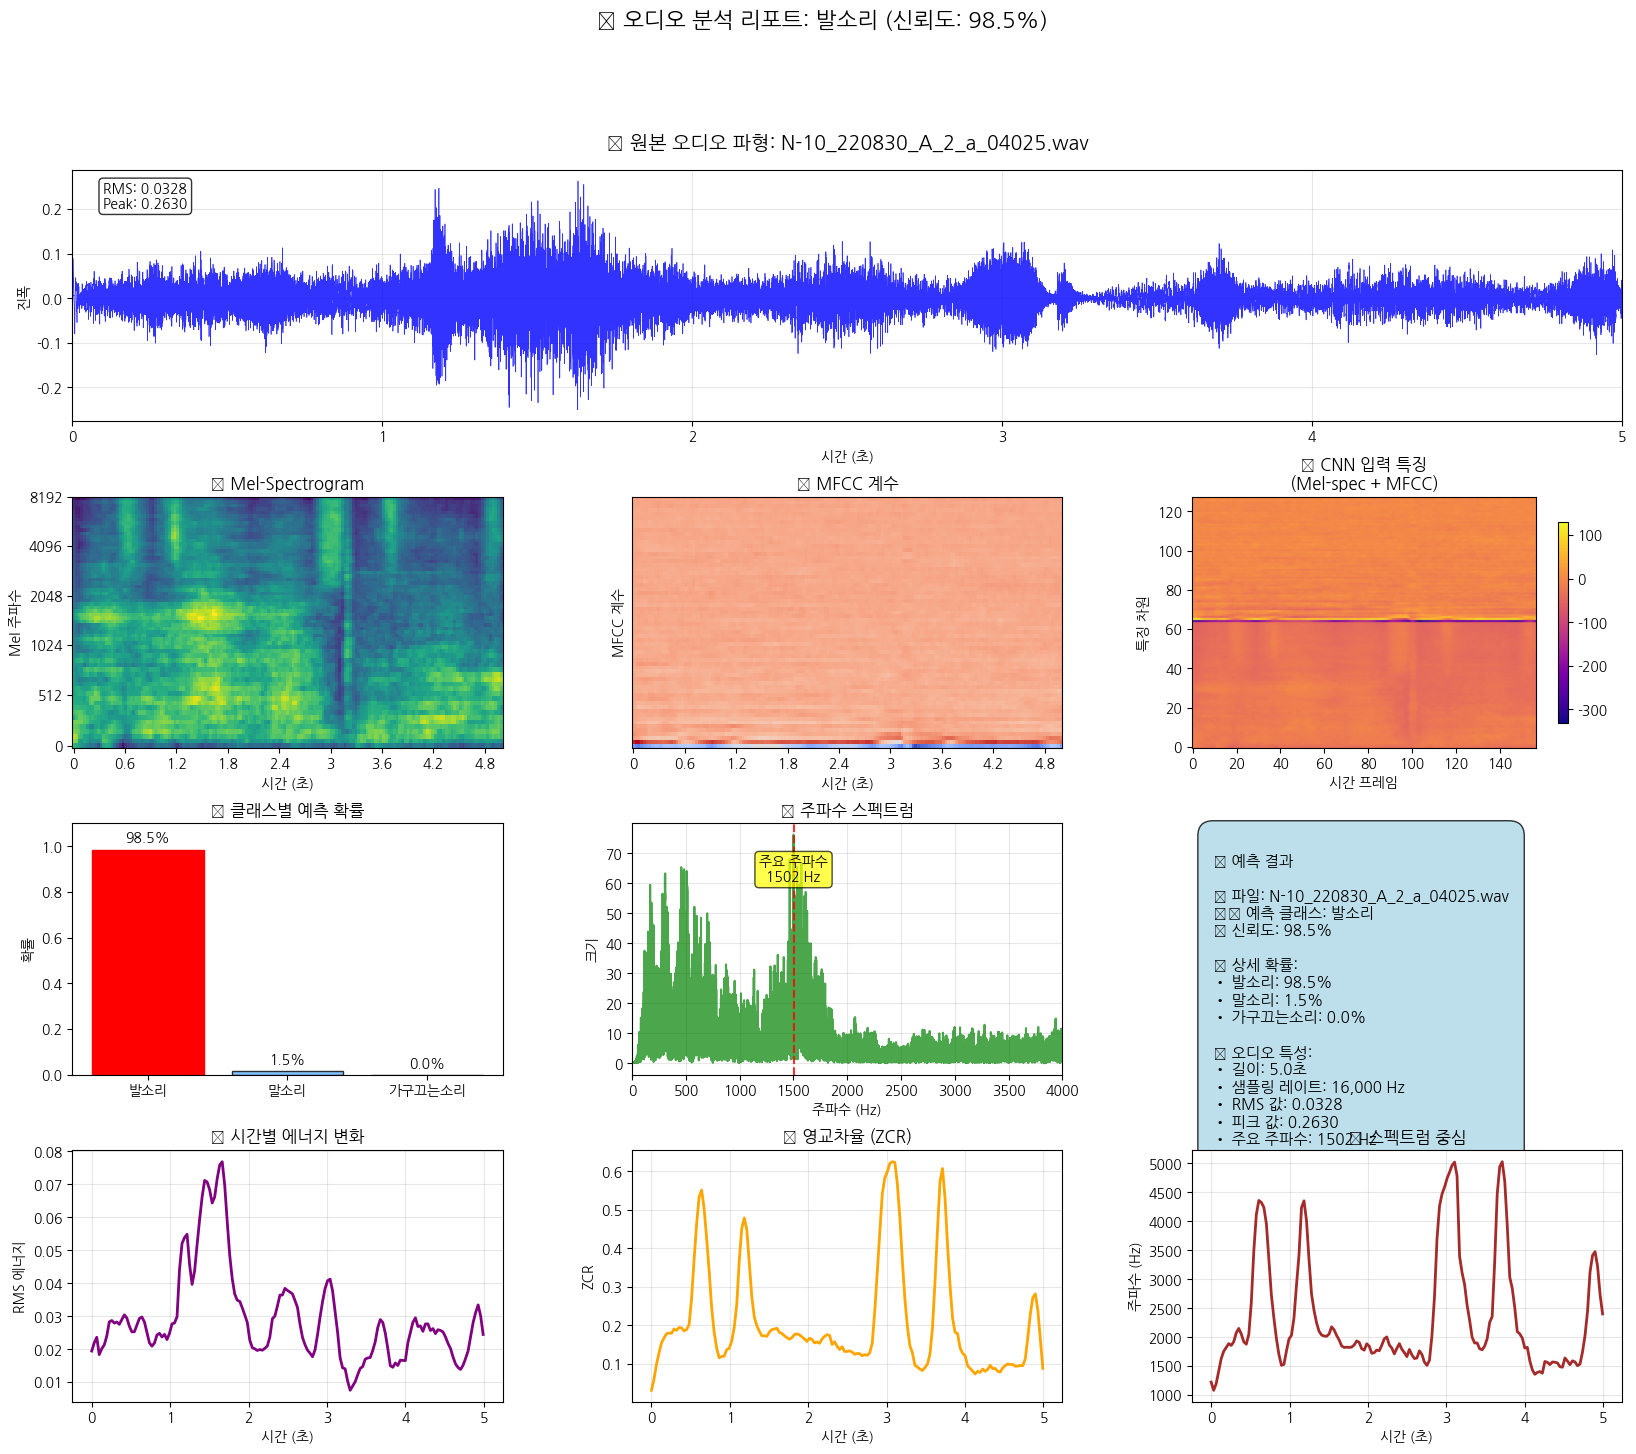


🎯 실시간 예측 결과
🔍 예측 클래스: 발소리
📊 신뢰도: 98.5%

📈 각 클래스별 확률:
   발소리         : 0.985 |███████████████████
   말소리         : 0.015 |
   가구끄는소리      : 0.000 |


{'filename': 'N-10_220830_A_2_a_04025.wav',
 'predicted_class': '발소리',
 'predicted_class_en': 'footstep',
 'confidence': 0.9850442409515381,
 'probabilities': {'발소리': 0.9850442409515381,
  '말소리': 0.014935711398720741,
  '가구끄는소리': 2.0101442714803852e-05},
 'audio_features': {'rms': 0.03276107460260391,
  'peak': 0.2629835307598114,
  'dominant_frequency': 1501.8000000000002,
  'duration': 5.0}}

In [52]:
analyze_uploaded_file(r"/content/drive/MyDrive/Colab Notebooks/finaldata")